In [1]:
#trial 6 depth

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

In [3]:
import h5py

filename = "physio.h5"



#h5.head()

In [4]:
label_file = 'REFERENCE-v3.csv'
df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
df_stat = df.groupby('label').agg('count').reset_index()
df_stat.columns = ['label', 'recordings']
df_stat = df_stat.assign(percent = (100 * np.around(df_stat.recordings/df.shape[0], 2)).astype(np.int))
print(df_stat)
df_set = list(df.label.unique())

  label  recordings  percent
0     A         758        9
1     N        5076       60
2     O        2415       28
3     ~         279        3


/var/folders/lp/w_5688p55h7_hr8mv0k67_n00000gn/T/ipykernel_13298/2585866670.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_stat = df_stat.assign(percent = (100 * np.around(df_stat.recordings/df.shape[0], 2)).astype(np.int))


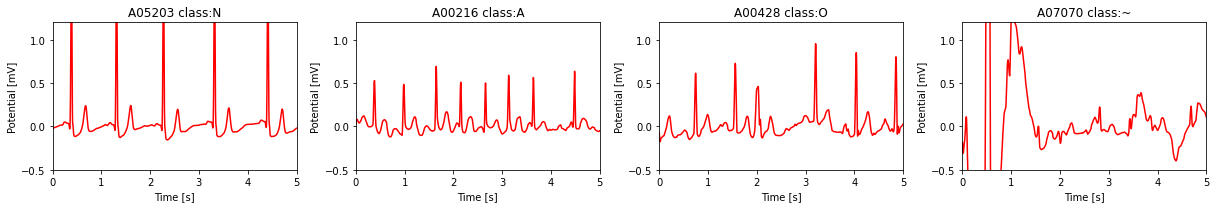

In [5]:
from physionet_processing import fetch_h5data
np.random.seed(148)

# Open large hdf5 file (download https://s3.us-east-2.amazonaws.com/cscie89/physio.h5)
h5file =  h5py.File(filename, 'r')

# Get a list of dataset names 
dataset_list = list(h5file.keys())

def get_sample():
    # Pick one ECG randomly from each class 
    fid_list = [np.random.choice(df[df.label == label].name.values, 1)[0] for label in df_set]
    return fid_list

name_list = get_sample()
slen = 1500
idx_list = [dataset_list.index(name) for name in name_list]
data = fetch_h5data(h5file, idx_list, sequence_length = slen)
time = np.arange(0, slen)/300

fig, ax = plt.subplots(1, len(idx_list), figsize = (17, 3))

for i, ax1 in enumerate(ax):
    
    ax1.plot(time, data[i], color = 'r')
    ax1.set(xlim = [0, 5], xticks = np.arange(0, 5.5, 1),
            ylim = [-0.5, 1.2], yticks = np.arange(-0.5, 1.2, 0.5),
            xlabel = 'Time [s]', ylabel = 'Potential [mV]')
    ax1.set_title(name_list[i] + ' class:' + df_set[i])


plt.tight_layout()
plt.show()    
fig.savefig('physionet_classes.png', bbox_inches = 'tight', dpi = 150)

Unique sampling rates in dataset: [300.0]
Unique gain settings in dataset: [1000.0]
Unique baseline settings: [0.0]
Sequence lengths [min, max]: [2714, 18286]
Recording times in seconds [min, max]: [9.047, 60.953]


/Users/sahil/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


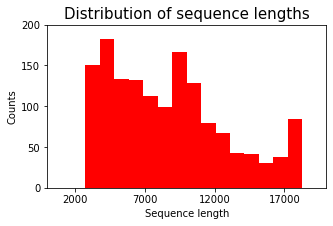

In [6]:
#

from physionet_processing import special_parameters

sequence_lengths, sampling_rates, recording_times, baselines, gains = special_parameters(h5file)
sequence_length_min, sequence_length_max = np.min(sequence_lengths), np.max(sequence_lengths)
recording_time_min, recording_time_max = np.min(recording_times), np.max(recording_times)

print('Unique sampling rates in dataset:', sampling_rates)
print('Unique gain settings in dataset:', gains)
print('Unique baseline settings:', baselines)
print('Sequence lengths [min, max]:', [sequence_length_min, sequence_length_max])
print('Recording times in seconds [min, max]: [%.3f, %.3f]' %(recording_time_min, recording_time_max))

# Plot a histogram of sequence lengths
fig = plt.figure(figsize = (5, 3))
f = sns.distplot(list(sequence_lengths), norm_hist = False, kde = False, color = 'red', hist_kws=dict(alpha=1))
f.set(xlabel = 'Sequence length', xlim = [0, 20000], xticks = np.arange(2000, 20000, 5000))
f.set(ylabel = 'Counts', ylim = [0, 200], yticks = np.arange(0, 250, 50))
plt.title('Distribution of sequence lengths', fontsize=15)
plt.show()
fig.savefig('physionet_sequenceLenHist.png', bbox_inches = 'tight', dpi = 150)

# Based on this, we can set some parameters that we will use in the future
fs = sampling_rates[0] # universal sampling rate
sequence_length = sequence_length_max # will use the maximum sequence length


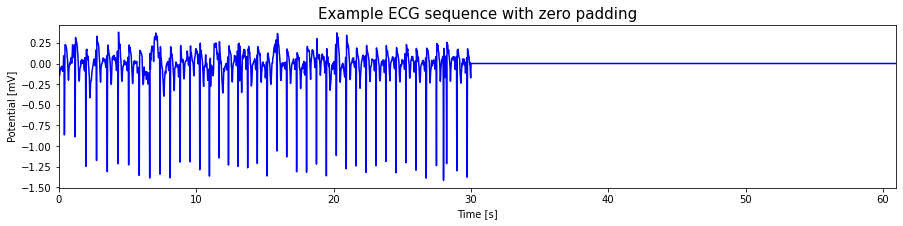

In [7]:
#1. Zero padding to extend sequences

from physionet_processing import extend_ts

ts = h5file[dataset_list[15]]['ecgdata'][:, 0] # Fetch one time series from the hdf5 file
#ts = h5file[list(h5file.keys())[20]]['ecgdata']
ts_extended = extend_ts(ts, length = sequence_length_max) # Extend it to the maximum length
time = np.arange(0, len(ts_extended))/fs

# Plot the the extended time series
fig, ax1 = plt.subplots(figsize = (15, 3))
ax1.plot(time, ts_extended, 'b')
ax1.set(xlabel = 'Time [s]', xlim = [0, time[-1]], xticks = np.arange(0, time[-1]+5, 10))
ax1.set(ylabel = 'Potential [mV]')
plt.title('Example ECG sequence with zero padding', fontsize = 15)
fig.savefig('physionet_ECG_padding.png', bbox_inches = 'tight', dpi = 150)
plt.show()

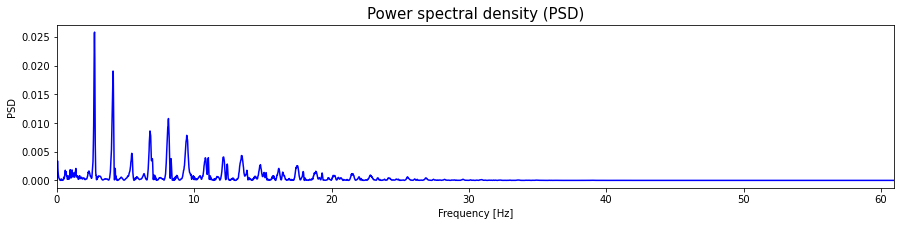

In [8]:
#2. Time series conversion into spectrograms

from scipy import signal
f1, PSD = signal.periodogram(ts_extended, fs, 'flattop', scaling = 'density')
fig, ax1 = plt.subplots(figsize = (15, 3))
ax1.plot(f1, PSD, 'b')
ax1.set(xlabel = 'Frequency [Hz]', xlim = [0, time[-1]], xticks = np.arange(0, time[-1]+5, 10))
ax1.set(ylabel = 'PSD')
plt.title('Power spectral density (PSD)', fontsize = 15)
fig.savefig('physionet_ECG_PSD.png', bbox_inches = 'tight', dpi = 150)
plt.show()

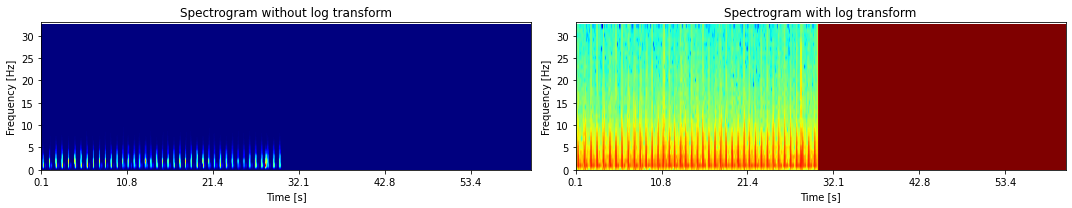

In [9]:
from physionet_processing import spectrogram

# Convert ECG into spectrograms without and with log transform
Sx = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False)[2]
Sx_log = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = True)[2]

# Get the frequency and time axes
f, t, _ = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False) 

# Plot the spectrograms as images
im_list = [Sx[0], Sx_log[0]]
im_title = ['Spectrogram without log transform', 'Spectrogram with log transform']
fig, ax_list = plt.subplots(1, 2, figsize = (15, 3))

for i, ax in enumerate(ax_list):
    
    ax.imshow(np.transpose(im_list[i]), aspect = 'auto', cmap = 'jet')
    ax.grid(False)
    ax.invert_yaxis()
    ax.set_title(im_title[i], fontsize = 12)
    ax.set(ylim = [0, im_list[i].shape[1]], yticks = np.arange(0, im_list[i].shape[1] + 1, 5))
    ax.set(xlabel = 'Time [s]', ylabel = 'Frequency [Hz]')
    
    # Replace axis labels with time from t array
    xticks_array = np.arange(0, im_list[i].shape[0] + 1, 100)
    ax.set(xlim = [0, im_list[i].shape[0]], xticks = xticks_array)
    labels_new = [str(np.around(t[label], decimals = 1)) for label in xticks_array]
    ax.set_xticklabels(labels_new)
    ax.tick_params(axis = 'x',
                   which = 'both',
                   bottom = 'off')
    
    ax.tick_params(axis = 'y',
                   which = 'both',
                   left = 'off')

plt.tight_layout()
plt.show()
fig.savefig('physionet_ECG_spectrogram.png', bbox_inches = 'tight', dpi = 150)

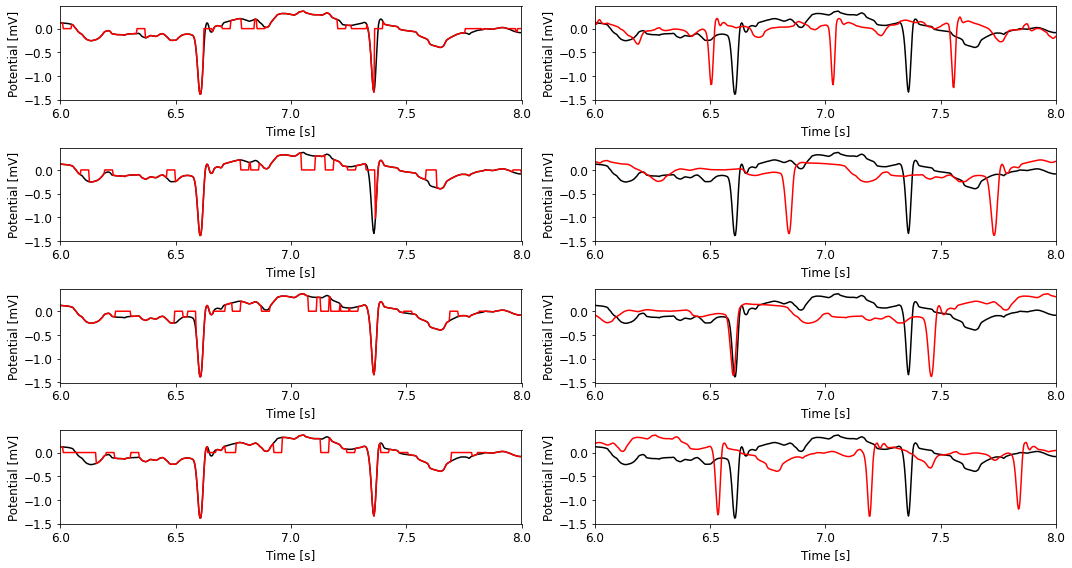

In [10]:
#3. Data augmentation to reduce overfitting

from physionet_processing import zero_filter, random_resample

data_zero = [] # collect the zero burst data here
data_resampled = [] # list for resampled data
runs = 4

for i in range(runs):
    data_zero.append(zero_filter(np.expand_dims(ts_extended, axis = 0), threshold = 2, depth = 10)[0])
    data_resampled.append(random_resample(np.expand_dims(ts_extended, axis = 0))[0])

# Plot the result
fig, axarr = plt.subplots(runs, 2, figsize = (15, 8))
x_lim = [6, 8] # zoom in on x axis
x_ticks = np.arange(x_lim[0], x_lim[1] + 0.5, 0.5) # ticks
x_label = 'Time [s]'
y_label = 'Potential [mV]'

for row in range(runs):
    
    # Plot the dropout burst data
    ax = axarr[row, 0]
    ax.plot(time, ts_extended, 'k')
    ax.plot(time, data_zero[row], 'r')
    ax.set(xlim = x_lim, xticks = x_ticks)
    ax.set(xlabel = x_label, ylabel = y_label)
    
    # Plot the resampling data
    ax = axarr[row, 1]
    ax.plot(time, ts_extended, 'k')
    ax.plot(time, data_resampled[row], 'r')
    ax.set(xlim = x_lim, xticks = x_ticks)
    ax.set(xlabel = x_label, ylabel = y_label)
    
for ax in np.ndarray.flatten(axarr):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

plt.tight_layout()
#plt.suptitle('Data augmentation: dropout bursts and random resampling', fontsize = 15)
plt.show()
fig.savefig('physionet_augmentation.png', bbox_inches = 'tight', dpi = 150)

In [11]:
# The initialization function of the generator class defines the parameters 
# that are needed for ECG processing
'Generates data for Keras'
def __init__(self, h5file, list_IDs, labels, batch_size = 32, dim = (178, 33), 
             nperseg = 64, noverlap = 32,
             n_channels=1, sequence_length = 5736,
             n_classes = 4, shuffle = True, augment = False):
    
    'Initialization'
    self.h5file = h5file
    self.list_IDs = list_IDs
    self.labels = labels
    self.batch_size = batch_size
    self.dim = dim
    self.nperseg = nperseg
    self.noverlap = noverlap
    self.n_channels = n_channels
    self.sequence_length = sequence_length
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.augment = augment
    self.on_epoch_end()

In [12]:
def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype = float)
        y = np.empty((self.batch_size), dtype = int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            data = extend_ts(self.h5file[ID]['ecgdata'][:, 0], self.sequence_length)
            data = np.reshape(data, (1, len(data)))
        
            if self.augment:
            
                # dropout bursts
                data = zero_filter(data, threshold = 2, depth = 10)
            
                # random resampling
                data = random_resample(data)
            
            # Generate spectrogram
            data_spectrogram = spectrogram(data, nperseg = self.nperseg, noverlap = self.noverlap)[2]
            
            # Normalize spectrogram
            #data_transformed = norm_float(data_spectrogram, self.data_mean, self.data_std)
            data_norm = (data_spectrogram - np.mean(data_spectrogram))/np.std(data_spectrogram)
        
            X[i,] = np.expand_dims(data_norm, axis = 3)
        
            # Assuming that the dataset names are unique (only 1 per label)
            y[i] = self.labels[ID]

        return X, keras.utils.np_utils.to_categorical(y, num_classes=self.n_classes)
    
    

In [13]:
from sklearn.preprocessing import LabelEncoder

# Load the labels:
label_df = pd.read_csv(label_file, header = None, names = ['name', 'label'])

# Hot-encode the labels
label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))

print('Unique labels:', encoder.inverse_transform(label_set_codings))
print('Unique codings:', label_set_codings)
print('Dataset labels:\n', label_df.iloc[100:110,])

Unique labels: ['A' 'N' 'O' '~']
Unique codings: [0 1 2 3]
Dataset labels:
        name label  encoded
100  A00101     A        0
101  A00102     A        0
102  A00103     O        2
103  A00104     N        1
104  A00105     N        1
105  A00106     ~        3
106  A00107     A        0
107  A00108     O        2
108  A00109     N        1
109  A00110     O        2


In [14]:
from sklearn.model_selection import train_test_split

# Split the IDs in training and validation set
test_split = 0.33
idx = np.arange(label_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                         test_size = test_split,
                                         shuffle = True,
                                         random_state = 123)

# Store the ids and labels in dictionaries
partition = {'train': list(label_df.iloc[id_train,].name), 
             'validation': list(label_df.iloc[id_val,].name)}

labels = dict(zip(label_df.name, label_df.encoded))

In [15]:
# Parameters needed for the DataGenerator class
# Maximum sequence length
max_length = sequence_length

# Output dimensions
sequence_length = sequence_length_max # Use the maximum sequence length in the data set
spectrogram_nperseg = 64 # Spectrogram hanning window width
spectrogram_noverlap = 32 # Spectrogram hanning window overlap
n_classes = len(label_df.label.unique()) # Number of classes
batch_size = 32

# Use one spectrogram to detemine the image dimensions
Sx_log = spectrogram(np.expand_dims(ts_extended, axis = 0),
                     nperseg = spectrogram_nperseg,
                     noverlap = spectrogram_noverlap,
                     log_spectrogram = True)[2]
dim = Sx_log[0].shape

In [16]:
from physionet_generator import DataGenerator

params = {'batch_size': batch_size,
          'dim': dim,
          'nperseg': spectrogram_nperseg,
          'noverlap': spectrogram_noverlap,
          'n_channels': 1,
          'sequence_length': sequence_length,
          'n_classes': n_classes,
          'shuffle': True}

train_generator = DataGenerator(h5file, partition['train'], labels, augment = True, **params)
val_generator = DataGenerator(h5file, partition['validation'], labels, augment = False, **params)

for i, batch in enumerate(train_generator):
    if i == 1:
        break

X = batch[0]
y = batch[1]

print('X shape:', X.shape)
print('y shape:', y.shape)
print('X type:', np.dtype(X[0,0,0,0]))

X shape: (32, 570, 33, 1)
y shape: (32, 4)
X type: float64


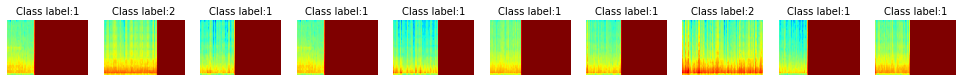

In [17]:
def imshow_batch(X, y, batch_idx):
    
    batch_labels = ['Class label:' + str(np.argmax(y[idx,])) for idx in batch_idx]

    fig, ax = plt.subplots(1, len(batch_idx), figsize = (17, 1))

    for i, idx in enumerate(batch_idx):
    
        ax[i].imshow(X[idx, :, :, 0].transpose(), cmap = 'jet', aspect = 'auto')
        ax[i].grid(False)
        ax[i].axis('off')
        ax[i].invert_yaxis()
        ax[i].set_title(batch_labels[i], fontsize = 10)
    
    plt.show()
        
    return fig

batch_idx = np.random.randint(0, batch_size, size = 10) 
fig = imshow_batch(X, y, batch_idx)
fig.savefig('physionet_Batch.png', bbox_inches = 'tight', dpi = 150)
plt.show()

In [18]:
#Define the Keras model

# Convolutional blocks
def conv2d_block(model, depth, layer_filters, filters_growth, 
                 strides_start, strides_end, input_shape, first_layer = False):
    
    ''' Convolutional block. 
    depth: number of convolutional layers in the block (4)
    filters: 2D kernel size (32)
    filters_growth: kernel size increase at the end of block (32)
    first_layer: provide input_shape for first layer'''
    
    # Fixed parameters for convolution
    conv_parms = {'kernel_size': (3, 3),
                  'padding': 'same',
                  'dilation_rate': (1, 1),
                  'activation': None,
                  'data_format': 'channels_last',
                  'kernel_initializer': 'glorot_normal'}

    for l in range(depth):

        if first_layer:
            
            # First layer needs an input_shape 
            model.add(layers.Conv2D(filters = layer_filters,
                                    strides = strides_start,
                                    input_shape = input_shape, **conv_parms))
            first_layer = False
        
        else:
            # All other layers will not need an input_shape parameter
            if l == depth - 1:
                # Last layer in each block is different: adding filters and using stride 2
                layer_filters += filters_growth
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_end, **conv_parms))
            else:
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_start, **conv_parms))
        
        # Continue with batch normalization and activation for all layers in the block
        model.add(layers.BatchNormalization(center = True, scale = True))
        model.add(layers.Activation('relu'))
    
    return model

In [19]:
# Input shape
n_channels = 1 # Number of color channgels
input_shape = (*dim, n_channels) # input shape for first layer

# Hyperparameters
filters_start = 32 # Number of convolutional filters
layer_filters = filters_start # Start with these filters
filters_growth = 32 # Filter increase after each convBlock
strides_start = (1, 1) # Strides at the beginning of each convBlock
strides_end = (2, 2) # Strides at the end of each convBlock
depth = 6 # Number of convolutional layers in each convBlock
n_blocks = 6 # Number of ConBlocks

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

model = Sequential()

for block in range(n_blocks):

    # Provide input only for the first layer
    if block == 0:
        provide_input = True
    else:
        provide_input = False
    
    model = conv2d_block(model, depth,
                         layer_filters,
                         filters_growth,
                         strides_start, strides_end,
                         input_shape,
                         first_layer = provide_input)
    
    # Increase the number of filters after each block
    layer_filters += filters_growth

2022-08-30 12:15:58.666149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
#Feature aggregation over time
# Define temporal feature avaraging layer
import tensorflow.keras.backend as K
def MeanOverTime():
    lam_layer = layers.Lambda(lambda x: K.mean(x, axis=1), output_shape=lambda s: (1, s[2]))
    return lam_layer

# Reshape to (batch, time steps, filters)
model.add(layers.Reshape((-1, 224)))
model.add(layers.Masking(mask_value = 0.0))
model.add(MeanOverTime())

# And a fully connected layer for the output
model.add(layers.Dense(4, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 570, 33, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 570, 33, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 570, 33, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 570, 33, 32)       9248      
                                                                 
 batch_normalization_1 (Batc  (None, 570, 33, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 570, 33, 32)       0

 batch_normalization_17 (Bat  (None, 72, 5, 128)       512       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 72, 5, 128)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 72, 5, 128)        147584    
                                                                 
 batch_normalization_18 (Bat  (None, 72, 5, 128)       512       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 72, 5, 128)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 5, 128)        147584    
                                                                 
 batch_normalization_19 (Bat  (None, 72, 5, 128)       512       
 chNormali

                                                                 
 batch_normalization_35 (Bat  (None, 9, 1, 224)        896       
 chNormalization)                                                
                                                                 
 activation_35 (Activation)  (None, 9, 1, 224)         0         
                                                                 
 reshape (Reshape)           (None, 9, 224)            0         
                                                                 
 masking (Masking)           (None, 9, 224)            0         
                                                                 
 lambda (Lambda)             (None, 224)               0         
                                                                 
 dense (Dense)               (None, 4)                 900       
                                                                 
Total params: 5,238,564
Trainable params: 5,230,116
Non-trainable params: 8,

In [22]:
# pip install pydot

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [24]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [25]:
import datetime
from tensorflow import keras
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='Models_TF/model_{epoch}',
        save_freq='epoch'),
    tensorboard_callback
]

In [27]:
df_stat

,label,recordings,percent
0,A,758,9
1,N,5076,60
2,O,2415,28
3,~,279,3


In [28]:
total = df_stat['recordings'].sum()

In [29]:
df_stat['weight'] = total/df_stat['recordings']

In [30]:
df_stat

,label,recordings,percent,weight
0,A,758,9,11.250660
1,N,5076,60,1.680063
2,O,2415,28,3.531263
3,~,279,3,30.566308


In [31]:
df_stat['weight'][1]

1.6800630417651694

In [32]:
df_set

['N', 'A', 'O', '~']

In [33]:
class_weight = {0: df_stat['weight'][1],
                1: df_stat['weight'][0],
                2: df_stat['weight'][2],
                3: df_stat['weight'][3]}

In [34]:
class_weight

{0: 1.6800630417651694,
 1: 11.25065963060686,
 2: 3.531262939958592,
 3: 30.566308243727597}

In [35]:
# Compile the model and run a batch through the network
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

In [36]:


model.fit(train_generator,
                              steps_per_epoch = 50,
                              epochs = 700,
                              validation_data = val_generator,
                              validation_steps = 50,
          callbacks=[callbacks], class_weight = class_weight)

Epoch 1/700
50/50 [==============================] - ETA: 0s - loss: 7.4085 - acc: 0.5681 

INFO:tensorflow:Assets written to: Models_TF/model_1/assets


INFO:tensorflow:Assets written to: Models_TF/model_1/assets


50/50 [==============================] - 1044s 21s/step - loss: 7.4085 - acc: 0.5681 - val_loss: 1.4100 - val_acc: 0.5688
Epoch 2/700
50/50 [==============================] - ETA: 0s - loss: 6.1641 - acc: 0.6069 

INFO:tensorflow:Assets written to: Models_TF/model_2/assets


INFO:tensorflow:Assets written to: Models_TF/model_2/assets


50/50 [==============================] - 1121s 23s/step - loss: 6.1641 - acc: 0.6069 - val_loss: 1.0366 - val_acc: 0.6000
Epoch 3/700
50/50 [==============================] - ETA: 0s - loss: 6.9803 - acc: 0.5906 

INFO:tensorflow:Assets written to: Models_TF/model_3/assets


INFO:tensorflow:Assets written to: Models_TF/model_3/assets


50/50 [==============================] - 1015s 20s/step - loss: 6.9803 - acc: 0.5906 - val_loss: 1.7423 - val_acc: 0.0294
Epoch 4/700
50/50 [==============================] - ETA: 0s - loss: 6.9482 - acc: 0.5844 

INFO:tensorflow:Assets written to: Models_TF/model_4/assets


INFO:tensorflow:Assets written to: Models_TF/model_4/assets


50/50 [==============================] - 856s 17s/step - loss: 6.9482 - acc: 0.5844 - val_loss: 1.3884 - val_acc: 0.5913
Epoch 5/700
50/50 [==============================] - ETA: 0s - loss: 6.1330 - acc: 0.6075  

INFO:tensorflow:Assets written to: Models_TF/model_5/assets


INFO:tensorflow:Assets written to: Models_TF/model_5/assets


50/50 [==============================] - 11859s 242s/step - loss: 6.1330 - acc: 0.6075 - val_loss: 1.1478 - val_acc: 0.2925
Epoch 6/700
50/50 [==============================] - ETA: 0s - loss: 6.7208 - acc: 0.6056 

INFO:tensorflow:Assets written to: Models_TF/model_6/assets


INFO:tensorflow:Assets written to: Models_TF/model_6/assets


50/50 [==============================] - 1145s 23s/step - loss: 6.7208 - acc: 0.6056 - val_loss: 1.2191 - val_acc: 0.5763
Epoch 7/700
50/50 [==============================] - ETA: 0s - loss: 6.4698 - acc: 0.5987 

INFO:tensorflow:Assets written to: Models_TF/model_7/assets


INFO:tensorflow:Assets written to: Models_TF/model_7/assets


50/50 [==============================] - 1080s 22s/step - loss: 6.4698 - acc: 0.5987 - val_loss: 1.0992 - val_acc: 0.5756
Epoch 8/700
50/50 [==============================] - ETA: 0s - loss: 6.3833 - acc: 0.6012 

INFO:tensorflow:Assets written to: Models_TF/model_8/assets


INFO:tensorflow:Assets written to: Models_TF/model_8/assets


50/50 [==============================] - 1128s 23s/step - loss: 6.3833 - acc: 0.6012 - val_loss: 1.2636 - val_acc: 0.5713
Epoch 9/700
50/50 [==============================] - ETA: 0s - loss: 6.4228 - acc: 0.5931 

INFO:tensorflow:Assets written to: Models_TF/model_9/assets


INFO:tensorflow:Assets written to: Models_TF/model_9/assets


50/50 [==============================] - 1088s 22s/step - loss: 6.4228 - acc: 0.5931 - val_loss: 1.2563 - val_acc: 0.5719
Epoch 10/700
50/50 [==============================] - ETA: 0s - loss: 6.6401 - acc: 0.5856 

INFO:tensorflow:Assets written to: Models_TF/model_10/assets


INFO:tensorflow:Assets written to: Models_TF/model_10/assets


50/50 [==============================] - 1066s 21s/step - loss: 6.6401 - acc: 0.5856 - val_loss: 1.6508 - val_acc: 0.5763
Epoch 11/700
50/50 [==============================] - ETA: 0s - loss: 6.3783 - acc: 0.6100 

INFO:tensorflow:Assets written to: Models_TF/model_11/assets


INFO:tensorflow:Assets written to: Models_TF/model_11/assets


50/50 [==============================] - 1124s 23s/step - loss: 6.3783 - acc: 0.6100 - val_loss: 3.6657 - val_acc: 0.0325
Epoch 12/700
50/50 [==============================] - ETA: 0s - loss: 6.1489 - acc: 0.5900 

INFO:tensorflow:Assets written to: Models_TF/model_12/assets


INFO:tensorflow:Assets written to: Models_TF/model_12/assets


50/50 [==============================] - 1060s 21s/step - loss: 6.1489 - acc: 0.5900 - val_loss: 1.9829 - val_acc: 0.0256
Epoch 13/700
50/50 [==============================] - ETA: 0s - loss: 6.3884 - acc: 0.5913 

INFO:tensorflow:Assets written to: Models_TF/model_13/assets


INFO:tensorflow:Assets written to: Models_TF/model_13/assets


50/50 [==============================] - 1109s 22s/step - loss: 6.3884 - acc: 0.5913 - val_loss: 2.1812 - val_acc: 0.1944
Epoch 14/700
50/50 [==============================] - ETA: 0s - loss: 6.0743 - acc: 0.5856 

INFO:tensorflow:Assets written to: Models_TF/model_14/assets


INFO:tensorflow:Assets written to: Models_TF/model_14/assets


50/50 [==============================] - 1062s 21s/step - loss: 6.0743 - acc: 0.5856 - val_loss: 2.1055 - val_acc: 0.5900
Epoch 15/700
50/50 [==============================] - ETA: 0s - loss: 5.8045 - acc: 0.5900 

INFO:tensorflow:Assets written to: Models_TF/model_15/assets


INFO:tensorflow:Assets written to: Models_TF/model_15/assets


50/50 [==============================] - 1091s 22s/step - loss: 5.8045 - acc: 0.5900 - val_loss: 2.0767 - val_acc: 0.5781
Epoch 16/700
50/50 [==============================] - ETA: 0s - loss: 6.2189 - acc: 0.5938 

INFO:tensorflow:Assets written to: Models_TF/model_16/assets


INFO:tensorflow:Assets written to: Models_TF/model_16/assets


50/50 [==============================] - 1069s 21s/step - loss: 6.2189 - acc: 0.5938 - val_loss: 1.6622 - val_acc: 0.5331
Epoch 17/700
50/50 [==============================] - ETA: 0s - loss: 5.7735 - acc: 0.5731 

INFO:tensorflow:Assets written to: Models_TF/model_17/assets


INFO:tensorflow:Assets written to: Models_TF/model_17/assets


50/50 [==============================] - 1106s 22s/step - loss: 5.7735 - acc: 0.5731 - val_loss: 1.9248 - val_acc: 0.0525
Epoch 18/700
50/50 [==============================] - ETA: 0s - loss: 5.3514 - acc: 0.5869 

INFO:tensorflow:Assets written to: Models_TF/model_18/assets


INFO:tensorflow:Assets written to: Models_TF/model_18/assets


50/50 [==============================] - 1118s 22s/step - loss: 5.3514 - acc: 0.5869 - val_loss: 1.5537 - val_acc: 0.5994
Epoch 19/700
50/50 [==============================] - ETA: 0s - loss: 6.1260 - acc: 0.6037 

INFO:tensorflow:Assets written to: Models_TF/model_19/assets


INFO:tensorflow:Assets written to: Models_TF/model_19/assets


50/50 [==============================] - 1088s 22s/step - loss: 6.1260 - acc: 0.6037 - val_loss: 2.6763 - val_acc: 0.0331
Epoch 20/700
50/50 [==============================] - ETA: 0s - loss: 6.3398 - acc: 0.5888 

INFO:tensorflow:Assets written to: Models_TF/model_20/assets


INFO:tensorflow:Assets written to: Models_TF/model_20/assets


50/50 [==============================] - 1086s 22s/step - loss: 6.3398 - acc: 0.5888 - val_loss: 2.2595 - val_acc: 0.0288
Epoch 21/700
50/50 [==============================] - ETA: 0s - loss: 6.2441 - acc: 0.6025 

INFO:tensorflow:Assets written to: Models_TF/model_21/assets


INFO:tensorflow:Assets written to: Models_TF/model_21/assets


50/50 [==============================] - 1083s 22s/step - loss: 6.2441 - acc: 0.6025 - val_loss: 14.1718 - val_acc: 0.0312
Epoch 22/700
50/50 [==============================] - ETA: 0s - loss: 5.9109 - acc: 0.6087 

INFO:tensorflow:Assets written to: Models_TF/model_22/assets


INFO:tensorflow:Assets written to: Models_TF/model_22/assets


50/50 [==============================] - 1120s 22s/step - loss: 5.9109 - acc: 0.6087 - val_loss: 2.0500 - val_acc: 0.3200
Epoch 23/700
50/50 [==============================] - ETA: 0s - loss: 5.9777 - acc: 0.5831 

INFO:tensorflow:Assets written to: Models_TF/model_23/assets


INFO:tensorflow:Assets written to: Models_TF/model_23/assets


50/50 [==============================] - 1085s 22s/step - loss: 5.9777 - acc: 0.5831 - val_loss: 1.0934 - val_acc: 0.5756
Epoch 24/700
50/50 [==============================] - ETA: 0s - loss: 5.5171 - acc: 0.5938 

INFO:tensorflow:Assets written to: Models_TF/model_24/assets


INFO:tensorflow:Assets written to: Models_TF/model_24/assets


50/50 [==============================] - 1055s 21s/step - loss: 5.5171 - acc: 0.5938 - val_loss: 1.6166 - val_acc: 0.5631
Epoch 25/700
50/50 [==============================] - ETA: 0s - loss: 5.5108 - acc: 0.6006 

INFO:tensorflow:Assets written to: Models_TF/model_25/assets


INFO:tensorflow:Assets written to: Models_TF/model_25/assets


50/50 [==============================] - 1092s 22s/step - loss: 5.5108 - acc: 0.6006 - val_loss: 2.6865 - val_acc: 0.5888
Epoch 26/700
50/50 [==============================] - ETA: 0s - loss: 5.2638 - acc: 0.5956 

INFO:tensorflow:Assets written to: Models_TF/model_26/assets


INFO:tensorflow:Assets written to: Models_TF/model_26/assets


50/50 [==============================] - 1061s 21s/step - loss: 5.2638 - acc: 0.5956 - val_loss: 1.4664 - val_acc: 0.5863
Epoch 27/700
50/50 [==============================] - ETA: 0s - loss: 5.3946 - acc: 0.6087 

INFO:tensorflow:Assets written to: Models_TF/model_27/assets


INFO:tensorflow:Assets written to: Models_TF/model_27/assets


50/50 [==============================] - 1088s 22s/step - loss: 5.3946 - acc: 0.6087 - val_loss: 1.7082 - val_acc: 0.4225
Epoch 28/700
50/50 [==============================] - ETA: 0s - loss: 6.0130 - acc: 0.5731 

INFO:tensorflow:Assets written to: Models_TF/model_28/assets


INFO:tensorflow:Assets written to: Models_TF/model_28/assets


50/50 [==============================] - 1090s 22s/step - loss: 6.0130 - acc: 0.5731 - val_loss: 2.4311 - val_acc: 0.5813
Epoch 29/700
50/50 [==============================] - ETA: 0s - loss: 5.1953 - acc: 0.6050 

INFO:tensorflow:Assets written to: Models_TF/model_29/assets


INFO:tensorflow:Assets written to: Models_TF/model_29/assets


50/50 [==============================] - 1104s 22s/step - loss: 5.1953 - acc: 0.6050 - val_loss: 1.5553 - val_acc: 0.5600
Epoch 30/700
50/50 [==============================] - ETA: 0s - loss: 5.5179 - acc: 0.6050 

INFO:tensorflow:Assets written to: Models_TF/model_30/assets


INFO:tensorflow:Assets written to: Models_TF/model_30/assets


50/50 [==============================] - 1128s 23s/step - loss: 5.5179 - acc: 0.6050 - val_loss: 83.9829 - val_acc: 0.0700
Epoch 31/700
50/50 [==============================] - ETA: 0s - loss: 5.3560 - acc: 0.6106 

INFO:tensorflow:Assets written to: Models_TF/model_31/assets


INFO:tensorflow:Assets written to: Models_TF/model_31/assets


50/50 [==============================] - 1124s 23s/step - loss: 5.3560 - acc: 0.6106 - val_loss: 1.3338 - val_acc: 0.5781
Epoch 32/700
50/50 [==============================] - ETA: 0s - loss: 5.5943 - acc: 0.5913 

INFO:tensorflow:Assets written to: Models_TF/model_32/assets


INFO:tensorflow:Assets written to: Models_TF/model_32/assets


50/50 [==============================] - 1079s 22s/step - loss: 5.5943 - acc: 0.5913 - val_loss: 1.2624 - val_acc: 0.5744
Epoch 33/700
50/50 [==============================] - ETA: 0s - loss: 5.7792 - acc: 0.5644 

INFO:tensorflow:Assets written to: Models_TF/model_33/assets


INFO:tensorflow:Assets written to: Models_TF/model_33/assets


50/50 [==============================] - 1073s 21s/step - loss: 5.7792 - acc: 0.5644 - val_loss: 1.5365 - val_acc: 0.5619
Epoch 34/700
50/50 [==============================] - ETA: 0s - loss: 5.3995 - acc: 0.5975 

INFO:tensorflow:Assets written to: Models_TF/model_34/assets


INFO:tensorflow:Assets written to: Models_TF/model_34/assets


50/50 [==============================] - 1058s 21s/step - loss: 5.3995 - acc: 0.5975 - val_loss: 1.2174 - val_acc: 0.5825
Epoch 35/700
50/50 [==============================] - ETA: 0s - loss: 5.4276 - acc: 0.6025 

INFO:tensorflow:Assets written to: Models_TF/model_35/assets


INFO:tensorflow:Assets written to: Models_TF/model_35/assets


50/50 [==============================] - 1116s 22s/step - loss: 5.4276 - acc: 0.6025 - val_loss: 1.3522 - val_acc: 0.5994
Epoch 36/700
50/50 [==============================] - ETA: 0s - loss: 5.0964 - acc: 0.6137 

INFO:tensorflow:Assets written to: Models_TF/model_36/assets


INFO:tensorflow:Assets written to: Models_TF/model_36/assets


50/50 [==============================] - 1098s 22s/step - loss: 5.0964 - acc: 0.6137 - val_loss: 1.3481 - val_acc: 0.5731
Epoch 37/700
50/50 [==============================] - ETA: 0s - loss: 4.8218 - acc: 0.6175 

INFO:tensorflow:Assets written to: Models_TF/model_37/assets


INFO:tensorflow:Assets written to: Models_TF/model_37/assets


50/50 [==============================] - 1123s 23s/step - loss: 4.8218 - acc: 0.6175 - val_loss: 1.2477 - val_acc: 0.5919
Epoch 38/700
50/50 [==============================] - ETA: 0s - loss: 4.8081 - acc: 0.6225 

INFO:tensorflow:Assets written to: Models_TF/model_38/assets


INFO:tensorflow:Assets written to: Models_TF/model_38/assets


50/50 [==============================] - 1109s 22s/step - loss: 4.8081 - acc: 0.6225 - val_loss: 1.4164 - val_acc: 0.5813
Epoch 39/700
50/50 [==============================] - ETA: 0s - loss: 5.7001 - acc: 0.5931 

INFO:tensorflow:Assets written to: Models_TF/model_39/assets


INFO:tensorflow:Assets written to: Models_TF/model_39/assets


50/50 [==============================] - 1100s 22s/step - loss: 5.7001 - acc: 0.5931 - val_loss: 1.3922 - val_acc: 0.5906
Epoch 40/700
50/50 [==============================] - ETA: 0s - loss: 5.0938 - acc: 0.6037 

INFO:tensorflow:Assets written to: Models_TF/model_40/assets


INFO:tensorflow:Assets written to: Models_TF/model_40/assets


50/50 [==============================] - 1069s 21s/step - loss: 5.0938 - acc: 0.6037 - val_loss: 1.2779 - val_acc: 0.5788
Epoch 41/700
50/50 [==============================] - ETA: 0s - loss: 5.4161 - acc: 0.6019 

INFO:tensorflow:Assets written to: Models_TF/model_41/assets


INFO:tensorflow:Assets written to: Models_TF/model_41/assets


50/50 [==============================] - 1123s 23s/step - loss: 5.4161 - acc: 0.6019 - val_loss: 1.1228 - val_acc: 0.5987
Epoch 42/700
50/50 [==============================] - ETA: 0s - loss: 5.0158 - acc: 0.6056 

INFO:tensorflow:Assets written to: Models_TF/model_42/assets


INFO:tensorflow:Assets written to: Models_TF/model_42/assets


50/50 [==============================] - 1112s 22s/step - loss: 5.0158 - acc: 0.6056 - val_loss: 1.3490 - val_acc: 0.5744
Epoch 43/700
50/50 [==============================] - ETA: 0s - loss: 5.1697 - acc: 0.6056 

INFO:tensorflow:Assets written to: Models_TF/model_43/assets


INFO:tensorflow:Assets written to: Models_TF/model_43/assets


50/50 [==============================] - 1106s 22s/step - loss: 5.1697 - acc: 0.6056 - val_loss: 2.2157 - val_acc: 0.5844
Epoch 44/700
50/50 [==============================] - ETA: 0s - loss: 5.2430 - acc: 0.5969 

INFO:tensorflow:Assets written to: Models_TF/model_44/assets


INFO:tensorflow:Assets written to: Models_TF/model_44/assets


50/50 [==============================] - 1016s 20s/step - loss: 5.2430 - acc: 0.5969 - val_loss: 1.4747 - val_acc: 0.6000
Epoch 45/700
50/50 [==============================] - ETA: 0s - loss: 4.9227 - acc: 0.6031 

INFO:tensorflow:Assets written to: Models_TF/model_45/assets


INFO:tensorflow:Assets written to: Models_TF/model_45/assets


50/50 [==============================] - 1135s 23s/step - loss: 4.9227 - acc: 0.6031 - val_loss: 1.2712 - val_acc: 0.5906
Epoch 46/700
50/50 [==============================] - ETA: 0s - loss: 5.1043 - acc: 0.6137 

INFO:tensorflow:Assets written to: Models_TF/model_46/assets


INFO:tensorflow:Assets written to: Models_TF/model_46/assets


50/50 [==============================] - 1088s 22s/step - loss: 5.1043 - acc: 0.6137 - val_loss: 1.8157 - val_acc: 0.5894
Epoch 47/700
50/50 [==============================] - ETA: 0s - loss: 4.9999 - acc: 0.5906 

INFO:tensorflow:Assets written to: Models_TF/model_47/assets


INFO:tensorflow:Assets written to: Models_TF/model_47/assets


50/50 [==============================] - 1099s 22s/step - loss: 4.9999 - acc: 0.5906 - val_loss: 1.5938 - val_acc: 0.5863
Epoch 48/700
50/50 [==============================] - ETA: 0s - loss: 5.0817 - acc: 0.6175 

INFO:tensorflow:Assets written to: Models_TF/model_48/assets


INFO:tensorflow:Assets written to: Models_TF/model_48/assets


50/50 [==============================] - 1096s 22s/step - loss: 5.0817 - acc: 0.6175 - val_loss: 2.5801 - val_acc: 0.5788
Epoch 49/700
50/50 [==============================] - ETA: 0s - loss: 4.9726 - acc: 0.6338 

INFO:tensorflow:Assets written to: Models_TF/model_49/assets


INFO:tensorflow:Assets written to: Models_TF/model_49/assets


50/50 [==============================] - 1064s 21s/step - loss: 4.9726 - acc: 0.6338 - val_loss: 1.6661 - val_acc: 0.5813
Epoch 50/700
50/50 [==============================] - ETA: 0s - loss: 4.7373 - acc: 0.6187 

INFO:tensorflow:Assets written to: Models_TF/model_50/assets


INFO:tensorflow:Assets written to: Models_TF/model_50/assets


50/50 [==============================] - 1064s 21s/step - loss: 4.7373 - acc: 0.6187 - val_loss: 2.6299 - val_acc: 0.5775
Epoch 51/700
50/50 [==============================] - ETA: 0s - loss: 4.7593 - acc: 0.6131 

INFO:tensorflow:Assets written to: Models_TF/model_51/assets


INFO:tensorflow:Assets written to: Models_TF/model_51/assets


50/50 [==============================] - 1006s 20s/step - loss: 4.7593 - acc: 0.6131 - val_loss: 2.1475 - val_acc: 0.5906
Epoch 52/700
50/50 [==============================] - ETA: 0s - loss: 5.1464 - acc: 0.6044 

INFO:tensorflow:Assets written to: Models_TF/model_52/assets


INFO:tensorflow:Assets written to: Models_TF/model_52/assets


50/50 [==============================] - 1102s 22s/step - loss: 5.1464 - acc: 0.6044 - val_loss: 1.9546 - val_acc: 0.5881
Epoch 53/700
50/50 [==============================] - ETA: 0s - loss: 4.9502 - acc: 0.5925 

INFO:tensorflow:Assets written to: Models_TF/model_53/assets


INFO:tensorflow:Assets written to: Models_TF/model_53/assets


50/50 [==============================] - 1071s 21s/step - loss: 4.9502 - acc: 0.5925 - val_loss: 1.3878 - val_acc: 0.5838
Epoch 54/700
50/50 [==============================] - ETA: 0s - loss: 5.1513 - acc: 0.5981 

INFO:tensorflow:Assets written to: Models_TF/model_54/assets


INFO:tensorflow:Assets written to: Models_TF/model_54/assets


50/50 [==============================] - 1104s 22s/step - loss: 5.1513 - acc: 0.5981 - val_loss: 1.4278 - val_acc: 0.5944
Epoch 55/700
50/50 [==============================] - ETA: 0s - loss: 5.2185 - acc: 0.5869 

INFO:tensorflow:Assets written to: Models_TF/model_55/assets


INFO:tensorflow:Assets written to: Models_TF/model_55/assets


50/50 [==============================] - 1092s 22s/step - loss: 5.2185 - acc: 0.5869 - val_loss: 1.8501 - val_acc: 0.5788
Epoch 56/700
50/50 [==============================] - ETA: 0s - loss: 4.9021 - acc: 0.5888 

INFO:tensorflow:Assets written to: Models_TF/model_56/assets


INFO:tensorflow:Assets written to: Models_TF/model_56/assets


50/50 [==============================] - 1089s 22s/step - loss: 4.9021 - acc: 0.5888 - val_loss: 1.3157 - val_acc: 0.5969
Epoch 57/700
50/50 [==============================] - ETA: 0s - loss: 5.1607 - acc: 0.6150 

INFO:tensorflow:Assets written to: Models_TF/model_57/assets


INFO:tensorflow:Assets written to: Models_TF/model_57/assets


50/50 [==============================] - 1119s 22s/step - loss: 5.1607 - acc: 0.6150 - val_loss: 2.3037 - val_acc: 0.5888
Epoch 58/700
50/50 [==============================] - ETA: 0s - loss: 5.2632 - acc: 0.5987 

INFO:tensorflow:Assets written to: Models_TF/model_58/assets


INFO:tensorflow:Assets written to: Models_TF/model_58/assets


50/50 [==============================] - 1071s 22s/step - loss: 5.2632 - acc: 0.5987 - val_loss: 1.7476 - val_acc: 0.5925
Epoch 59/700
50/50 [==============================] - ETA: 0s - loss: 5.1687 - acc: 0.5987 

INFO:tensorflow:Assets written to: Models_TF/model_59/assets


INFO:tensorflow:Assets written to: Models_TF/model_59/assets


50/50 [==============================] - 1106s 22s/step - loss: 5.1687 - acc: 0.5987 - val_loss: 1.6474 - val_acc: 0.5900
Epoch 60/700
50/50 [==============================] - ETA: 0s - loss: 4.8398 - acc: 0.6237 

INFO:tensorflow:Assets written to: Models_TF/model_60/assets


INFO:tensorflow:Assets written to: Models_TF/model_60/assets


50/50 [==============================] - 1101s 22s/step - loss: 4.8398 - acc: 0.6237 - val_loss: 2.7963 - val_acc: 0.5900
Epoch 61/700
50/50 [==============================] - ETA: 0s - loss: 4.7559 - acc: 0.6219 

INFO:tensorflow:Assets written to: Models_TF/model_61/assets


INFO:tensorflow:Assets written to: Models_TF/model_61/assets


50/50 [==============================] - 1094s 22s/step - loss: 4.7559 - acc: 0.6219 - val_loss: 1.4343 - val_acc: 0.5925
Epoch 62/700
50/50 [==============================] - ETA: 0s - loss: 5.3207 - acc: 0.5850 

INFO:tensorflow:Assets written to: Models_TF/model_62/assets


INFO:tensorflow:Assets written to: Models_TF/model_62/assets


50/50 [==============================] - 1070s 21s/step - loss: 5.3207 - acc: 0.5850 - val_loss: 11.5941 - val_acc: 0.5850
Epoch 63/700
50/50 [==============================] - ETA: 0s - loss: 5.1063 - acc: 0.6081 

INFO:tensorflow:Assets written to: Models_TF/model_63/assets


INFO:tensorflow:Assets written to: Models_TF/model_63/assets


50/50 [==============================] - 1130s 23s/step - loss: 5.1063 - acc: 0.6081 - val_loss: 1.9885 - val_acc: 0.6175
Epoch 64/700
50/50 [==============================] - ETA: 0s - loss: 4.6667 - acc: 0.6281 

INFO:tensorflow:Assets written to: Models_TF/model_64/assets


INFO:tensorflow:Assets written to: Models_TF/model_64/assets


50/50 [==============================] - 1094s 22s/step - loss: 4.6667 - acc: 0.6281 - val_loss: 1.0783 - val_acc: 0.6019
Epoch 65/700
50/50 [==============================] - ETA: 0s - loss: 4.7223 - acc: 0.6250 

INFO:tensorflow:Assets written to: Models_TF/model_65/assets


INFO:tensorflow:Assets written to: Models_TF/model_65/assets


50/50 [==============================] - 1272s 26s/step - loss: 4.7223 - acc: 0.6250 - val_loss: 2.0418 - val_acc: 0.5831
Epoch 66/700
50/50 [==============================] - ETA: 0s - loss: 4.7942 - acc: 0.6087 

INFO:tensorflow:Assets written to: Models_TF/model_66/assets


INFO:tensorflow:Assets written to: Models_TF/model_66/assets


50/50 [==============================] - 1122s 22s/step - loss: 4.7942 - acc: 0.6087 - val_loss: 1.4236 - val_acc: 0.6087
Epoch 67/700
50/50 [==============================] - ETA: 0s - loss: 4.6682 - acc: 0.6169 

INFO:tensorflow:Assets written to: Models_TF/model_67/assets


INFO:tensorflow:Assets written to: Models_TF/model_67/assets


50/50 [==============================] - 1144s 23s/step - loss: 4.6682 - acc: 0.6169 - val_loss: 1.4504 - val_acc: 0.5931
Epoch 68/700
50/50 [==============================] - ETA: 0s - loss: 4.9935 - acc: 0.5869 

INFO:tensorflow:Assets written to: Models_TF/model_68/assets


INFO:tensorflow:Assets written to: Models_TF/model_68/assets


50/50 [==============================] - 1098s 22s/step - loss: 4.9935 - acc: 0.5869 - val_loss: 1.3388 - val_acc: 0.5606
Epoch 69/700
50/50 [==============================] - ETA: 0s - loss: 4.9244 - acc: 0.6075 

INFO:tensorflow:Assets written to: Models_TF/model_69/assets


INFO:tensorflow:Assets written to: Models_TF/model_69/assets


50/50 [==============================] - 1085s 22s/step - loss: 4.9244 - acc: 0.6075 - val_loss: 1.3521 - val_acc: 0.6100
Epoch 70/700
50/50 [==============================] - ETA: 0s - loss: 5.2692 - acc: 0.6137 

INFO:tensorflow:Assets written to: Models_TF/model_70/assets


INFO:tensorflow:Assets written to: Models_TF/model_70/assets


50/50 [==============================] - 1098s 22s/step - loss: 5.2692 - acc: 0.6137 - val_loss: 2.0612 - val_acc: 0.5975
Epoch 71/700
50/50 [==============================] - ETA: 0s - loss: 4.8491 - acc: 0.6150 

INFO:tensorflow:Assets written to: Models_TF/model_71/assets


INFO:tensorflow:Assets written to: Models_TF/model_71/assets


50/50 [==============================] - 1147s 23s/step - loss: 4.8491 - acc: 0.6150 - val_loss: 1.3024 - val_acc: 0.5863
Epoch 72/700
50/50 [==============================] - ETA: 0s - loss: 4.4874 - acc: 0.6231 

INFO:tensorflow:Assets written to: Models_TF/model_72/assets


INFO:tensorflow:Assets written to: Models_TF/model_72/assets


50/50 [==============================] - 1149s 23s/step - loss: 4.4874 - acc: 0.6231 - val_loss: 1.4320 - val_acc: 0.6056
Epoch 73/700
50/50 [==============================] - ETA: 0s - loss: 5.7551 - acc: 0.6025 

INFO:tensorflow:Assets written to: Models_TF/model_73/assets


INFO:tensorflow:Assets written to: Models_TF/model_73/assets


50/50 [==============================] - 1111s 22s/step - loss: 5.7551 - acc: 0.6025 - val_loss: 1.0533 - val_acc: 0.6000
Epoch 74/700
50/50 [==============================] - ETA: 0s - loss: 5.0339 - acc: 0.5981 

INFO:tensorflow:Assets written to: Models_TF/model_74/assets


INFO:tensorflow:Assets written to: Models_TF/model_74/assets


50/50 [==============================] - 1066s 21s/step - loss: 5.0339 - acc: 0.5981 - val_loss: 1.6645 - val_acc: 0.6025
Epoch 75/700
50/50 [==============================] - ETA: 0s - loss: 4.9770 - acc: 0.6062 

INFO:tensorflow:Assets written to: Models_TF/model_75/assets


INFO:tensorflow:Assets written to: Models_TF/model_75/assets


50/50 [==============================] - 1116s 22s/step - loss: 4.9770 - acc: 0.6062 - val_loss: 1.7434 - val_acc: 0.5456
Epoch 76/700
50/50 [==============================] - ETA: 0s - loss: 5.2281 - acc: 0.5919 

INFO:tensorflow:Assets written to: Models_TF/model_76/assets


INFO:tensorflow:Assets written to: Models_TF/model_76/assets


50/50 [==============================] - 1075s 22s/step - loss: 5.2281 - acc: 0.5919 - val_loss: 1.5711 - val_acc: 0.6044
Epoch 77/700
50/50 [==============================] - ETA: 0s - loss: 5.2099 - acc: 0.6094 

INFO:tensorflow:Assets written to: Models_TF/model_77/assets


INFO:tensorflow:Assets written to: Models_TF/model_77/assets


50/50 [==============================] - 1114s 22s/step - loss: 5.2099 - acc: 0.6094 - val_loss: 2.8677 - val_acc: 0.5962
Epoch 78/700
50/50 [==============================] - ETA: 0s - loss: 4.7228 - acc: 0.6062 

INFO:tensorflow:Assets written to: Models_TF/model_78/assets


INFO:tensorflow:Assets written to: Models_TF/model_78/assets


50/50 [==============================] - 1085s 22s/step - loss: 4.7228 - acc: 0.6062 - val_loss: 1.3715 - val_acc: 0.5962
Epoch 79/700
50/50 [==============================] - ETA: 0s - loss: 4.4739 - acc: 0.6363 

INFO:tensorflow:Assets written to: Models_TF/model_79/assets


INFO:tensorflow:Assets written to: Models_TF/model_79/assets


50/50 [==============================] - 1083s 22s/step - loss: 4.4739 - acc: 0.6363 - val_loss: 1.3841 - val_acc: 0.6050
Epoch 80/700
50/50 [==============================] - ETA: 0s - loss: 4.6010 - acc: 0.6256 

INFO:tensorflow:Assets written to: Models_TF/model_80/assets


INFO:tensorflow:Assets written to: Models_TF/model_80/assets


50/50 [==============================] - 1089s 22s/step - loss: 4.6010 - acc: 0.6256 - val_loss: 2.6074 - val_acc: 0.6112
Epoch 81/700
50/50 [==============================] - ETA: 0s - loss: 4.9246 - acc: 0.6125 

INFO:tensorflow:Assets written to: Models_TF/model_81/assets


INFO:tensorflow:Assets written to: Models_TF/model_81/assets


50/50 [==============================] - 1087s 22s/step - loss: 4.9246 - acc: 0.6125 - val_loss: 1.8064 - val_acc: 0.6056
Epoch 82/700
50/50 [==============================] - ETA: 0s - loss: 4.5222 - acc: 0.6244 

INFO:tensorflow:Assets written to: Models_TF/model_82/assets


INFO:tensorflow:Assets written to: Models_TF/model_82/assets


50/50 [==============================] - 1095s 22s/step - loss: 4.5222 - acc: 0.6244 - val_loss: 2.1178 - val_acc: 0.5975
Epoch 83/700
50/50 [==============================] - ETA: 0s - loss: 5.1751 - acc: 0.6137 

INFO:tensorflow:Assets written to: Models_TF/model_83/assets


INFO:tensorflow:Assets written to: Models_TF/model_83/assets


50/50 [==============================] - 1046s 21s/step - loss: 5.1751 - acc: 0.6137 - val_loss: 1.5961 - val_acc: 0.6006
Epoch 84/700
50/50 [==============================] - ETA: 0s - loss: 4.8179 - acc: 0.6037 

INFO:tensorflow:Assets written to: Models_TF/model_84/assets


INFO:tensorflow:Assets written to: Models_TF/model_84/assets


50/50 [==============================] - 1092s 22s/step - loss: 4.8179 - acc: 0.6037 - val_loss: 1.5999 - val_acc: 0.5981
Epoch 85/700
50/50 [==============================] - ETA: 0s - loss: 4.5670 - acc: 0.6319 

INFO:tensorflow:Assets written to: Models_TF/model_85/assets


INFO:tensorflow:Assets written to: Models_TF/model_85/assets


50/50 [==============================] - 1061s 21s/step - loss: 4.5670 - acc: 0.6319 - val_loss: 3.2353 - val_acc: 0.5950
Epoch 86/700
50/50 [==============================] - ETA: 0s - loss: 4.8347 - acc: 0.6056 

INFO:tensorflow:Assets written to: Models_TF/model_86/assets


INFO:tensorflow:Assets written to: Models_TF/model_86/assets


50/50 [==============================] - 1122s 22s/step - loss: 4.8347 - acc: 0.6056 - val_loss: 1.3579 - val_acc: 0.5925
Epoch 87/700
50/50 [==============================] - ETA: 0s - loss: 4.7651 - acc: 0.5994 

INFO:tensorflow:Assets written to: Models_TF/model_87/assets


INFO:tensorflow:Assets written to: Models_TF/model_87/assets


50/50 [==============================] - 1089s 22s/step - loss: 4.7651 - acc: 0.5994 - val_loss: 1.7707 - val_acc: 0.6044
Epoch 88/700
50/50 [==============================] - ETA: 0s - loss: 4.6812 - acc: 0.6144 

INFO:tensorflow:Assets written to: Models_TF/model_88/assets


INFO:tensorflow:Assets written to: Models_TF/model_88/assets


50/50 [==============================] - 1110s 22s/step - loss: 4.6812 - acc: 0.6144 - val_loss: 1.7588 - val_acc: 0.5962
Epoch 89/700
50/50 [==============================] - ETA: 0s - loss: 4.7143 - acc: 0.6162 

INFO:tensorflow:Assets written to: Models_TF/model_89/assets


INFO:tensorflow:Assets written to: Models_TF/model_89/assets


50/50 [==============================] - 1048s 21s/step - loss: 4.7143 - acc: 0.6162 - val_loss: 5.5953 - val_acc: 0.5831
Epoch 90/700
50/50 [==============================] - ETA: 0s - loss: 5.0179 - acc: 0.6081 

INFO:tensorflow:Assets written to: Models_TF/model_90/assets


INFO:tensorflow:Assets written to: Models_TF/model_90/assets


50/50 [==============================] - 1050s 21s/step - loss: 5.0179 - acc: 0.6081 - val_loss: 2.5855 - val_acc: 0.5925
Epoch 91/700
50/50 [==============================] - ETA: 0s - loss: 4.7075 - acc: 0.5925 

INFO:tensorflow:Assets written to: Models_TF/model_91/assets


INFO:tensorflow:Assets written to: Models_TF/model_91/assets


50/50 [==============================] - 1023s 21s/step - loss: 4.7075 - acc: 0.5925 - val_loss: 0.9454 - val_acc: 0.6162
Epoch 92/700
50/50 [==============================] - ETA: 0s - loss: 5.0792 - acc: 0.5975 

INFO:tensorflow:Assets written to: Models_TF/model_92/assets


INFO:tensorflow:Assets written to: Models_TF/model_92/assets


50/50 [==============================] - 1052s 21s/step - loss: 5.0792 - acc: 0.5975 - val_loss: 1.9795 - val_acc: 0.5900
Epoch 93/700
50/50 [==============================] - ETA: 0s - loss: 4.3499 - acc: 0.6413 

INFO:tensorflow:Assets written to: Models_TF/model_93/assets


INFO:tensorflow:Assets written to: Models_TF/model_93/assets


50/50 [==============================] - 1076s 22s/step - loss: 4.3499 - acc: 0.6413 - val_loss: 3.4543 - val_acc: 0.4425
Epoch 94/700
50/50 [==============================] - ETA: 0s - loss: 4.8155 - acc: 0.5981 

INFO:tensorflow:Assets written to: Models_TF/model_94/assets


INFO:tensorflow:Assets written to: Models_TF/model_94/assets


50/50 [==============================] - 1109s 22s/step - loss: 4.8155 - acc: 0.5981 - val_loss: 1.0341 - val_acc: 0.5913
Epoch 95/700
50/50 [==============================] - ETA: 0s - loss: 4.6854 - acc: 0.6281 

INFO:tensorflow:Assets written to: Models_TF/model_95/assets


INFO:tensorflow:Assets written to: Models_TF/model_95/assets


50/50 [==============================] - 1025s 21s/step - loss: 4.6854 - acc: 0.6281 - val_loss: 1.9081 - val_acc: 0.5913
Epoch 96/700
50/50 [==============================] - ETA: 0s - loss: 4.7837 - acc: 0.6175 

INFO:tensorflow:Assets written to: Models_TF/model_96/assets


INFO:tensorflow:Assets written to: Models_TF/model_96/assets


50/50 [==============================] - 1073s 22s/step - loss: 4.7837 - acc: 0.6175 - val_loss: 1.3578 - val_acc: 0.6012
Epoch 97/700
50/50 [==============================] - ETA: 0s - loss: 4.7039 - acc: 0.6112 

INFO:tensorflow:Assets written to: Models_TF/model_97/assets


INFO:tensorflow:Assets written to: Models_TF/model_97/assets


50/50 [==============================] - 1121s 22s/step - loss: 4.7039 - acc: 0.6112 - val_loss: 1.1179 - val_acc: 0.5900
Epoch 98/700
50/50 [==============================] - ETA: 0s - loss: 4.7389 - acc: 0.6131 

INFO:tensorflow:Assets written to: Models_TF/model_98/assets


INFO:tensorflow:Assets written to: Models_TF/model_98/assets


50/50 [==============================] - 1119s 22s/step - loss: 4.7389 - acc: 0.6131 - val_loss: 0.8612 - val_acc: 0.6256
Epoch 99/700
50/50 [==============================] - ETA: 0s - loss: 4.4428 - acc: 0.6100 

INFO:tensorflow:Assets written to: Models_TF/model_99/assets


INFO:tensorflow:Assets written to: Models_TF/model_99/assets


50/50 [==============================] - 1086s 22s/step - loss: 4.4428 - acc: 0.6100 - val_loss: 1.1751 - val_acc: 0.6069
Epoch 100/700
50/50 [==============================] - ETA: 0s - loss: 4.6880 - acc: 0.6263 

INFO:tensorflow:Assets written to: Models_TF/model_100/assets


INFO:tensorflow:Assets written to: Models_TF/model_100/assets


50/50 [==============================] - 1091s 22s/step - loss: 4.6880 - acc: 0.6263 - val_loss: 1.1271 - val_acc: 0.5606
Epoch 101/700
50/50 [==============================] - ETA: 0s - loss: 5.0459 - acc: 0.5987 

INFO:tensorflow:Assets written to: Models_TF/model_101/assets


INFO:tensorflow:Assets written to: Models_TF/model_101/assets


50/50 [==============================] - 1096s 22s/step - loss: 5.0459 - acc: 0.5987 - val_loss: 1.2242 - val_acc: 0.6025
Epoch 102/700
50/50 [==============================] - ETA: 0s - loss: 4.7410 - acc: 0.6156 

INFO:tensorflow:Assets written to: Models_TF/model_102/assets


INFO:tensorflow:Assets written to: Models_TF/model_102/assets


50/50 [==============================] - 1076s 22s/step - loss: 4.7410 - acc: 0.6156 - val_loss: 0.9868 - val_acc: 0.6137
Epoch 103/700
50/50 [==============================] - ETA: 0s - loss: 4.9567 - acc: 0.6062 

INFO:tensorflow:Assets written to: Models_TF/model_103/assets


INFO:tensorflow:Assets written to: Models_TF/model_103/assets


50/50 [==============================] - 1187s 24s/step - loss: 4.9567 - acc: 0.6062 - val_loss: 1.4098 - val_acc: 0.6069
Epoch 104/700
50/50 [==============================] - ETA: 0s - loss: 4.4446 - acc: 0.6313 

INFO:tensorflow:Assets written to: Models_TF/model_104/assets


INFO:tensorflow:Assets written to: Models_TF/model_104/assets


50/50 [==============================] - 1094s 22s/step - loss: 4.4446 - acc: 0.6313 - val_loss: 1.7797 - val_acc: 0.6069
Epoch 105/700
50/50 [==============================] - ETA: 0s - loss: 4.6340 - acc: 0.6300 

INFO:tensorflow:Assets written to: Models_TF/model_105/assets


INFO:tensorflow:Assets written to: Models_TF/model_105/assets


50/50 [==============================] - 1119s 22s/step - loss: 4.6340 - acc: 0.6300 - val_loss: 3.8792 - val_acc: 0.5969
Epoch 106/700
50/50 [==============================] - ETA: 0s - loss: 4.8054 - acc: 0.6037 

INFO:tensorflow:Assets written to: Models_TF/model_106/assets


INFO:tensorflow:Assets written to: Models_TF/model_106/assets


50/50 [==============================] - 1058s 21s/step - loss: 4.8054 - acc: 0.6037 - val_loss: 1.1930 - val_acc: 0.5869
Epoch 107/700
50/50 [==============================] - ETA: 0s - loss: 4.8076 - acc: 0.6100 

INFO:tensorflow:Assets written to: Models_TF/model_107/assets


INFO:tensorflow:Assets written to: Models_TF/model_107/assets


50/50 [==============================] - 1061s 21s/step - loss: 4.8076 - acc: 0.6100 - val_loss: 2.1607 - val_acc: 0.5750
Epoch 108/700
50/50 [==============================] - ETA: 0s - loss: 4.6798 - acc: 0.6225 

INFO:tensorflow:Assets written to: Models_TF/model_108/assets


INFO:tensorflow:Assets written to: Models_TF/model_108/assets


50/50 [==============================] - 1098s 22s/step - loss: 4.6798 - acc: 0.6225 - val_loss: 2.2850 - val_acc: 0.6069
Epoch 109/700
50/50 [==============================] - ETA: 0s - loss: 4.7226 - acc: 0.6131 

INFO:tensorflow:Assets written to: Models_TF/model_109/assets


INFO:tensorflow:Assets written to: Models_TF/model_109/assets


50/50 [==============================] - 1102s 22s/step - loss: 4.7226 - acc: 0.6131 - val_loss: 2.4961 - val_acc: 0.2731
Epoch 110/700
50/50 [==============================] - ETA: 0s - loss: 4.6557 - acc: 0.6094 

INFO:tensorflow:Assets written to: Models_TF/model_110/assets


INFO:tensorflow:Assets written to: Models_TF/model_110/assets


50/50 [==============================] - 1104s 22s/step - loss: 4.6557 - acc: 0.6094 - val_loss: 3.3367 - val_acc: 0.6019
Epoch 111/700
50/50 [==============================] - ETA: 0s - loss: 4.7907 - acc: 0.6363 

INFO:tensorflow:Assets written to: Models_TF/model_111/assets


INFO:tensorflow:Assets written to: Models_TF/model_111/assets


50/50 [==============================] - 1098s 22s/step - loss: 4.7907 - acc: 0.6363 - val_loss: 1.4792 - val_acc: 0.5919
Epoch 112/700
50/50 [==============================] - ETA: 0s - loss: 4.4515 - acc: 0.6413 

INFO:tensorflow:Assets written to: Models_TF/model_112/assets


INFO:tensorflow:Assets written to: Models_TF/model_112/assets


50/50 [==============================] - 1112s 22s/step - loss: 4.4515 - acc: 0.6413 - val_loss: 1.5101 - val_acc: 0.6037
Epoch 113/700
50/50 [==============================] - ETA: 0s - loss: 4.4983 - acc: 0.6431 

INFO:tensorflow:Assets written to: Models_TF/model_113/assets


INFO:tensorflow:Assets written to: Models_TF/model_113/assets


50/50 [==============================] - 1119s 22s/step - loss: 4.4983 - acc: 0.6431 - val_loss: 2.2518 - val_acc: 0.6044
Epoch 114/700
50/50 [==============================] - ETA: 0s - loss: 4.5142 - acc: 0.6350 

INFO:tensorflow:Assets written to: Models_TF/model_114/assets


INFO:tensorflow:Assets written to: Models_TF/model_114/assets


50/50 [==============================] - 1125s 23s/step - loss: 4.5142 - acc: 0.6350 - val_loss: 1.2672 - val_acc: 0.5962
Epoch 115/700
50/50 [==============================] - ETA: 0s - loss: 4.7205 - acc: 0.6162 

INFO:tensorflow:Assets written to: Models_TF/model_115/assets


INFO:tensorflow:Assets written to: Models_TF/model_115/assets


50/50 [==============================] - 1054s 21s/step - loss: 4.7205 - acc: 0.6162 - val_loss: 2.4972 - val_acc: 0.6075
Epoch 116/700
50/50 [==============================] - ETA: 0s - loss: 4.7734 - acc: 0.6413 

INFO:tensorflow:Assets written to: Models_TF/model_116/assets


INFO:tensorflow:Assets written to: Models_TF/model_116/assets


50/50 [==============================] - 1085s 22s/step - loss: 4.7734 - acc: 0.6413 - val_loss: 1.1069 - val_acc: 0.6087
Epoch 117/700
50/50 [==============================] - ETA: 0s - loss: 4.5078 - acc: 0.6250 

INFO:tensorflow:Assets written to: Models_TF/model_117/assets


INFO:tensorflow:Assets written to: Models_TF/model_117/assets


50/50 [==============================] - 1081s 22s/step - loss: 4.5078 - acc: 0.6250 - val_loss: 0.8818 - val_acc: 0.6275
Epoch 118/700
50/50 [==============================] - ETA: 0s - loss: 4.6202 - acc: 0.6294 

INFO:tensorflow:Assets written to: Models_TF/model_118/assets


INFO:tensorflow:Assets written to: Models_TF/model_118/assets


50/50 [==============================] - 1073s 21s/step - loss: 4.6202 - acc: 0.6294 - val_loss: 1.8762 - val_acc: 0.6225
Epoch 119/700
50/50 [==============================] - ETA: 0s - loss: 4.3169 - acc: 0.6263 

INFO:tensorflow:Assets written to: Models_TF/model_119/assets


INFO:tensorflow:Assets written to: Models_TF/model_119/assets


50/50 [==============================] - 1032s 21s/step - loss: 4.3169 - acc: 0.6263 - val_loss: 1.9524 - val_acc: 0.6037
Epoch 120/700
50/50 [==============================] - ETA: 0s - loss: 4.4071 - acc: 0.6162 

INFO:tensorflow:Assets written to: Models_TF/model_120/assets


INFO:tensorflow:Assets written to: Models_TF/model_120/assets


50/50 [==============================] - 1123s 23s/step - loss: 4.4071 - acc: 0.6162 - val_loss: 1.0277 - val_acc: 0.6356
Epoch 121/700
50/50 [==============================] - ETA: 0s - loss: 4.3448 - acc: 0.6375 

INFO:tensorflow:Assets written to: Models_TF/model_121/assets


INFO:tensorflow:Assets written to: Models_TF/model_121/assets


50/50 [==============================] - 1080s 22s/step - loss: 4.3448 - acc: 0.6375 - val_loss: 2.3055 - val_acc: 0.6219
Epoch 122/700
50/50 [==============================] - ETA: 0s - loss: 4.5536 - acc: 0.6388 

INFO:tensorflow:Assets written to: Models_TF/model_122/assets


INFO:tensorflow:Assets written to: Models_TF/model_122/assets


50/50 [==============================] - 1062s 21s/step - loss: 4.5536 - acc: 0.6388 - val_loss: 1.2021 - val_acc: 0.6187
Epoch 123/700
50/50 [==============================] - ETA: 0s - loss: 4.2409 - acc: 0.6319 

INFO:tensorflow:Assets written to: Models_TF/model_123/assets


INFO:tensorflow:Assets written to: Models_TF/model_123/assets


50/50 [==============================] - 1097s 22s/step - loss: 4.2409 - acc: 0.6319 - val_loss: 1.5883 - val_acc: 0.6075
Epoch 124/700
50/50 [==============================] - ETA: 0s - loss: 4.5531 - acc: 0.6300 

INFO:tensorflow:Assets written to: Models_TF/model_124/assets


INFO:tensorflow:Assets written to: Models_TF/model_124/assets


50/50 [==============================] - 1097s 22s/step - loss: 4.5531 - acc: 0.6300 - val_loss: 0.9552 - val_acc: 0.6331
Epoch 125/700
50/50 [==============================] - ETA: 0s - loss: 4.1108 - acc: 0.6506 

INFO:tensorflow:Assets written to: Models_TF/model_125/assets


INFO:tensorflow:Assets written to: Models_TF/model_125/assets


50/50 [==============================] - 1021s 20s/step - loss: 4.1108 - acc: 0.6506 - val_loss: 1.0927 - val_acc: 0.6056
Epoch 126/700
50/50 [==============================] - ETA: 0s - loss: 4.5844 - acc: 0.6369 

INFO:tensorflow:Assets written to: Models_TF/model_126/assets


INFO:tensorflow:Assets written to: Models_TF/model_126/assets


50/50 [==============================] - 1070s 22s/step - loss: 4.5844 - acc: 0.6369 - val_loss: 0.8577 - val_acc: 0.6325
Epoch 127/700
50/50 [==============================] - ETA: 0s - loss: 4.2572 - acc: 0.6600 

INFO:tensorflow:Assets written to: Models_TF/model_127/assets


INFO:tensorflow:Assets written to: Models_TF/model_127/assets


50/50 [==============================] - 1034s 21s/step - loss: 4.2572 - acc: 0.6600 - val_loss: 1.8936 - val_acc: 0.5469
Epoch 128/700
50/50 [==============================] - ETA: 0s - loss: 4.7080 - acc: 0.6144 

INFO:tensorflow:Assets written to: Models_TF/model_128/assets


INFO:tensorflow:Assets written to: Models_TF/model_128/assets


50/50 [==============================] - 1010s 20s/step - loss: 4.7080 - acc: 0.6144 - val_loss: 0.8834 - val_acc: 0.6313
Epoch 129/700
50/50 [==============================] - ETA: 0s - loss: 4.4897 - acc: 0.6325 

INFO:tensorflow:Assets written to: Models_TF/model_129/assets


INFO:tensorflow:Assets written to: Models_TF/model_129/assets


50/50 [==============================] - 1093s 22s/step - loss: 4.4897 - acc: 0.6325 - val_loss: 1.0952 - val_acc: 0.6081
Epoch 130/700
50/50 [==============================] - ETA: 0s - loss: 4.4781 - acc: 0.6363 

INFO:tensorflow:Assets written to: Models_TF/model_130/assets


INFO:tensorflow:Assets written to: Models_TF/model_130/assets


50/50 [==============================] - 1028s 21s/step - loss: 4.4781 - acc: 0.6363 - val_loss: 1.5214 - val_acc: 0.6162
Epoch 131/700
50/50 [==============================] - ETA: 0s - loss: 4.1542 - acc: 0.6544 

INFO:tensorflow:Assets written to: Models_TF/model_131/assets


INFO:tensorflow:Assets written to: Models_TF/model_131/assets


50/50 [==============================] - 1124s 23s/step - loss: 4.1542 - acc: 0.6544 - val_loss: 2.3831 - val_acc: 0.6087
Epoch 132/700
50/50 [==============================] - ETA: 0s - loss: 4.4469 - acc: 0.6356 

INFO:tensorflow:Assets written to: Models_TF/model_132/assets


INFO:tensorflow:Assets written to: Models_TF/model_132/assets


50/50 [==============================] - 1051s 21s/step - loss: 4.4469 - acc: 0.6356 - val_loss: 0.8504 - val_acc: 0.6369
Epoch 133/700
50/50 [==============================] - ETA: 0s - loss: 4.2639 - acc: 0.6569 

INFO:tensorflow:Assets written to: Models_TF/model_133/assets


INFO:tensorflow:Assets written to: Models_TF/model_133/assets


50/50 [==============================] - 1063s 21s/step - loss: 4.2639 - acc: 0.6569 - val_loss: 1.3005 - val_acc: 0.6181
Epoch 134/700
50/50 [==============================] - ETA: 0s - loss: 4.3467 - acc: 0.6425 

INFO:tensorflow:Assets written to: Models_TF/model_134/assets


INFO:tensorflow:Assets written to: Models_TF/model_134/assets


50/50 [==============================] - 1125s 23s/step - loss: 4.3467 - acc: 0.6425 - val_loss: 1.4286 - val_acc: 0.5938
Epoch 135/700
50/50 [==============================] - ETA: 0s - loss: 4.5593 - acc: 0.6469 

INFO:tensorflow:Assets written to: Models_TF/model_135/assets


INFO:tensorflow:Assets written to: Models_TF/model_135/assets


50/50 [==============================] - 1087s 22s/step - loss: 4.5593 - acc: 0.6469 - val_loss: 1.1049 - val_acc: 0.6413
Epoch 136/700
50/50 [==============================] - ETA: 0s - loss: 4.5061 - acc: 0.6394 

INFO:tensorflow:Assets written to: Models_TF/model_136/assets


INFO:tensorflow:Assets written to: Models_TF/model_136/assets


50/50 [==============================] - 764s 15s/step - loss: 4.5061 - acc: 0.6394 - val_loss: 1.9264 - val_acc: 0.6069
Epoch 137/700
50/50 [==============================] - ETA: 0s - loss: 4.2695 - acc: 0.6369

INFO:tensorflow:Assets written to: Models_TF/model_137/assets


INFO:tensorflow:Assets written to: Models_TF/model_137/assets


50/50 [==============================] - 627s 13s/step - loss: 4.2695 - acc: 0.6369 - val_loss: 1.4645 - val_acc: 0.6419
Epoch 138/700
50/50 [==============================] - ETA: 0s - loss: 4.6802 - acc: 0.6431

INFO:tensorflow:Assets written to: Models_TF/model_138/assets


INFO:tensorflow:Assets written to: Models_TF/model_138/assets


50/50 [==============================] - 605s 12s/step - loss: 4.6802 - acc: 0.6431 - val_loss: 0.8647 - val_acc: 0.6556
Epoch 139/700
50/50 [==============================] - ETA: 0s - loss: 4.6935 - acc: 0.6356

INFO:tensorflow:Assets written to: Models_TF/model_139/assets


INFO:tensorflow:Assets written to: Models_TF/model_139/assets


50/50 [==============================] - 604s 12s/step - loss: 4.6935 - acc: 0.6356 - val_loss: 1.2475 - val_acc: 0.6156
Epoch 140/700
50/50 [==============================] - ETA: 0s - loss: 4.4640 - acc: 0.6363

INFO:tensorflow:Assets written to: Models_TF/model_140/assets


INFO:tensorflow:Assets written to: Models_TF/model_140/assets


50/50 [==============================] - 602s 12s/step - loss: 4.4640 - acc: 0.6363 - val_loss: 0.7808 - val_acc: 0.6925
Epoch 141/700
50/50 [==============================] - ETA: 0s - loss: 4.3063 - acc: 0.6737

INFO:tensorflow:Assets written to: Models_TF/model_141/assets


INFO:tensorflow:Assets written to: Models_TF/model_141/assets


50/50 [==============================] - 605s 12s/step - loss: 4.3063 - acc: 0.6737 - val_loss: 0.8047 - val_acc: 0.6619
Epoch 142/700
50/50 [==============================] - ETA: 0s - loss: 4.1681 - acc: 0.6569

INFO:tensorflow:Assets written to: Models_TF/model_142/assets


INFO:tensorflow:Assets written to: Models_TF/model_142/assets


50/50 [==============================] - 603s 12s/step - loss: 4.1681 - acc: 0.6569 - val_loss: 1.0986 - val_acc: 0.6369
Epoch 143/700
50/50 [==============================] - ETA: 0s - loss: 4.3295 - acc: 0.6656

INFO:tensorflow:Assets written to: Models_TF/model_143/assets


INFO:tensorflow:Assets written to: Models_TF/model_143/assets


50/50 [==============================] - 607s 12s/step - loss: 4.3295 - acc: 0.6656 - val_loss: 1.6972 - val_acc: 0.5425
Epoch 144/700
50/50 [==============================] - ETA: 0s - loss: 4.1915 - acc: 0.6800

INFO:tensorflow:Assets written to: Models_TF/model_144/assets


INFO:tensorflow:Assets written to: Models_TF/model_144/assets


50/50 [==============================] - 604s 12s/step - loss: 4.1915 - acc: 0.6800 - val_loss: 1.0926 - val_acc: 0.6481
Epoch 145/700
50/50 [==============================] - ETA: 0s - loss: 4.4118 - acc: 0.6338

INFO:tensorflow:Assets written to: Models_TF/model_145/assets


INFO:tensorflow:Assets written to: Models_TF/model_145/assets


50/50 [==============================] - 606s 12s/step - loss: 4.4118 - acc: 0.6338 - val_loss: 0.9153 - val_acc: 0.6463
Epoch 146/700
50/50 [==============================] - ETA: 0s - loss: 4.0344 - acc: 0.6737

INFO:tensorflow:Assets written to: Models_TF/model_146/assets


INFO:tensorflow:Assets written to: Models_TF/model_146/assets


50/50 [==============================] - 607s 12s/step - loss: 4.0344 - acc: 0.6737 - val_loss: 0.8015 - val_acc: 0.6662
Epoch 147/700
50/50 [==============================] - ETA: 0s - loss: 4.2959 - acc: 0.6406

INFO:tensorflow:Assets written to: Models_TF/model_147/assets


INFO:tensorflow:Assets written to: Models_TF/model_147/assets


50/50 [==============================] - 608s 12s/step - loss: 4.2959 - acc: 0.6406 - val_loss: 1.3326 - val_acc: 0.6281
Epoch 148/700
50/50 [==============================] - ETA: 0s - loss: 4.5017 - acc: 0.6550

INFO:tensorflow:Assets written to: Models_TF/model_148/assets


INFO:tensorflow:Assets written to: Models_TF/model_148/assets


50/50 [==============================] - 610s 12s/step - loss: 4.5017 - acc: 0.6550 - val_loss: 1.2890 - val_acc: 0.6350
Epoch 149/700
50/50 [==============================] - ETA: 0s - loss: 4.5821 - acc: 0.6450

INFO:tensorflow:Assets written to: Models_TF/model_149/assets


INFO:tensorflow:Assets written to: Models_TF/model_149/assets


50/50 [==============================] - 607s 12s/step - loss: 4.5821 - acc: 0.6450 - val_loss: 0.8994 - val_acc: 0.6506
Epoch 150/700
50/50 [==============================] - ETA: 0s - loss: 4.1456 - acc: 0.6594 

INFO:tensorflow:Assets written to: Models_TF/model_150/assets


INFO:tensorflow:Assets written to: Models_TF/model_150/assets


50/50 [==============================] - 622s 12s/step - loss: 4.1456 - acc: 0.6594 - val_loss: 0.7816 - val_acc: 0.6819
Epoch 151/700
50/50 [==============================] - ETA: 0s - loss: 3.8121 - acc: 0.7019

INFO:tensorflow:Assets written to: Models_TF/model_151/assets


INFO:tensorflow:Assets written to: Models_TF/model_151/assets


50/50 [==============================] - 613s 12s/step - loss: 3.8121 - acc: 0.7019 - val_loss: 0.7515 - val_acc: 0.6931
Epoch 152/700
50/50 [==============================] - ETA: 0s - loss: 4.0981 - acc: 0.6694

INFO:tensorflow:Assets written to: Models_TF/model_152/assets


INFO:tensorflow:Assets written to: Models_TF/model_152/assets


50/50 [==============================] - 604s 12s/step - loss: 4.0981 - acc: 0.6694 - val_loss: 2.4951 - val_acc: 0.5981
Epoch 153/700
50/50 [==============================] - ETA: 0s - loss: 4.5565 - acc: 0.6438

INFO:tensorflow:Assets written to: Models_TF/model_153/assets


INFO:tensorflow:Assets written to: Models_TF/model_153/assets


50/50 [==============================] - 604s 12s/step - loss: 4.5565 - acc: 0.6438 - val_loss: 0.8519 - val_acc: 0.6988
Epoch 154/700
50/50 [==============================] - ETA: 0s - loss: 4.4578 - acc: 0.6538

INFO:tensorflow:Assets written to: Models_TF/model_154/assets


INFO:tensorflow:Assets written to: Models_TF/model_154/assets


50/50 [==============================] - 614s 12s/step - loss: 4.4578 - acc: 0.6538 - val_loss: 1.2242 - val_acc: 0.6281
Epoch 155/700
50/50 [==============================] - ETA: 0s - loss: 4.5256 - acc: 0.6444

INFO:tensorflow:Assets written to: Models_TF/model_155/assets


INFO:tensorflow:Assets written to: Models_TF/model_155/assets


50/50 [==============================] - 607s 12s/step - loss: 4.5256 - acc: 0.6444 - val_loss: 0.7243 - val_acc: 0.6806
Epoch 156/700
50/50 [==============================] - ETA: 0s - loss: 4.2346 - acc: 0.6687

INFO:tensorflow:Assets written to: Models_TF/model_156/assets


INFO:tensorflow:Assets written to: Models_TF/model_156/assets


50/50 [==============================] - 607s 12s/step - loss: 4.2346 - acc: 0.6687 - val_loss: 0.7283 - val_acc: 0.6963
Epoch 157/700
50/50 [==============================] - ETA: 0s - loss: 4.1335 - acc: 0.6556

INFO:tensorflow:Assets written to: Models_TF/model_157/assets


INFO:tensorflow:Assets written to: Models_TF/model_157/assets


50/50 [==============================] - 606s 12s/step - loss: 4.1335 - acc: 0.6556 - val_loss: 0.7775 - val_acc: 0.6600
Epoch 158/700
50/50 [==============================] - ETA: 0s - loss: 3.8873 - acc: 0.6831

INFO:tensorflow:Assets written to: Models_TF/model_158/assets


INFO:tensorflow:Assets written to: Models_TF/model_158/assets


50/50 [==============================] - 603s 12s/step - loss: 3.8873 - acc: 0.6831 - val_loss: 0.9791 - val_acc: 0.6700
Epoch 159/700
50/50 [==============================] - ETA: 0s - loss: 4.0387 - acc: 0.6812

INFO:tensorflow:Assets written to: Models_TF/model_159/assets


INFO:tensorflow:Assets written to: Models_TF/model_159/assets


50/50 [==============================] - 608s 12s/step - loss: 4.0387 - acc: 0.6812 - val_loss: 0.8281 - val_acc: 0.6750
Epoch 160/700
50/50 [==============================] - ETA: 0s - loss: 4.1846 - acc: 0.6531

INFO:tensorflow:Assets written to: Models_TF/model_160/assets


INFO:tensorflow:Assets written to: Models_TF/model_160/assets


50/50 [==============================] - 607s 12s/step - loss: 4.1846 - acc: 0.6531 - val_loss: 0.7758 - val_acc: 0.6756
Epoch 161/700
50/50 [==============================] - ETA: 0s - loss: 4.5455 - acc: 0.6388

INFO:tensorflow:Assets written to: Models_TF/model_161/assets


INFO:tensorflow:Assets written to: Models_TF/model_161/assets


50/50 [==============================] - 604s 12s/step - loss: 4.5455 - acc: 0.6388 - val_loss: 1.1267 - val_acc: 0.5750
Epoch 162/700
50/50 [==============================] - ETA: 0s - loss: 4.3228 - acc: 0.6562

INFO:tensorflow:Assets written to: Models_TF/model_162/assets


INFO:tensorflow:Assets written to: Models_TF/model_162/assets


50/50 [==============================] - 614s 12s/step - loss: 4.3228 - acc: 0.6562 - val_loss: 1.1193 - val_acc: 0.6281
Epoch 163/700
50/50 [==============================] - ETA: 0s - loss: 4.2063 - acc: 0.6413 

INFO:tensorflow:Assets written to: Models_TF/model_163/assets


INFO:tensorflow:Assets written to: Models_TF/model_163/assets


50/50 [==============================] - 635s 13s/step - loss: 4.2063 - acc: 0.6413 - val_loss: 0.7572 - val_acc: 0.6850
Epoch 164/700
50/50 [==============================] - ETA: 0s - loss: 3.7582 - acc: 0.6819

INFO:tensorflow:Assets written to: Models_TF/model_164/assets


INFO:tensorflow:Assets written to: Models_TF/model_164/assets


50/50 [==============================] - 619s 12s/step - loss: 3.7582 - acc: 0.6819 - val_loss: 1.1665 - val_acc: 0.6388
Epoch 165/700
50/50 [==============================] - ETA: 0s - loss: 4.0189 - acc: 0.6844

INFO:tensorflow:Assets written to: Models_TF/model_165/assets


INFO:tensorflow:Assets written to: Models_TF/model_165/assets


50/50 [==============================] - 611s 12s/step - loss: 4.0189 - acc: 0.6844 - val_loss: 1.3253 - val_acc: 0.6619
Epoch 166/700
50/50 [==============================] - ETA: 0s - loss: 4.2745 - acc: 0.6569

INFO:tensorflow:Assets written to: Models_TF/model_166/assets


INFO:tensorflow:Assets written to: Models_TF/model_166/assets


50/50 [==============================] - 607s 12s/step - loss: 4.2745 - acc: 0.6569 - val_loss: 0.8725 - val_acc: 0.6719
Epoch 167/700
50/50 [==============================] - ETA: 0s - loss: 4.4480 - acc: 0.6450

INFO:tensorflow:Assets written to: Models_TF/model_167/assets


INFO:tensorflow:Assets written to: Models_TF/model_167/assets


50/50 [==============================] - 603s 12s/step - loss: 4.4480 - acc: 0.6450 - val_loss: 1.5344 - val_acc: 0.6538
Epoch 168/700
50/50 [==============================] - ETA: 0s - loss: 4.1119 - acc: 0.6619

INFO:tensorflow:Assets written to: Models_TF/model_168/assets


INFO:tensorflow:Assets written to: Models_TF/model_168/assets


50/50 [==============================] - 614s 12s/step - loss: 4.1119 - acc: 0.6619 - val_loss: 1.0630 - val_acc: 0.6475
Epoch 169/700
50/50 [==============================] - ETA: 0s - loss: 3.8001 - acc: 0.6931

INFO:tensorflow:Assets written to: Models_TF/model_169/assets


INFO:tensorflow:Assets written to: Models_TF/model_169/assets


50/50 [==============================] - 600s 12s/step - loss: 3.8001 - acc: 0.6931 - val_loss: 0.9785 - val_acc: 0.6844
Epoch 170/700
50/50 [==============================] - ETA: 0s - loss: 3.9136 - acc: 0.6775

INFO:tensorflow:Assets written to: Models_TF/model_170/assets


INFO:tensorflow:Assets written to: Models_TF/model_170/assets


50/50 [==============================] - 606s 12s/step - loss: 3.9136 - acc: 0.6775 - val_loss: 0.9542 - val_acc: 0.6669
Epoch 171/700
50/50 [==============================] - ETA: 0s - loss: 3.9250 - acc: 0.6819

INFO:tensorflow:Assets written to: Models_TF/model_171/assets


INFO:tensorflow:Assets written to: Models_TF/model_171/assets


50/50 [==============================] - 601s 12s/step - loss: 3.9250 - acc: 0.6819 - val_loss: 2.0362 - val_acc: 0.6581
Epoch 172/700
50/50 [==============================] - ETA: 0s - loss: 4.4228 - acc: 0.6569

INFO:tensorflow:Assets written to: Models_TF/model_172/assets


INFO:tensorflow:Assets written to: Models_TF/model_172/assets


50/50 [==============================] - 602s 12s/step - loss: 4.4228 - acc: 0.6569 - val_loss: 0.9587 - val_acc: 0.6812
Epoch 173/700
50/50 [==============================] - ETA: 0s - loss: 3.7011 - acc: 0.6975

INFO:tensorflow:Assets written to: Models_TF/model_173/assets


INFO:tensorflow:Assets written to: Models_TF/model_173/assets


50/50 [==============================] - 611s 12s/step - loss: 3.7011 - acc: 0.6975 - val_loss: 0.8302 - val_acc: 0.6756
Epoch 174/700
50/50 [==============================] - ETA: 0s - loss: 3.8258 - acc: 0.6750

INFO:tensorflow:Assets written to: Models_TF/model_174/assets


INFO:tensorflow:Assets written to: Models_TF/model_174/assets


50/50 [==============================] - 605s 12s/step - loss: 3.8258 - acc: 0.6750 - val_loss: 0.7782 - val_acc: 0.6938
Epoch 175/700
50/50 [==============================] - ETA: 0s - loss: 3.9103 - acc: 0.6587

INFO:tensorflow:Assets written to: Models_TF/model_175/assets


INFO:tensorflow:Assets written to: Models_TF/model_175/assets


50/50 [==============================] - 601s 12s/step - loss: 3.9103 - acc: 0.6587 - val_loss: 0.8701 - val_acc: 0.6750
Epoch 176/700
50/50 [==============================] - ETA: 0s - loss: 3.9138 - acc: 0.6762

INFO:tensorflow:Assets written to: Models_TF/model_176/assets


INFO:tensorflow:Assets written to: Models_TF/model_176/assets


50/50 [==============================] - 604s 12s/step - loss: 3.9138 - acc: 0.6762 - val_loss: 0.8941 - val_acc: 0.6812
Epoch 177/700
50/50 [==============================] - ETA: 0s - loss: 4.0549 - acc: 0.6662

INFO:tensorflow:Assets written to: Models_TF/model_177/assets


INFO:tensorflow:Assets written to: Models_TF/model_177/assets


50/50 [==============================] - 607s 12s/step - loss: 4.0549 - acc: 0.6662 - val_loss: 0.8421 - val_acc: 0.6706
Epoch 178/700
50/50 [==============================] - ETA: 0s - loss: 3.9327 - acc: 0.6731

INFO:tensorflow:Assets written to: Models_TF/model_178/assets


INFO:tensorflow:Assets written to: Models_TF/model_178/assets


50/50 [==============================] - 601s 12s/step - loss: 3.9327 - acc: 0.6731 - val_loss: 0.7711 - val_acc: 0.6756
Epoch 179/700
50/50 [==============================] - ETA: 0s - loss: 4.0352 - acc: 0.6700

INFO:tensorflow:Assets written to: Models_TF/model_179/assets


INFO:tensorflow:Assets written to: Models_TF/model_179/assets


50/50 [==============================] - 606s 12s/step - loss: 4.0352 - acc: 0.6700 - val_loss: 0.7120 - val_acc: 0.6994
Epoch 180/700
50/50 [==============================] - ETA: 0s - loss: 4.2121 - acc: 0.6800

INFO:tensorflow:Assets written to: Models_TF/model_180/assets


INFO:tensorflow:Assets written to: Models_TF/model_180/assets


50/50 [==============================] - 603s 12s/step - loss: 4.2121 - acc: 0.6800 - val_loss: 0.7536 - val_acc: 0.6875
Epoch 181/700
50/50 [==============================] - ETA: 0s - loss: 4.4423 - acc: 0.6587

INFO:tensorflow:Assets written to: Models_TF/model_181/assets


INFO:tensorflow:Assets written to: Models_TF/model_181/assets


50/50 [==============================] - 602s 12s/step - loss: 4.4423 - acc: 0.6587 - val_loss: 1.0220 - val_acc: 0.6712
Epoch 182/700
50/50 [==============================] - ETA: 0s - loss: 4.2911 - acc: 0.6581

INFO:tensorflow:Assets written to: Models_TF/model_182/assets


INFO:tensorflow:Assets written to: Models_TF/model_182/assets


50/50 [==============================] - 609s 12s/step - loss: 4.2911 - acc: 0.6581 - val_loss: 1.0208 - val_acc: 0.6819
Epoch 183/700
50/50 [==============================] - ETA: 0s - loss: 3.9805 - acc: 0.6594

INFO:tensorflow:Assets written to: Models_TF/model_183/assets


INFO:tensorflow:Assets written to: Models_TF/model_183/assets


50/50 [==============================] - 601s 12s/step - loss: 3.9805 - acc: 0.6594 - val_loss: 0.7403 - val_acc: 0.6775
Epoch 184/700
50/50 [==============================] - ETA: 0s - loss: 3.7311 - acc: 0.6756

INFO:tensorflow:Assets written to: Models_TF/model_184/assets


INFO:tensorflow:Assets written to: Models_TF/model_184/assets


50/50 [==============================] - 603s 12s/step - loss: 3.7311 - acc: 0.6756 - val_loss: 0.8632 - val_acc: 0.6787
Epoch 185/700
50/50 [==============================] - ETA: 0s - loss: 4.0356 - acc: 0.6906

INFO:tensorflow:Assets written to: Models_TF/model_185/assets


INFO:tensorflow:Assets written to: Models_TF/model_185/assets


50/50 [==============================] - 606s 12s/step - loss: 4.0356 - acc: 0.6906 - val_loss: 1.2706 - val_acc: 0.6419
Epoch 186/700
50/50 [==============================] - ETA: 0s - loss: 4.1101 - acc: 0.6625

INFO:tensorflow:Assets written to: Models_TF/model_186/assets


INFO:tensorflow:Assets written to: Models_TF/model_186/assets


50/50 [==============================] - 613s 12s/step - loss: 4.1101 - acc: 0.6625 - val_loss: 0.9984 - val_acc: 0.6781
Epoch 187/700
50/50 [==============================] - ETA: 0s - loss: 3.7157 - acc: 0.6919

INFO:tensorflow:Assets written to: Models_TF/model_187/assets


INFO:tensorflow:Assets written to: Models_TF/model_187/assets


50/50 [==============================] - 601s 12s/step - loss: 3.7157 - acc: 0.6919 - val_loss: 0.9565 - val_acc: 0.6769
Epoch 188/700
50/50 [==============================] - ETA: 0s - loss: 4.0112 - acc: 0.6750

INFO:tensorflow:Assets written to: Models_TF/model_188/assets


INFO:tensorflow:Assets written to: Models_TF/model_188/assets


50/50 [==============================] - 604s 12s/step - loss: 4.0112 - acc: 0.6750 - val_loss: 0.8416 - val_acc: 0.6731
Epoch 189/700
50/50 [==============================] - ETA: 0s - loss: 4.1465 - acc: 0.6556

INFO:tensorflow:Assets written to: Models_TF/model_189/assets


INFO:tensorflow:Assets written to: Models_TF/model_189/assets


50/50 [==============================] - 605s 12s/step - loss: 4.1465 - acc: 0.6556 - val_loss: 1.0752 - val_acc: 0.6756
Epoch 190/700
50/50 [==============================] - ETA: 0s - loss: 3.8401 - acc: 0.6744

INFO:tensorflow:Assets written to: Models_TF/model_190/assets


INFO:tensorflow:Assets written to: Models_TF/model_190/assets


50/50 [==============================] - 601s 12s/step - loss: 3.8401 - acc: 0.6744 - val_loss: 1.0553 - val_acc: 0.6787
Epoch 191/700
50/50 [==============================] - ETA: 0s - loss: 3.6976 - acc: 0.6931

INFO:tensorflow:Assets written to: Models_TF/model_191/assets


INFO:tensorflow:Assets written to: Models_TF/model_191/assets


50/50 [==============================] - 603s 12s/step - loss: 3.6976 - acc: 0.6931 - val_loss: 1.2210 - val_acc: 0.6619
Epoch 192/700
50/50 [==============================] - ETA: 0s - loss: 4.0493 - acc: 0.6750

INFO:tensorflow:Assets written to: Models_TF/model_192/assets


INFO:tensorflow:Assets written to: Models_TF/model_192/assets


50/50 [==============================] - 607s 12s/step - loss: 4.0493 - acc: 0.6750 - val_loss: 1.2263 - val_acc: 0.6650
Epoch 193/700
50/50 [==============================] - ETA: 0s - loss: 3.8241 - acc: 0.6825

INFO:tensorflow:Assets written to: Models_TF/model_193/assets


INFO:tensorflow:Assets written to: Models_TF/model_193/assets


50/50 [==============================] - 606s 12s/step - loss: 3.8241 - acc: 0.6825 - val_loss: 0.7510 - val_acc: 0.7044
Epoch 194/700
50/50 [==============================] - ETA: 0s - loss: 4.2471 - acc: 0.6869

INFO:tensorflow:Assets written to: Models_TF/model_194/assets


INFO:tensorflow:Assets written to: Models_TF/model_194/assets


50/50 [==============================] - 606s 12s/step - loss: 4.2471 - acc: 0.6869 - val_loss: 1.2935 - val_acc: 0.6562
Epoch 195/700
50/50 [==============================] - ETA: 0s - loss: 3.9268 - acc: 0.6900

INFO:tensorflow:Assets written to: Models_TF/model_195/assets


INFO:tensorflow:Assets written to: Models_TF/model_195/assets


50/50 [==============================] - 601s 12s/step - loss: 3.9268 - acc: 0.6900 - val_loss: 1.0995 - val_acc: 0.6956
Epoch 196/700
50/50 [==============================] - ETA: 0s - loss: 4.2525 - acc: 0.6594

INFO:tensorflow:Assets written to: Models_TF/model_196/assets


INFO:tensorflow:Assets written to: Models_TF/model_196/assets


50/50 [==============================] - 605s 12s/step - loss: 4.2525 - acc: 0.6594 - val_loss: 0.7376 - val_acc: 0.7031
Epoch 197/700
50/50 [==============================] - ETA: 0s - loss: 3.9783 - acc: 0.6669

INFO:tensorflow:Assets written to: Models_TF/model_197/assets


INFO:tensorflow:Assets written to: Models_TF/model_197/assets


50/50 [==============================] - 619s 12s/step - loss: 3.9783 - acc: 0.6669 - val_loss: 0.7494 - val_acc: 0.6944
Epoch 198/700
50/50 [==============================] - ETA: 0s - loss: 4.2446 - acc: 0.6787

INFO:tensorflow:Assets written to: Models_TF/model_198/assets


INFO:tensorflow:Assets written to: Models_TF/model_198/assets


50/50 [==============================] - 617s 12s/step - loss: 4.2446 - acc: 0.6787 - val_loss: 1.0057 - val_acc: 0.6775
Epoch 199/700
50/50 [==============================] - ETA: 0s - loss: 3.9577 - acc: 0.6762

INFO:tensorflow:Assets written to: Models_TF/model_199/assets


INFO:tensorflow:Assets written to: Models_TF/model_199/assets


50/50 [==============================] - 605s 12s/step - loss: 3.9577 - acc: 0.6762 - val_loss: 0.8812 - val_acc: 0.6881
Epoch 200/700
50/50 [==============================] - ETA: 0s - loss: 3.9655 - acc: 0.6819

INFO:tensorflow:Assets written to: Models_TF/model_200/assets


INFO:tensorflow:Assets written to: Models_TF/model_200/assets


50/50 [==============================] - 603s 12s/step - loss: 3.9655 - acc: 0.6819 - val_loss: 1.3368 - val_acc: 0.6644
Epoch 201/700
50/50 [==============================] - ETA: 0s - loss: 3.9929 - acc: 0.6662

INFO:tensorflow:Assets written to: Models_TF/model_201/assets


INFO:tensorflow:Assets written to: Models_TF/model_201/assets


50/50 [==============================] - 600s 12s/step - loss: 3.9929 - acc: 0.6662 - val_loss: 1.2230 - val_acc: 0.6869
Epoch 202/700
50/50 [==============================] - ETA: 0s - loss: 3.8675 - acc: 0.6894

INFO:tensorflow:Assets written to: Models_TF/model_202/assets


INFO:tensorflow:Assets written to: Models_TF/model_202/assets


50/50 [==============================] - 603s 12s/step - loss: 3.8675 - acc: 0.6894 - val_loss: 1.0973 - val_acc: 0.6700
Epoch 203/700
50/50 [==============================] - ETA: 0s - loss: 3.8994 - acc: 0.6756

INFO:tensorflow:Assets written to: Models_TF/model_203/assets


INFO:tensorflow:Assets written to: Models_TF/model_203/assets


50/50 [==============================] - 608s 12s/step - loss: 3.8994 - acc: 0.6756 - val_loss: 0.8148 - val_acc: 0.6913
Epoch 204/700
50/50 [==============================] - ETA: 0s - loss: 3.9959 - acc: 0.6894

INFO:tensorflow:Assets written to: Models_TF/model_204/assets


INFO:tensorflow:Assets written to: Models_TF/model_204/assets


50/50 [==============================] - 607s 12s/step - loss: 3.9959 - acc: 0.6894 - val_loss: 1.1814 - val_acc: 0.6388
Epoch 205/700
50/50 [==============================] - ETA: 0s - loss: 3.6786 - acc: 0.6819

INFO:tensorflow:Assets written to: Models_TF/model_205/assets


INFO:tensorflow:Assets written to: Models_TF/model_205/assets


50/50 [==============================] - 606s 12s/step - loss: 3.6786 - acc: 0.6819 - val_loss: 1.1372 - val_acc: 0.6644
Epoch 206/700
50/50 [==============================] - ETA: 0s - loss: 3.8184 - acc: 0.6781

INFO:tensorflow:Assets written to: Models_TF/model_206/assets


INFO:tensorflow:Assets written to: Models_TF/model_206/assets


50/50 [==============================] - 599s 12s/step - loss: 3.8184 - acc: 0.6781 - val_loss: 0.7257 - val_acc: 0.7056
Epoch 207/700
50/50 [==============================] - ETA: 0s - loss: 3.9544 - acc: 0.6969

INFO:tensorflow:Assets written to: Models_TF/model_207/assets


INFO:tensorflow:Assets written to: Models_TF/model_207/assets


50/50 [==============================] - 602s 12s/step - loss: 3.9544 - acc: 0.6969 - val_loss: 2.0402 - val_acc: 0.6350
Epoch 208/700
50/50 [==============================] - ETA: 0s - loss: 3.8659 - acc: 0.6762

INFO:tensorflow:Assets written to: Models_TF/model_208/assets


INFO:tensorflow:Assets written to: Models_TF/model_208/assets


50/50 [==============================] - 603s 12s/step - loss: 3.8659 - acc: 0.6762 - val_loss: 0.7359 - val_acc: 0.6975
Epoch 209/700
50/50 [==============================] - ETA: 0s - loss: 3.6574 - acc: 0.6856

INFO:tensorflow:Assets written to: Models_TF/model_209/assets


INFO:tensorflow:Assets written to: Models_TF/model_209/assets


50/50 [==============================] - 621s 12s/step - loss: 3.6574 - acc: 0.6856 - val_loss: 0.9346 - val_acc: 0.6562
Epoch 210/700
50/50 [==============================] - ETA: 0s - loss: 3.8798 - acc: 0.6831

INFO:tensorflow:Assets written to: Models_TF/model_210/assets


INFO:tensorflow:Assets written to: Models_TF/model_210/assets


50/50 [==============================] - 605s 12s/step - loss: 3.8798 - acc: 0.6831 - val_loss: 0.8752 - val_acc: 0.6862
Epoch 211/700
50/50 [==============================] - ETA: 0s - loss: 3.6300 - acc: 0.6894

INFO:tensorflow:Assets written to: Models_TF/model_211/assets


INFO:tensorflow:Assets written to: Models_TF/model_211/assets


50/50 [==============================] - 604s 12s/step - loss: 3.6300 - acc: 0.6894 - val_loss: 0.7320 - val_acc: 0.7181
Epoch 212/700
50/50 [==============================] - ETA: 0s - loss: 4.0453 - acc: 0.6781

INFO:tensorflow:Assets written to: Models_TF/model_212/assets


INFO:tensorflow:Assets written to: Models_TF/model_212/assets


50/50 [==============================] - 603s 12s/step - loss: 4.0453 - acc: 0.6781 - val_loss: 0.8818 - val_acc: 0.6737
Epoch 213/700
50/50 [==============================] - ETA: 0s - loss: 3.7294 - acc: 0.6994

INFO:tensorflow:Assets written to: Models_TF/model_213/assets


INFO:tensorflow:Assets written to: Models_TF/model_213/assets


50/50 [==============================] - 602s 12s/step - loss: 3.7294 - acc: 0.6994 - val_loss: 0.7632 - val_acc: 0.7019
Epoch 214/700
50/50 [==============================] - ETA: 0s - loss: 3.6819 - acc: 0.6988

INFO:tensorflow:Assets written to: Models_TF/model_214/assets


INFO:tensorflow:Assets written to: Models_TF/model_214/assets


50/50 [==============================] - 602s 12s/step - loss: 3.6819 - acc: 0.6988 - val_loss: 0.8847 - val_acc: 0.7063
Epoch 215/700
50/50 [==============================] - ETA: 0s - loss: 3.8960 - acc: 0.6831

INFO:tensorflow:Assets written to: Models_TF/model_215/assets


INFO:tensorflow:Assets written to: Models_TF/model_215/assets


50/50 [==============================] - 614s 12s/step - loss: 3.8960 - acc: 0.6831 - val_loss: 1.4089 - val_acc: 0.6506
Epoch 216/700
50/50 [==============================] - ETA: 0s - loss: 3.8060 - acc: 0.6762

INFO:tensorflow:Assets written to: Models_TF/model_216/assets


INFO:tensorflow:Assets written to: Models_TF/model_216/assets


50/50 [==============================] - 608s 12s/step - loss: 3.8060 - acc: 0.6762 - val_loss: 0.9299 - val_acc: 0.7131
Epoch 217/700
50/50 [==============================] - ETA: 0s - loss: 3.6206 - acc: 0.6750

INFO:tensorflow:Assets written to: Models_TF/model_217/assets


INFO:tensorflow:Assets written to: Models_TF/model_217/assets


50/50 [==============================] - 604s 12s/step - loss: 3.6206 - acc: 0.6750 - val_loss: 0.9104 - val_acc: 0.6881
Epoch 218/700
50/50 [==============================] - ETA: 0s - loss: 3.5408 - acc: 0.7181

INFO:tensorflow:Assets written to: Models_TF/model_218/assets


INFO:tensorflow:Assets written to: Models_TF/model_218/assets


50/50 [==============================] - 605s 12s/step - loss: 3.5408 - acc: 0.7181 - val_loss: 0.8469 - val_acc: 0.7094
Epoch 219/700
50/50 [==============================] - ETA: 0s - loss: 3.8668 - acc: 0.6956

INFO:tensorflow:Assets written to: Models_TF/model_219/assets


INFO:tensorflow:Assets written to: Models_TF/model_219/assets


50/50 [==============================] - 608s 12s/step - loss: 3.8668 - acc: 0.6956 - val_loss: 1.1791 - val_acc: 0.6812
Epoch 220/700
50/50 [==============================] - ETA: 0s - loss: 3.8078 - acc: 0.6700

INFO:tensorflow:Assets written to: Models_TF/model_220/assets


INFO:tensorflow:Assets written to: Models_TF/model_220/assets


50/50 [==============================] - 604s 12s/step - loss: 3.8078 - acc: 0.6700 - val_loss: 0.6947 - val_acc: 0.7200
Epoch 221/700
50/50 [==============================] - ETA: 0s - loss: 3.9027 - acc: 0.6925

INFO:tensorflow:Assets written to: Models_TF/model_221/assets


INFO:tensorflow:Assets written to: Models_TF/model_221/assets


50/50 [==============================] - 614s 12s/step - loss: 3.9027 - acc: 0.6925 - val_loss: 0.9855 - val_acc: 0.7081
Epoch 222/700
50/50 [==============================] - ETA: 0s - loss: 3.9986 - acc: 0.6919

INFO:tensorflow:Assets written to: Models_TF/model_222/assets


INFO:tensorflow:Assets written to: Models_TF/model_222/assets


50/50 [==============================] - 605s 12s/step - loss: 3.9986 - acc: 0.6919 - val_loss: 0.9148 - val_acc: 0.7056
Epoch 223/700
50/50 [==============================] - ETA: 0s - loss: 3.4844 - acc: 0.6988

INFO:tensorflow:Assets written to: Models_TF/model_223/assets


INFO:tensorflow:Assets written to: Models_TF/model_223/assets


50/50 [==============================] - 604s 12s/step - loss: 3.4844 - acc: 0.6988 - val_loss: 0.6893 - val_acc: 0.7138
Epoch 224/700
50/50 [==============================] - ETA: 0s - loss: 3.9151 - acc: 0.6888

INFO:tensorflow:Assets written to: Models_TF/model_224/assets


INFO:tensorflow:Assets written to: Models_TF/model_224/assets


50/50 [==============================] - 609s 12s/step - loss: 3.9151 - acc: 0.6888 - val_loss: 0.8928 - val_acc: 0.6463
Epoch 225/700
50/50 [==============================] - ETA: 0s - loss: 3.7101 - acc: 0.6719

INFO:tensorflow:Assets written to: Models_TF/model_225/assets


INFO:tensorflow:Assets written to: Models_TF/model_225/assets


50/50 [==============================] - 605s 12s/step - loss: 3.7101 - acc: 0.6719 - val_loss: 0.8017 - val_acc: 0.7031
Epoch 226/700
50/50 [==============================] - ETA: 0s - loss: 3.8824 - acc: 0.7169

INFO:tensorflow:Assets written to: Models_TF/model_226/assets


INFO:tensorflow:Assets written to: Models_TF/model_226/assets


50/50 [==============================] - 606s 12s/step - loss: 3.8824 - acc: 0.7169 - val_loss: 1.0590 - val_acc: 0.5125
Epoch 227/700
50/50 [==============================] - ETA: 0s - loss: 4.0376 - acc: 0.6737

INFO:tensorflow:Assets written to: Models_TF/model_227/assets


INFO:tensorflow:Assets written to: Models_TF/model_227/assets


50/50 [==============================] - 601s 12s/step - loss: 4.0376 - acc: 0.6737 - val_loss: 1.0782 - val_acc: 0.6662
Epoch 228/700
50/50 [==============================] - ETA: 0s - loss: 3.8226 - acc: 0.6963

INFO:tensorflow:Assets written to: Models_TF/model_228/assets


INFO:tensorflow:Assets written to: Models_TF/model_228/assets


50/50 [==============================] - 608s 12s/step - loss: 3.8226 - acc: 0.6963 - val_loss: 1.1549 - val_acc: 0.6806
Epoch 229/700
50/50 [==============================] - ETA: 0s - loss: 4.0529 - acc: 0.6775

INFO:tensorflow:Assets written to: Models_TF/model_229/assets


INFO:tensorflow:Assets written to: Models_TF/model_229/assets


50/50 [==============================] - 605s 12s/step - loss: 4.0529 - acc: 0.6775 - val_loss: 1.2387 - val_acc: 0.6681
Epoch 230/700
50/50 [==============================] - ETA: 0s - loss: 3.9543 - acc: 0.6794

INFO:tensorflow:Assets written to: Models_TF/model_230/assets


INFO:tensorflow:Assets written to: Models_TF/model_230/assets


50/50 [==============================] - 602s 12s/step - loss: 3.9543 - acc: 0.6794 - val_loss: 0.8072 - val_acc: 0.6988
Epoch 231/700
50/50 [==============================] - ETA: 0s - loss: 3.8207 - acc: 0.6931

INFO:tensorflow:Assets written to: Models_TF/model_231/assets


INFO:tensorflow:Assets written to: Models_TF/model_231/assets


50/50 [==============================] - 607s 12s/step - loss: 3.8207 - acc: 0.6931 - val_loss: 0.9760 - val_acc: 0.7019
Epoch 232/700
50/50 [==============================] - ETA: 0s - loss: 3.7538 - acc: 0.6925

INFO:tensorflow:Assets written to: Models_TF/model_232/assets


INFO:tensorflow:Assets written to: Models_TF/model_232/assets


50/50 [==============================] - 605s 12s/step - loss: 3.7538 - acc: 0.6925 - val_loss: 0.8216 - val_acc: 0.7206
Epoch 233/700
50/50 [==============================] - ETA: 0s - loss: 3.6807 - acc: 0.7006

INFO:tensorflow:Assets written to: Models_TF/model_233/assets


INFO:tensorflow:Assets written to: Models_TF/model_233/assets


50/50 [==============================] - 606s 12s/step - loss: 3.6807 - acc: 0.7006 - val_loss: 1.1339 - val_acc: 0.6944
Epoch 234/700
50/50 [==============================] - ETA: 0s - loss: 3.9388 - acc: 0.6869

INFO:tensorflow:Assets written to: Models_TF/model_234/assets


INFO:tensorflow:Assets written to: Models_TF/model_234/assets


50/50 [==============================] - 604s 12s/step - loss: 3.9388 - acc: 0.6869 - val_loss: 0.7711 - val_acc: 0.7194
Epoch 235/700
50/50 [==============================] - ETA: 0s - loss: 3.9394 - acc: 0.6894

INFO:tensorflow:Assets written to: Models_TF/model_235/assets


INFO:tensorflow:Assets written to: Models_TF/model_235/assets


50/50 [==============================] - 603s 12s/step - loss: 3.9394 - acc: 0.6894 - val_loss: 0.6942 - val_acc: 0.7250
Epoch 236/700
50/50 [==============================] - ETA: 0s - loss: 3.7133 - acc: 0.7013

INFO:tensorflow:Assets written to: Models_TF/model_236/assets


INFO:tensorflow:Assets written to: Models_TF/model_236/assets


50/50 [==============================] - 602s 12s/step - loss: 3.7133 - acc: 0.7013 - val_loss: 0.8645 - val_acc: 0.6837
Epoch 237/700
50/50 [==============================] - ETA: 0s - loss: 3.9565 - acc: 0.6956

INFO:tensorflow:Assets written to: Models_TF/model_237/assets


INFO:tensorflow:Assets written to: Models_TF/model_237/assets


50/50 [==============================] - 604s 12s/step - loss: 3.9565 - acc: 0.6956 - val_loss: 0.9154 - val_acc: 0.6750
Epoch 238/700
50/50 [==============================] - ETA: 0s - loss: 3.6921 - acc: 0.6687

INFO:tensorflow:Assets written to: Models_TF/model_238/assets


INFO:tensorflow:Assets written to: Models_TF/model_238/assets


50/50 [==============================] - 609s 12s/step - loss: 3.6921 - acc: 0.6687 - val_loss: 0.6576 - val_acc: 0.7188
Epoch 239/700
50/50 [==============================] - ETA: 0s - loss: 3.7977 - acc: 0.6963

INFO:tensorflow:Assets written to: Models_TF/model_239/assets


INFO:tensorflow:Assets written to: Models_TF/model_239/assets


50/50 [==============================] - 601s 12s/step - loss: 3.7977 - acc: 0.6963 - val_loss: 0.8051 - val_acc: 0.7212
Epoch 240/700
50/50 [==============================] - ETA: 0s - loss: 4.1873 - acc: 0.6637

INFO:tensorflow:Assets written to: Models_TF/model_240/assets


INFO:tensorflow:Assets written to: Models_TF/model_240/assets


50/50 [==============================] - 601s 12s/step - loss: 4.1873 - acc: 0.6637 - val_loss: 0.8917 - val_acc: 0.6750
Epoch 241/700
50/50 [==============================] - ETA: 0s - loss: 3.4990 - acc: 0.7144

INFO:tensorflow:Assets written to: Models_TF/model_241/assets


INFO:tensorflow:Assets written to: Models_TF/model_241/assets


50/50 [==============================] - 601s 12s/step - loss: 3.4990 - acc: 0.7144 - val_loss: 0.6601 - val_acc: 0.7300
Epoch 242/700
50/50 [==============================] - ETA: 0s - loss: 3.7427 - acc: 0.6762

INFO:tensorflow:Assets written to: Models_TF/model_242/assets


INFO:tensorflow:Assets written to: Models_TF/model_242/assets


50/50 [==============================] - 603s 12s/step - loss: 3.7427 - acc: 0.6762 - val_loss: 0.7485 - val_acc: 0.7169
Epoch 243/700
50/50 [==============================] - ETA: 0s - loss: 3.6922 - acc: 0.6869

INFO:tensorflow:Assets written to: Models_TF/model_243/assets


INFO:tensorflow:Assets written to: Models_TF/model_243/assets


50/50 [==============================] - 601s 12s/step - loss: 3.6922 - acc: 0.6869 - val_loss: 0.8126 - val_acc: 0.7119
Epoch 244/700
50/50 [==============================] - ETA: 0s - loss: 3.5571 - acc: 0.6963

INFO:tensorflow:Assets written to: Models_TF/model_244/assets


INFO:tensorflow:Assets written to: Models_TF/model_244/assets


50/50 [==============================] - 607s 12s/step - loss: 3.5571 - acc: 0.6963 - val_loss: 1.1270 - val_acc: 0.6575
Epoch 245/700
50/50 [==============================] - ETA: 0s - loss: 3.6811 - acc: 0.7250

INFO:tensorflow:Assets written to: Models_TF/model_245/assets


INFO:tensorflow:Assets written to: Models_TF/model_245/assets


50/50 [==============================] - 605s 12s/step - loss: 3.6811 - acc: 0.7250 - val_loss: 0.7478 - val_acc: 0.7106
Epoch 246/700
50/50 [==============================] - ETA: 0s - loss: 3.6711 - acc: 0.6963

INFO:tensorflow:Assets written to: Models_TF/model_246/assets


INFO:tensorflow:Assets written to: Models_TF/model_246/assets


50/50 [==============================] - 600s 12s/step - loss: 3.6711 - acc: 0.6963 - val_loss: 0.7111 - val_acc: 0.7200
Epoch 247/700
50/50 [==============================] - ETA: 0s - loss: 3.6974 - acc: 0.6794

INFO:tensorflow:Assets written to: Models_TF/model_247/assets


INFO:tensorflow:Assets written to: Models_TF/model_247/assets


50/50 [==============================] - 601s 12s/step - loss: 3.6974 - acc: 0.6794 - val_loss: 0.7671 - val_acc: 0.7119
Epoch 248/700
50/50 [==============================] - ETA: 0s - loss: 3.5914 - acc: 0.6894

INFO:tensorflow:Assets written to: Models_TF/model_248/assets


INFO:tensorflow:Assets written to: Models_TF/model_248/assets


50/50 [==============================] - 603s 12s/step - loss: 3.5914 - acc: 0.6894 - val_loss: 1.2587 - val_acc: 0.6819
Epoch 249/700
50/50 [==============================] - ETA: 0s - loss: 3.8185 - acc: 0.7038

INFO:tensorflow:Assets written to: Models_TF/model_249/assets


INFO:tensorflow:Assets written to: Models_TF/model_249/assets


50/50 [==============================] - 601s 12s/step - loss: 3.8185 - acc: 0.7038 - val_loss: 1.0984 - val_acc: 0.6731
Epoch 250/700
50/50 [==============================] - ETA: 0s - loss: 3.9608 - acc: 0.6981

INFO:tensorflow:Assets written to: Models_TF/model_250/assets


INFO:tensorflow:Assets written to: Models_TF/model_250/assets


50/50 [==============================] - 606s 12s/step - loss: 3.9608 - acc: 0.6981 - val_loss: 1.0759 - val_acc: 0.6744
Epoch 251/700
50/50 [==============================] - ETA: 0s - loss: 3.7156 - acc: 0.7044

INFO:tensorflow:Assets written to: Models_TF/model_251/assets


INFO:tensorflow:Assets written to: Models_TF/model_251/assets


50/50 [==============================] - 601s 12s/step - loss: 3.7156 - acc: 0.7044 - val_loss: 0.8104 - val_acc: 0.6656
Epoch 252/700
50/50 [==============================] - ETA: 0s - loss: 3.6416 - acc: 0.7006

INFO:tensorflow:Assets written to: Models_TF/model_252/assets


INFO:tensorflow:Assets written to: Models_TF/model_252/assets


50/50 [==============================] - 601s 12s/step - loss: 3.6416 - acc: 0.7006 - val_loss: 0.8120 - val_acc: 0.7094
Epoch 253/700
50/50 [==============================] - ETA: 0s - loss: 3.7026 - acc: 0.6769

INFO:tensorflow:Assets written to: Models_TF/model_253/assets


INFO:tensorflow:Assets written to: Models_TF/model_253/assets


50/50 [==============================] - 601s 12s/step - loss: 3.7026 - acc: 0.6769 - val_loss: 0.6708 - val_acc: 0.6956
Epoch 254/700
50/50 [==============================] - ETA: 0s - loss: 3.7928 - acc: 0.6850

INFO:tensorflow:Assets written to: Models_TF/model_254/assets


INFO:tensorflow:Assets written to: Models_TF/model_254/assets


50/50 [==============================] - 603s 12s/step - loss: 3.7928 - acc: 0.6850 - val_loss: 1.0126 - val_acc: 0.6881
Epoch 255/700
50/50 [==============================] - ETA: 0s - loss: 3.8491 - acc: 0.6844

INFO:tensorflow:Assets written to: Models_TF/model_255/assets


INFO:tensorflow:Assets written to: Models_TF/model_255/assets


50/50 [==============================] - 602s 12s/step - loss: 3.8491 - acc: 0.6844 - val_loss: 0.7417 - val_acc: 0.6894
Epoch 256/700
50/50 [==============================] - ETA: 0s - loss: 3.8663 - acc: 0.6862

INFO:tensorflow:Assets written to: Models_TF/model_256/assets


INFO:tensorflow:Assets written to: Models_TF/model_256/assets


50/50 [==============================] - 604s 12s/step - loss: 3.8663 - acc: 0.6862 - val_loss: 0.7083 - val_acc: 0.7337
Epoch 257/700
50/50 [==============================] - ETA: 0s - loss: 3.6994 - acc: 0.6944

INFO:tensorflow:Assets written to: Models_TF/model_257/assets


INFO:tensorflow:Assets written to: Models_TF/model_257/assets


50/50 [==============================] - 609s 12s/step - loss: 3.6994 - acc: 0.6944 - val_loss: 0.7915 - val_acc: 0.6894
Epoch 258/700
50/50 [==============================] - ETA: 0s - loss: 3.7028 - acc: 0.6925

INFO:tensorflow:Assets written to: Models_TF/model_258/assets


INFO:tensorflow:Assets written to: Models_TF/model_258/assets


50/50 [==============================] - 606s 12s/step - loss: 3.7028 - acc: 0.6925 - val_loss: 0.9372 - val_acc: 0.6900
Epoch 259/700
50/50 [==============================] - ETA: 0s - loss: 4.0017 - acc: 0.7025

INFO:tensorflow:Assets written to: Models_TF/model_259/assets


INFO:tensorflow:Assets written to: Models_TF/model_259/assets


50/50 [==============================] - 615s 12s/step - loss: 4.0017 - acc: 0.7025 - val_loss: 0.9525 - val_acc: 0.6956
Epoch 260/700
50/50 [==============================] - ETA: 0s - loss: 3.8096 - acc: 0.6875

INFO:tensorflow:Assets written to: Models_TF/model_260/assets


INFO:tensorflow:Assets written to: Models_TF/model_260/assets


50/50 [==============================] - 611s 12s/step - loss: 3.8096 - acc: 0.6875 - val_loss: 1.2413 - val_acc: 0.6562
Epoch 261/700
50/50 [==============================] - ETA: 0s - loss: 3.4093 - acc: 0.7100

INFO:tensorflow:Assets written to: Models_TF/model_261/assets


INFO:tensorflow:Assets written to: Models_TF/model_261/assets


50/50 [==============================] - 600s 12s/step - loss: 3.4093 - acc: 0.7100 - val_loss: 0.8507 - val_acc: 0.7019
Epoch 262/700
50/50 [==============================] - ETA: 0s - loss: 3.7565 - acc: 0.6906

INFO:tensorflow:Assets written to: Models_TF/model_262/assets


INFO:tensorflow:Assets written to: Models_TF/model_262/assets


50/50 [==============================] - 604s 12s/step - loss: 3.7565 - acc: 0.6906 - val_loss: 0.9776 - val_acc: 0.7006
Epoch 263/700
50/50 [==============================] - ETA: 0s - loss: 3.7966 - acc: 0.7081

INFO:tensorflow:Assets written to: Models_TF/model_263/assets


INFO:tensorflow:Assets written to: Models_TF/model_263/assets


50/50 [==============================] - 601s 12s/step - loss: 3.7966 - acc: 0.7081 - val_loss: 0.9789 - val_acc: 0.7212
Epoch 264/700
50/50 [==============================] - ETA: 0s - loss: 3.6524 - acc: 0.6894

INFO:tensorflow:Assets written to: Models_TF/model_264/assets


INFO:tensorflow:Assets written to: Models_TF/model_264/assets


50/50 [==============================] - 601s 12s/step - loss: 3.6524 - acc: 0.6894 - val_loss: 0.8229 - val_acc: 0.7006
Epoch 265/700
50/50 [==============================] - ETA: 0s - loss: 3.8474 - acc: 0.6994

INFO:tensorflow:Assets written to: Models_TF/model_265/assets


INFO:tensorflow:Assets written to: Models_TF/model_265/assets


50/50 [==============================] - 600s 12s/step - loss: 3.8474 - acc: 0.6994 - val_loss: 0.8024 - val_acc: 0.7106
Epoch 266/700
50/50 [==============================] - ETA: 0s - loss: 3.6435 - acc: 0.7081

INFO:tensorflow:Assets written to: Models_TF/model_266/assets


INFO:tensorflow:Assets written to: Models_TF/model_266/assets


50/50 [==============================] - 604s 12s/step - loss: 3.6435 - acc: 0.7081 - val_loss: 0.9408 - val_acc: 0.6794
Epoch 267/700
50/50 [==============================] - ETA: 0s - loss: 3.6316 - acc: 0.6888

INFO:tensorflow:Assets written to: Models_TF/model_267/assets


INFO:tensorflow:Assets written to: Models_TF/model_267/assets


50/50 [==============================] - 604s 12s/step - loss: 3.6316 - acc: 0.6888 - val_loss: 0.7870 - val_acc: 0.7069
Epoch 268/700
50/50 [==============================] - ETA: 0s - loss: 3.7450 - acc: 0.7225

INFO:tensorflow:Assets written to: Models_TF/model_268/assets


INFO:tensorflow:Assets written to: Models_TF/model_268/assets


50/50 [==============================] - 610s 12s/step - loss: 3.7450 - acc: 0.7225 - val_loss: 0.9218 - val_acc: 0.6819
Epoch 269/700
50/50 [==============================] - ETA: 0s - loss: 3.3319 - acc: 0.7269

INFO:tensorflow:Assets written to: Models_TF/model_269/assets


INFO:tensorflow:Assets written to: Models_TF/model_269/assets


50/50 [==============================] - 605s 12s/step - loss: 3.3319 - acc: 0.7269 - val_loss: 0.7644 - val_acc: 0.7069
Epoch 270/700
50/50 [==============================] - ETA: 0s - loss: 3.6972 - acc: 0.7019

INFO:tensorflow:Assets written to: Models_TF/model_270/assets


INFO:tensorflow:Assets written to: Models_TF/model_270/assets


50/50 [==============================] - 601s 12s/step - loss: 3.6972 - acc: 0.7019 - val_loss: 0.6540 - val_acc: 0.7175
Epoch 271/700
50/50 [==============================] - ETA: 0s - loss: 3.7167 - acc: 0.6956

INFO:tensorflow:Assets written to: Models_TF/model_271/assets


INFO:tensorflow:Assets written to: Models_TF/model_271/assets


50/50 [==============================] - 606s 12s/step - loss: 3.7167 - acc: 0.6956 - val_loss: 1.0790 - val_acc: 0.6388
Epoch 272/700
50/50 [==============================] - ETA: 0s - loss: 3.6482 - acc: 0.6950

INFO:tensorflow:Assets written to: Models_TF/model_272/assets


INFO:tensorflow:Assets written to: Models_TF/model_272/assets


50/50 [==============================] - 602s 12s/step - loss: 3.6482 - acc: 0.6950 - val_loss: 1.3197 - val_acc: 0.6975
Epoch 273/700
50/50 [==============================] - ETA: 0s - loss: 3.9761 - acc: 0.7038

INFO:tensorflow:Assets written to: Models_TF/model_273/assets


INFO:tensorflow:Assets written to: Models_TF/model_273/assets


50/50 [==============================] - 602s 12s/step - loss: 3.9761 - acc: 0.7038 - val_loss: 1.2493 - val_acc: 0.6419
Epoch 274/700
50/50 [==============================] - ETA: 0s - loss: 3.5296 - acc: 0.7119

INFO:tensorflow:Assets written to: Models_TF/model_274/assets


INFO:tensorflow:Assets written to: Models_TF/model_274/assets


50/50 [==============================] - 611s 12s/step - loss: 3.5296 - acc: 0.7119 - val_loss: 0.7044 - val_acc: 0.7163
Epoch 275/700
50/50 [==============================] - ETA: 0s - loss: 3.7831 - acc: 0.6906

INFO:tensorflow:Assets written to: Models_TF/model_275/assets


INFO:tensorflow:Assets written to: Models_TF/model_275/assets


50/50 [==============================] - 601s 12s/step - loss: 3.7831 - acc: 0.6906 - val_loss: 1.1821 - val_acc: 0.6281
Epoch 276/700
50/50 [==============================] - ETA: 0s - loss: 3.5657 - acc: 0.7131

INFO:tensorflow:Assets written to: Models_TF/model_276/assets


INFO:tensorflow:Assets written to: Models_TF/model_276/assets


50/50 [==============================] - 605s 12s/step - loss: 3.5657 - acc: 0.7131 - val_loss: 1.0536 - val_acc: 0.6787
Epoch 277/700
50/50 [==============================] - ETA: 0s - loss: 3.6715 - acc: 0.7119

INFO:tensorflow:Assets written to: Models_TF/model_277/assets


INFO:tensorflow:Assets written to: Models_TF/model_277/assets


50/50 [==============================] - 602s 12s/step - loss: 3.6715 - acc: 0.7119 - val_loss: 0.6609 - val_acc: 0.7262
Epoch 278/700
50/50 [==============================] - ETA: 0s - loss: 3.6078 - acc: 0.7013

INFO:tensorflow:Assets written to: Models_TF/model_278/assets


INFO:tensorflow:Assets written to: Models_TF/model_278/assets


50/50 [==============================] - 603s 12s/step - loss: 3.6078 - acc: 0.7013 - val_loss: 0.7773 - val_acc: 0.7131
Epoch 279/700
50/50 [==============================] - ETA: 0s - loss: 3.9530 - acc: 0.7019

INFO:tensorflow:Assets written to: Models_TF/model_279/assets


INFO:tensorflow:Assets written to: Models_TF/model_279/assets


50/50 [==============================] - 605s 12s/step - loss: 3.9530 - acc: 0.7019 - val_loss: 1.0435 - val_acc: 0.7069
Epoch 280/700
50/50 [==============================] - ETA: 0s - loss: 3.5179 - acc: 0.7125

INFO:tensorflow:Assets written to: Models_TF/model_280/assets


INFO:tensorflow:Assets written to: Models_TF/model_280/assets


50/50 [==============================] - 603s 12s/step - loss: 3.5179 - acc: 0.7125 - val_loss: 0.9707 - val_acc: 0.6931
Epoch 281/700
50/50 [==============================] - ETA: 0s - loss: 3.7158 - acc: 0.7063

INFO:tensorflow:Assets written to: Models_TF/model_281/assets


INFO:tensorflow:Assets written to: Models_TF/model_281/assets


50/50 [==============================] - 605s 12s/step - loss: 3.7158 - acc: 0.7063 - val_loss: 0.7177 - val_acc: 0.7181
Epoch 282/700
50/50 [==============================] - ETA: 0s - loss: 3.8085 - acc: 0.6956

INFO:tensorflow:Assets written to: Models_TF/model_282/assets


INFO:tensorflow:Assets written to: Models_TF/model_282/assets


50/50 [==============================] - 599s 12s/step - loss: 3.8085 - acc: 0.6956 - val_loss: 0.8814 - val_acc: 0.7369
Epoch 283/700
50/50 [==============================] - ETA: 0s - loss: 3.4898 - acc: 0.7144

INFO:tensorflow:Assets written to: Models_TF/model_283/assets


INFO:tensorflow:Assets written to: Models_TF/model_283/assets


50/50 [==============================] - 602s 12s/step - loss: 3.4898 - acc: 0.7144 - val_loss: 0.7054 - val_acc: 0.7225
Epoch 284/700
50/50 [==============================] - ETA: 0s - loss: 3.4692 - acc: 0.7113

INFO:tensorflow:Assets written to: Models_TF/model_284/assets


INFO:tensorflow:Assets written to: Models_TF/model_284/assets


50/50 [==============================] - 604s 12s/step - loss: 3.4692 - acc: 0.7113 - val_loss: 0.8575 - val_acc: 0.7000
Epoch 285/700
50/50 [==============================] - ETA: 0s - loss: 3.7117 - acc: 0.6869

INFO:tensorflow:Assets written to: Models_TF/model_285/assets


INFO:tensorflow:Assets written to: Models_TF/model_285/assets


50/50 [==============================] - 603s 12s/step - loss: 3.7117 - acc: 0.6869 - val_loss: 0.7186 - val_acc: 0.7000
Epoch 286/700
50/50 [==============================] - ETA: 0s - loss: 3.4701 - acc: 0.7125

INFO:tensorflow:Assets written to: Models_TF/model_286/assets


INFO:tensorflow:Assets written to: Models_TF/model_286/assets


50/50 [==============================] - 613s 12s/step - loss: 3.4701 - acc: 0.7125 - val_loss: 0.6541 - val_acc: 0.7325
Epoch 287/700
50/50 [==============================] - ETA: 0s - loss: 3.4532 - acc: 0.7244

INFO:tensorflow:Assets written to: Models_TF/model_287/assets


INFO:tensorflow:Assets written to: Models_TF/model_287/assets


50/50 [==============================] - 604s 12s/step - loss: 3.4532 - acc: 0.7244 - val_loss: 0.7256 - val_acc: 0.7175
Epoch 288/700
50/50 [==============================] - ETA: 0s - loss: 3.3602 - acc: 0.7212 

INFO:tensorflow:Assets written to: Models_TF/model_288/assets


INFO:tensorflow:Assets written to: Models_TF/model_288/assets


50/50 [==============================] - 634s 13s/step - loss: 3.3602 - acc: 0.7212 - val_loss: 0.9075 - val_acc: 0.6825
Epoch 289/700
50/50 [==============================] - ETA: 0s - loss: 3.4968 - acc: 0.7275

INFO:tensorflow:Assets written to: Models_TF/model_289/assets


INFO:tensorflow:Assets written to: Models_TF/model_289/assets


50/50 [==============================] - 601s 12s/step - loss: 3.4968 - acc: 0.7275 - val_loss: 0.8973 - val_acc: 0.7063
Epoch 290/700
50/50 [==============================] - ETA: 0s - loss: 3.4839 - acc: 0.7138

INFO:tensorflow:Assets written to: Models_TF/model_290/assets


INFO:tensorflow:Assets written to: Models_TF/model_290/assets


50/50 [==============================] - 606s 12s/step - loss: 3.4839 - acc: 0.7138 - val_loss: 0.7692 - val_acc: 0.7075
Epoch 291/700
50/50 [==============================] - ETA: 0s - loss: 3.7356 - acc: 0.6944

INFO:tensorflow:Assets written to: Models_TF/model_291/assets


INFO:tensorflow:Assets written to: Models_TF/model_291/assets


50/50 [==============================] - 603s 12s/step - loss: 3.7356 - acc: 0.6944 - val_loss: 0.9075 - val_acc: 0.6888
Epoch 292/700
50/50 [==============================] - ETA: 0s - loss: 3.2486 - acc: 0.7262

INFO:tensorflow:Assets written to: Models_TF/model_292/assets


INFO:tensorflow:Assets written to: Models_TF/model_292/assets


50/50 [==============================] - 614s 12s/step - loss: 3.2486 - acc: 0.7262 - val_loss: 0.8496 - val_acc: 0.7188
Epoch 293/700
50/50 [==============================] - ETA: 0s - loss: 3.5344 - acc: 0.7013

INFO:tensorflow:Assets written to: Models_TF/model_293/assets


INFO:tensorflow:Assets written to: Models_TF/model_293/assets


50/50 [==============================] - 618s 12s/step - loss: 3.5344 - acc: 0.7013 - val_loss: 0.7067 - val_acc: 0.7287
Epoch 294/700
50/50 [==============================] - ETA: 0s - loss: 3.7989 - acc: 0.6919

INFO:tensorflow:Assets written to: Models_TF/model_294/assets


INFO:tensorflow:Assets written to: Models_TF/model_294/assets


50/50 [==============================] - 603s 12s/step - loss: 3.7989 - acc: 0.6919 - val_loss: 0.7812 - val_acc: 0.7250
Epoch 295/700
50/50 [==============================] - ETA: 0s - loss: 3.5578 - acc: 0.6919

INFO:tensorflow:Assets written to: Models_TF/model_295/assets


INFO:tensorflow:Assets written to: Models_TF/model_295/assets


50/50 [==============================] - 606s 12s/step - loss: 3.5578 - acc: 0.6919 - val_loss: 0.9779 - val_acc: 0.6750
Epoch 296/700
50/50 [==============================] - ETA: 0s - loss: 3.5682 - acc: 0.7069

INFO:tensorflow:Assets written to: Models_TF/model_296/assets


INFO:tensorflow:Assets written to: Models_TF/model_296/assets


50/50 [==============================] - 602s 12s/step - loss: 3.5682 - acc: 0.7069 - val_loss: 0.7884 - val_acc: 0.7050
Epoch 297/700
50/50 [==============================] - ETA: 0s - loss: 3.6060 - acc: 0.6981

INFO:tensorflow:Assets written to: Models_TF/model_297/assets


INFO:tensorflow:Assets written to: Models_TF/model_297/assets


50/50 [==============================] - 608s 12s/step - loss: 3.6060 - acc: 0.6981 - val_loss: 0.7370 - val_acc: 0.7050
Epoch 298/700
50/50 [==============================] - ETA: 0s - loss: 3.5367 - acc: 0.7212

INFO:tensorflow:Assets written to: Models_TF/model_298/assets


INFO:tensorflow:Assets written to: Models_TF/model_298/assets


50/50 [==============================] - 618s 12s/step - loss: 3.5367 - acc: 0.7212 - val_loss: 0.6692 - val_acc: 0.7325
Epoch 299/700
50/50 [==============================] - ETA: 0s - loss: 3.7762 - acc: 0.6963

INFO:tensorflow:Assets written to: Models_TF/model_299/assets


INFO:tensorflow:Assets written to: Models_TF/model_299/assets


50/50 [==============================] - 608s 12s/step - loss: 3.7762 - acc: 0.6963 - val_loss: 0.8573 - val_acc: 0.7325
Epoch 300/700
50/50 [==============================] - ETA: 0s - loss: 3.2463 - acc: 0.7231

INFO:tensorflow:Assets written to: Models_TF/model_300/assets


INFO:tensorflow:Assets written to: Models_TF/model_300/assets


50/50 [==============================] - 616s 12s/step - loss: 3.2463 - acc: 0.7231 - val_loss: 0.7250 - val_acc: 0.7225
Epoch 301/700
50/50 [==============================] - ETA: 0s - loss: 3.4345 - acc: 0.6956

INFO:tensorflow:Assets written to: Models_TF/model_301/assets


INFO:tensorflow:Assets written to: Models_TF/model_301/assets


50/50 [==============================] - 615s 12s/step - loss: 3.4345 - acc: 0.6956 - val_loss: 0.8614 - val_acc: 0.6850
Epoch 302/700
50/50 [==============================] - ETA: 0s - loss: 3.8231 - acc: 0.7000

INFO:tensorflow:Assets written to: Models_TF/model_302/assets


INFO:tensorflow:Assets written to: Models_TF/model_302/assets


50/50 [==============================] - 602s 12s/step - loss: 3.8231 - acc: 0.7000 - val_loss: 0.6974 - val_acc: 0.7450
Epoch 303/700
50/50 [==============================] - ETA: 0s - loss: 3.5328 - acc: 0.6881

INFO:tensorflow:Assets written to: Models_TF/model_303/assets


INFO:tensorflow:Assets written to: Models_TF/model_303/assets


50/50 [==============================] - 609s 12s/step - loss: 3.5328 - acc: 0.6881 - val_loss: 0.8237 - val_acc: 0.7181
Epoch 304/700
50/50 [==============================] - ETA: 0s - loss: 3.6389 - acc: 0.6956

INFO:tensorflow:Assets written to: Models_TF/model_304/assets


INFO:tensorflow:Assets written to: Models_TF/model_304/assets


50/50 [==============================] - 605s 12s/step - loss: 3.6389 - acc: 0.6956 - val_loss: 0.6877 - val_acc: 0.7206
Epoch 305/700
50/50 [==============================] - ETA: 0s - loss: 3.4562 - acc: 0.7219

INFO:tensorflow:Assets written to: Models_TF/model_305/assets


INFO:tensorflow:Assets written to: Models_TF/model_305/assets


50/50 [==============================] - 603s 12s/step - loss: 3.4562 - acc: 0.7219 - val_loss: 0.9041 - val_acc: 0.7075
Epoch 306/700
50/50 [==============================] - ETA: 0s - loss: 3.9346 - acc: 0.6925

INFO:tensorflow:Assets written to: Models_TF/model_306/assets


INFO:tensorflow:Assets written to: Models_TF/model_306/assets


50/50 [==============================] - 603s 12s/step - loss: 3.9346 - acc: 0.6925 - val_loss: 0.7674 - val_acc: 0.7275
Epoch 307/700
50/50 [==============================] - ETA: 0s - loss: 3.5900 - acc: 0.6850

INFO:tensorflow:Assets written to: Models_TF/model_307/assets


INFO:tensorflow:Assets written to: Models_TF/model_307/assets


50/50 [==============================] - 602s 12s/step - loss: 3.5900 - acc: 0.6850 - val_loss: 0.6953 - val_acc: 0.7200
Epoch 308/700
50/50 [==============================] - ETA: 0s - loss: 3.4136 - acc: 0.7212

INFO:tensorflow:Assets written to: Models_TF/model_308/assets


INFO:tensorflow:Assets written to: Models_TF/model_308/assets


50/50 [==============================] - 606s 12s/step - loss: 3.4136 - acc: 0.7212 - val_loss: 0.7571 - val_acc: 0.7013
Epoch 309/700
50/50 [==============================] - ETA: 0s - loss: 3.5959 - acc: 0.7225

INFO:tensorflow:Assets written to: Models_TF/model_309/assets


INFO:tensorflow:Assets written to: Models_TF/model_309/assets


50/50 [==============================] - 606s 12s/step - loss: 3.5959 - acc: 0.7225 - val_loss: 0.8269 - val_acc: 0.7050
Epoch 310/700
50/50 [==============================] - ETA: 0s - loss: 3.4545 - acc: 0.7212

INFO:tensorflow:Assets written to: Models_TF/model_310/assets


INFO:tensorflow:Assets written to: Models_TF/model_310/assets


50/50 [==============================] - 614s 12s/step - loss: 3.4545 - acc: 0.7212 - val_loss: 1.0796 - val_acc: 0.6975
Epoch 311/700
50/50 [==============================] - ETA: 0s - loss: 3.3322 - acc: 0.7119

INFO:tensorflow:Assets written to: Models_TF/model_311/assets


INFO:tensorflow:Assets written to: Models_TF/model_311/assets


50/50 [==============================] - 601s 12s/step - loss: 3.3322 - acc: 0.7119 - val_loss: 0.8441 - val_acc: 0.7113
Epoch 312/700
50/50 [==============================] - ETA: 0s - loss: 3.5698 - acc: 0.7163

INFO:tensorflow:Assets written to: Models_TF/model_312/assets


INFO:tensorflow:Assets written to: Models_TF/model_312/assets


50/50 [==============================] - 608s 12s/step - loss: 3.5698 - acc: 0.7163 - val_loss: 0.8466 - val_acc: 0.7138
Epoch 313/700
50/50 [==============================] - ETA: 0s - loss: 3.3233 - acc: 0.7337

INFO:tensorflow:Assets written to: Models_TF/model_313/assets


INFO:tensorflow:Assets written to: Models_TF/model_313/assets


50/50 [==============================] - 600s 12s/step - loss: 3.3233 - acc: 0.7337 - val_loss: 0.7415 - val_acc: 0.7075
Epoch 314/700
50/50 [==============================] - ETA: 0s - loss: 3.3188 - acc: 0.7362

INFO:tensorflow:Assets written to: Models_TF/model_314/assets


INFO:tensorflow:Assets written to: Models_TF/model_314/assets


50/50 [==============================] - 600s 12s/step - loss: 3.3188 - acc: 0.7362 - val_loss: 0.7701 - val_acc: 0.7237
Epoch 315/700
50/50 [==============================] - ETA: 0s - loss: 3.5702 - acc: 0.7069

INFO:tensorflow:Assets written to: Models_TF/model_315/assets


INFO:tensorflow:Assets written to: Models_TF/model_315/assets


50/50 [==============================] - 608s 12s/step - loss: 3.5702 - acc: 0.7069 - val_loss: 0.7516 - val_acc: 0.7350
Epoch 316/700
50/50 [==============================] - ETA: 0s - loss: 3.4235 - acc: 0.7038

INFO:tensorflow:Assets written to: Models_TF/model_316/assets


INFO:tensorflow:Assets written to: Models_TF/model_316/assets


50/50 [==============================] - 612s 12s/step - loss: 3.4235 - acc: 0.7038 - val_loss: 0.7233 - val_acc: 0.7406
Epoch 317/700
50/50 [==============================] - ETA: 0s - loss: 3.6367 - acc: 0.6900

INFO:tensorflow:Assets written to: Models_TF/model_317/assets


INFO:tensorflow:Assets written to: Models_TF/model_317/assets


50/50 [==============================] - 602s 12s/step - loss: 3.6367 - acc: 0.6900 - val_loss: 0.6732 - val_acc: 0.7412
Epoch 318/700
50/50 [==============================] - ETA: 0s - loss: 3.7883 - acc: 0.7019

INFO:tensorflow:Assets written to: Models_TF/model_318/assets


INFO:tensorflow:Assets written to: Models_TF/model_318/assets


50/50 [==============================] - 607s 12s/step - loss: 3.7883 - acc: 0.7019 - val_loss: 0.8237 - val_acc: 0.7188
Epoch 319/700
50/50 [==============================] - ETA: 0s - loss: 3.4270 - acc: 0.7225

INFO:tensorflow:Assets written to: Models_TF/model_319/assets


INFO:tensorflow:Assets written to: Models_TF/model_319/assets


50/50 [==============================] - 603s 12s/step - loss: 3.4270 - acc: 0.7225 - val_loss: 1.0675 - val_acc: 0.7056
Epoch 320/700
50/50 [==============================] - ETA: 0s - loss: 3.7682 - acc: 0.6925

INFO:tensorflow:Assets written to: Models_TF/model_320/assets


INFO:tensorflow:Assets written to: Models_TF/model_320/assets


50/50 [==============================] - 602s 12s/step - loss: 3.7682 - acc: 0.6925 - val_loss: 0.8209 - val_acc: 0.7256
Epoch 321/700
50/50 [==============================] - ETA: 0s - loss: 3.5340 - acc: 0.7156

INFO:tensorflow:Assets written to: Models_TF/model_321/assets


INFO:tensorflow:Assets written to: Models_TF/model_321/assets


50/50 [==============================] - 609s 12s/step - loss: 3.5340 - acc: 0.7156 - val_loss: 0.9618 - val_acc: 0.6837
Epoch 322/700
50/50 [==============================] - ETA: 0s - loss: 3.4316 - acc: 0.7156

INFO:tensorflow:Assets written to: Models_TF/model_322/assets


INFO:tensorflow:Assets written to: Models_TF/model_322/assets


50/50 [==============================] - 608s 12s/step - loss: 3.4316 - acc: 0.7156 - val_loss: 0.7485 - val_acc: 0.7281
Epoch 323/700
50/50 [==============================] - ETA: 0s - loss: 3.4990 - acc: 0.7144

INFO:tensorflow:Assets written to: Models_TF/model_323/assets


INFO:tensorflow:Assets written to: Models_TF/model_323/assets


50/50 [==============================] - 603s 12s/step - loss: 3.4990 - acc: 0.7144 - val_loss: 0.6866 - val_acc: 0.7106
Epoch 324/700
50/50 [==============================] - ETA: 0s - loss: 3.5310 - acc: 0.7106

INFO:tensorflow:Assets written to: Models_TF/model_324/assets


INFO:tensorflow:Assets written to: Models_TF/model_324/assets


50/50 [==============================] - 602s 12s/step - loss: 3.5310 - acc: 0.7106 - val_loss: 0.8123 - val_acc: 0.6819
Epoch 325/700
50/50 [==============================] - ETA: 0s - loss: 3.2849 - acc: 0.7237

INFO:tensorflow:Assets written to: Models_TF/model_325/assets


INFO:tensorflow:Assets written to: Models_TF/model_325/assets


50/50 [==============================] - 607s 12s/step - loss: 3.2849 - acc: 0.7237 - val_loss: 0.7727 - val_acc: 0.7063
Epoch 326/700
50/50 [==============================] - ETA: 0s - loss: 3.2628 - acc: 0.7269

INFO:tensorflow:Assets written to: Models_TF/model_326/assets


INFO:tensorflow:Assets written to: Models_TF/model_326/assets


50/50 [==============================] - 604s 12s/step - loss: 3.2628 - acc: 0.7269 - val_loss: 0.7971 - val_acc: 0.7131
Epoch 327/700
50/50 [==============================] - ETA: 0s - loss: 3.4337 - acc: 0.7269

INFO:tensorflow:Assets written to: Models_TF/model_327/assets


INFO:tensorflow:Assets written to: Models_TF/model_327/assets


50/50 [==============================] - 605s 12s/step - loss: 3.4337 - acc: 0.7269 - val_loss: 0.7557 - val_acc: 0.7256
Epoch 328/700
50/50 [==============================] - ETA: 0s - loss: 3.3446 - acc: 0.7006

INFO:tensorflow:Assets written to: Models_TF/model_328/assets


INFO:tensorflow:Assets written to: Models_TF/model_328/assets


50/50 [==============================] - 610s 12s/step - loss: 3.3446 - acc: 0.7006 - val_loss: 0.7725 - val_acc: 0.7287
Epoch 329/700
50/50 [==============================] - ETA: 0s - loss: 3.2265 - acc: 0.7256

INFO:tensorflow:Assets written to: Models_TF/model_329/assets


INFO:tensorflow:Assets written to: Models_TF/model_329/assets


50/50 [==============================] - 604s 12s/step - loss: 3.2265 - acc: 0.7256 - val_loss: 0.6574 - val_acc: 0.7306
Epoch 330/700
50/50 [==============================] - ETA: 0s - loss: 3.3804 - acc: 0.7350

INFO:tensorflow:Assets written to: Models_TF/model_330/assets


INFO:tensorflow:Assets written to: Models_TF/model_330/assets


50/50 [==============================] - 605s 12s/step - loss: 3.3804 - acc: 0.7350 - val_loss: 0.8072 - val_acc: 0.6581
Epoch 331/700
50/50 [==============================] - ETA: 0s - loss: 3.5593 - acc: 0.6988

INFO:tensorflow:Assets written to: Models_TF/model_331/assets


INFO:tensorflow:Assets written to: Models_TF/model_331/assets


50/50 [==============================] - 606s 12s/step - loss: 3.5593 - acc: 0.6988 - val_loss: 0.7427 - val_acc: 0.7256
Epoch 332/700
50/50 [==============================] - ETA: 0s - loss: 3.5347 - acc: 0.7025

INFO:tensorflow:Assets written to: Models_TF/model_332/assets


INFO:tensorflow:Assets written to: Models_TF/model_332/assets


50/50 [==============================] - 605s 12s/step - loss: 3.5347 - acc: 0.7025 - val_loss: 0.7982 - val_acc: 0.7038
Epoch 333/700
50/50 [==============================] - ETA: 0s - loss: 3.3088 - acc: 0.7231

INFO:tensorflow:Assets written to: Models_TF/model_333/assets


INFO:tensorflow:Assets written to: Models_TF/model_333/assets


50/50 [==============================] - 607s 12s/step - loss: 3.3088 - acc: 0.7231 - val_loss: 0.7672 - val_acc: 0.7369
Epoch 334/700
50/50 [==============================] - ETA: 0s - loss: 3.0925 - acc: 0.7319

INFO:tensorflow:Assets written to: Models_TF/model_334/assets


INFO:tensorflow:Assets written to: Models_TF/model_334/assets


50/50 [==============================] - 609s 12s/step - loss: 3.0925 - acc: 0.7319 - val_loss: 0.7647 - val_acc: 0.7325
Epoch 335/700
50/50 [==============================] - ETA: 0s - loss: 3.5184 - acc: 0.7088

INFO:tensorflow:Assets written to: Models_TF/model_335/assets


INFO:tensorflow:Assets written to: Models_TF/model_335/assets


50/50 [==============================] - 604s 12s/step - loss: 3.5184 - acc: 0.7088 - val_loss: 0.9310 - val_acc: 0.7013
Epoch 336/700
50/50 [==============================] - ETA: 0s - loss: 3.2387 - acc: 0.7219

INFO:tensorflow:Assets written to: Models_TF/model_336/assets


INFO:tensorflow:Assets written to: Models_TF/model_336/assets


50/50 [==============================] - 605s 12s/step - loss: 3.2387 - acc: 0.7219 - val_loss: 0.6585 - val_acc: 0.7287
Epoch 337/700
50/50 [==============================] - ETA: 0s - loss: 3.7499 - acc: 0.7050

INFO:tensorflow:Assets written to: Models_TF/model_337/assets


INFO:tensorflow:Assets written to: Models_TF/model_337/assets


50/50 [==============================] - 605s 12s/step - loss: 3.7499 - acc: 0.7050 - val_loss: 0.7193 - val_acc: 0.7200
Epoch 338/700
50/50 [==============================] - ETA: 0s - loss: 3.8252 - acc: 0.6988

INFO:tensorflow:Assets written to: Models_TF/model_338/assets


INFO:tensorflow:Assets written to: Models_TF/model_338/assets


50/50 [==============================] - 607s 12s/step - loss: 3.8252 - acc: 0.6988 - val_loss: 0.8569 - val_acc: 0.6819
Epoch 339/700
50/50 [==============================] - ETA: 0s - loss: 3.1858 - acc: 0.7262

INFO:tensorflow:Assets written to: Models_TF/model_339/assets


INFO:tensorflow:Assets written to: Models_TF/model_339/assets


50/50 [==============================] - 604s 12s/step - loss: 3.1858 - acc: 0.7262 - val_loss: 0.7100 - val_acc: 0.7437
Epoch 340/700
50/50 [==============================] - ETA: 0s - loss: 3.1474 - acc: 0.7219

INFO:tensorflow:Assets written to: Models_TF/model_340/assets


INFO:tensorflow:Assets written to: Models_TF/model_340/assets


50/50 [==============================] - 607s 12s/step - loss: 3.1474 - acc: 0.7219 - val_loss: 0.6888 - val_acc: 0.7344
Epoch 341/700
50/50 [==============================] - ETA: 0s - loss: 3.3133 - acc: 0.7119

INFO:tensorflow:Assets written to: Models_TF/model_341/assets


INFO:tensorflow:Assets written to: Models_TF/model_341/assets


50/50 [==============================] - 602s 12s/step - loss: 3.3133 - acc: 0.7119 - val_loss: 0.8677 - val_acc: 0.7031
Epoch 342/700
50/50 [==============================] - ETA: 0s - loss: 3.2931 - acc: 0.7431

INFO:tensorflow:Assets written to: Models_TF/model_342/assets


INFO:tensorflow:Assets written to: Models_TF/model_342/assets


50/50 [==============================] - 605s 12s/step - loss: 3.2931 - acc: 0.7431 - val_loss: 0.6992 - val_acc: 0.7344
Epoch 343/700
50/50 [==============================] - ETA: 0s - loss: 3.2802 - acc: 0.7088

INFO:tensorflow:Assets written to: Models_TF/model_343/assets


INFO:tensorflow:Assets written to: Models_TF/model_343/assets


50/50 [==============================] - 604s 12s/step - loss: 3.2802 - acc: 0.7088 - val_loss: 0.7661 - val_acc: 0.7262
Epoch 344/700
50/50 [==============================] - ETA: 0s - loss: 3.3221 - acc: 0.7362

INFO:tensorflow:Assets written to: Models_TF/model_344/assets


INFO:tensorflow:Assets written to: Models_TF/model_344/assets


50/50 [==============================] - 602s 12s/step - loss: 3.3221 - acc: 0.7362 - val_loss: 0.7493 - val_acc: 0.7138
Epoch 345/700
50/50 [==============================] - ETA: 0s - loss: 3.4052 - acc: 0.7275

INFO:tensorflow:Assets written to: Models_TF/model_345/assets


INFO:tensorflow:Assets written to: Models_TF/model_345/assets


50/50 [==============================] - 605s 12s/step - loss: 3.4052 - acc: 0.7275 - val_loss: 0.7995 - val_acc: 0.7200
Epoch 346/700
50/50 [==============================] - ETA: 0s - loss: 3.5191 - acc: 0.7038

INFO:tensorflow:Assets written to: Models_TF/model_346/assets


INFO:tensorflow:Assets written to: Models_TF/model_346/assets


50/50 [==============================] - 601s 12s/step - loss: 3.5191 - acc: 0.7038 - val_loss: 0.7051 - val_acc: 0.7325
Epoch 347/700
50/50 [==============================] - ETA: 0s - loss: 3.4620 - acc: 0.7000

INFO:tensorflow:Assets written to: Models_TF/model_347/assets


INFO:tensorflow:Assets written to: Models_TF/model_347/assets


50/50 [==============================] - 602s 12s/step - loss: 3.4620 - acc: 0.7000 - val_loss: 0.8671 - val_acc: 0.7256
Epoch 348/700
50/50 [==============================] - ETA: 0s - loss: 3.4500 - acc: 0.7131

INFO:tensorflow:Assets written to: Models_TF/model_348/assets


INFO:tensorflow:Assets written to: Models_TF/model_348/assets


50/50 [==============================] - 607s 12s/step - loss: 3.4500 - acc: 0.7131 - val_loss: 0.6548 - val_acc: 0.7206
Epoch 349/700
50/50 [==============================] - ETA: 0s - loss: 3.4060 - acc: 0.7194

INFO:tensorflow:Assets written to: Models_TF/model_349/assets


INFO:tensorflow:Assets written to: Models_TF/model_349/assets


50/50 [==============================] - 603s 12s/step - loss: 3.4060 - acc: 0.7194 - val_loss: 0.7101 - val_acc: 0.7425
Epoch 350/700
50/50 [==============================] - ETA: 0s - loss: 3.5837 - acc: 0.7181

INFO:tensorflow:Assets written to: Models_TF/model_350/assets


INFO:tensorflow:Assets written to: Models_TF/model_350/assets


50/50 [==============================] - 601s 12s/step - loss: 3.5837 - acc: 0.7181 - val_loss: 0.7411 - val_acc: 0.7219
Epoch 351/700
50/50 [==============================] - ETA: 0s - loss: 3.1388 - acc: 0.7394

INFO:tensorflow:Assets written to: Models_TF/model_351/assets


INFO:tensorflow:Assets written to: Models_TF/model_351/assets


50/50 [==============================] - 610s 12s/step - loss: 3.1388 - acc: 0.7394 - val_loss: 0.7379 - val_acc: 0.7431
Epoch 352/700
50/50 [==============================] - ETA: 0s - loss: 3.3985 - acc: 0.7275

INFO:tensorflow:Assets written to: Models_TF/model_352/assets


INFO:tensorflow:Assets written to: Models_TF/model_352/assets


50/50 [==============================] - 601s 12s/step - loss: 3.3985 - acc: 0.7275 - val_loss: 0.8894 - val_acc: 0.6913
Epoch 353/700
50/50 [==============================] - ETA: 0s - loss: 3.4169 - acc: 0.7175

INFO:tensorflow:Assets written to: Models_TF/model_353/assets


INFO:tensorflow:Assets written to: Models_TF/model_353/assets


50/50 [==============================] - 606s 12s/step - loss: 3.4169 - acc: 0.7175 - val_loss: 0.6378 - val_acc: 0.7381
Epoch 354/700
50/50 [==============================] - ETA: 0s - loss: 3.1274 - acc: 0.7287

INFO:tensorflow:Assets written to: Models_TF/model_354/assets


INFO:tensorflow:Assets written to: Models_TF/model_354/assets


50/50 [==============================] - 600s 12s/step - loss: 3.1274 - acc: 0.7287 - val_loss: 1.7498 - val_acc: 0.6538
Epoch 355/700
50/50 [==============================] - ETA: 0s - loss: 3.4545 - acc: 0.7200

INFO:tensorflow:Assets written to: Models_TF/model_355/assets


INFO:tensorflow:Assets written to: Models_TF/model_355/assets


50/50 [==============================] - 602s 12s/step - loss: 3.4545 - acc: 0.7200 - val_loss: 0.7040 - val_acc: 0.7275
Epoch 356/700
50/50 [==============================] - ETA: 0s - loss: 3.5115 - acc: 0.7031

INFO:tensorflow:Assets written to: Models_TF/model_356/assets


INFO:tensorflow:Assets written to: Models_TF/model_356/assets


50/50 [==============================] - 603s 12s/step - loss: 3.5115 - acc: 0.7031 - val_loss: 0.9592 - val_acc: 0.7131
Epoch 357/700
50/50 [==============================] - ETA: 0s - loss: 3.2662 - acc: 0.7331

INFO:tensorflow:Assets written to: Models_TF/model_357/assets


INFO:tensorflow:Assets written to: Models_TF/model_357/assets


50/50 [==============================] - 607s 12s/step - loss: 3.2662 - acc: 0.7331 - val_loss: 0.7549 - val_acc: 0.7138
Epoch 358/700
50/50 [==============================] - ETA: 0s - loss: 3.4625 - acc: 0.7144

INFO:tensorflow:Assets written to: Models_TF/model_358/assets


INFO:tensorflow:Assets written to: Models_TF/model_358/assets


50/50 [==============================] - 605s 12s/step - loss: 3.4625 - acc: 0.7144 - val_loss: 0.8485 - val_acc: 0.7075
Epoch 359/700
50/50 [==============================] - ETA: 0s - loss: 3.4216 - acc: 0.7269

INFO:tensorflow:Assets written to: Models_TF/model_359/assets


INFO:tensorflow:Assets written to: Models_TF/model_359/assets


50/50 [==============================] - 603s 12s/step - loss: 3.4216 - acc: 0.7269 - val_loss: 0.8384 - val_acc: 0.7281
Epoch 360/700
50/50 [==============================] - ETA: 0s - loss: 3.3445 - acc: 0.7294

INFO:tensorflow:Assets written to: Models_TF/model_360/assets


INFO:tensorflow:Assets written to: Models_TF/model_360/assets


50/50 [==============================] - 605s 12s/step - loss: 3.3445 - acc: 0.7294 - val_loss: 0.6180 - val_acc: 0.7344
Epoch 361/700
50/50 [==============================] - ETA: 0s - loss: 3.6074 - acc: 0.7188

INFO:tensorflow:Assets written to: Models_TF/model_361/assets


INFO:tensorflow:Assets written to: Models_TF/model_361/assets


50/50 [==============================] - 603s 12s/step - loss: 3.6074 - acc: 0.7188 - val_loss: 1.1102 - val_acc: 0.6819
Epoch 362/700
50/50 [==============================] - ETA: 0s - loss: 3.3140 - acc: 0.7194

INFO:tensorflow:Assets written to: Models_TF/model_362/assets


INFO:tensorflow:Assets written to: Models_TF/model_362/assets


50/50 [==============================] - 606s 12s/step - loss: 3.3140 - acc: 0.7194 - val_loss: 0.6899 - val_acc: 0.7194
Epoch 363/700
50/50 [==============================] - ETA: 0s - loss: 3.3306 - acc: 0.7350

INFO:tensorflow:Assets written to: Models_TF/model_363/assets


INFO:tensorflow:Assets written to: Models_TF/model_363/assets


50/50 [==============================] - 606s 12s/step - loss: 3.3306 - acc: 0.7350 - val_loss: 0.7886 - val_acc: 0.7219
Epoch 364/700
50/50 [==============================] - ETA: 0s - loss: 3.3338 - acc: 0.7294

INFO:tensorflow:Assets written to: Models_TF/model_364/assets


INFO:tensorflow:Assets written to: Models_TF/model_364/assets


50/50 [==============================] - 602s 12s/step - loss: 3.3338 - acc: 0.7294 - val_loss: 0.7701 - val_acc: 0.7100
Epoch 365/700
50/50 [==============================] - ETA: 0s - loss: 3.4040 - acc: 0.7212

INFO:tensorflow:Assets written to: Models_TF/model_365/assets


INFO:tensorflow:Assets written to: Models_TF/model_365/assets


50/50 [==============================] - 601s 12s/step - loss: 3.4040 - acc: 0.7212 - val_loss: 0.6242 - val_acc: 0.7362
Epoch 366/700
50/50 [==============================] - ETA: 0s - loss: 3.1250 - acc: 0.7287

INFO:tensorflow:Assets written to: Models_TF/model_366/assets


INFO:tensorflow:Assets written to: Models_TF/model_366/assets


50/50 [==============================] - 602s 12s/step - loss: 3.1250 - acc: 0.7287 - val_loss: 0.6935 - val_acc: 0.7306
Epoch 367/700
50/50 [==============================] - ETA: 0s - loss: 3.1807 - acc: 0.7244

INFO:tensorflow:Assets written to: Models_TF/model_367/assets


INFO:tensorflow:Assets written to: Models_TF/model_367/assets


50/50 [==============================] - 602s 12s/step - loss: 3.1807 - acc: 0.7244 - val_loss: 0.9433 - val_acc: 0.7150
Epoch 368/700
50/50 [==============================] - ETA: 0s - loss: 3.3583 - acc: 0.7300

INFO:tensorflow:Assets written to: Models_TF/model_368/assets


INFO:tensorflow:Assets written to: Models_TF/model_368/assets


50/50 [==============================] - 606s 12s/step - loss: 3.3583 - acc: 0.7300 - val_loss: 0.7076 - val_acc: 0.7294
Epoch 369/700
50/50 [==============================] - ETA: 0s - loss: 3.0269 - acc: 0.7337

INFO:tensorflow:Assets written to: Models_TF/model_369/assets


INFO:tensorflow:Assets written to: Models_TF/model_369/assets


50/50 [==============================] - 608s 12s/step - loss: 3.0269 - acc: 0.7337 - val_loss: 0.7963 - val_acc: 0.7231
Epoch 370/700
50/50 [==============================] - ETA: 0s - loss: 3.8607 - acc: 0.6969

INFO:tensorflow:Assets written to: Models_TF/model_370/assets


INFO:tensorflow:Assets written to: Models_TF/model_370/assets


50/50 [==============================] - 604s 12s/step - loss: 3.8607 - acc: 0.6969 - val_loss: 0.6382 - val_acc: 0.7406
Epoch 371/700
50/50 [==============================] - ETA: 0s - loss: 3.1031 - acc: 0.7350

INFO:tensorflow:Assets written to: Models_TF/model_371/assets


INFO:tensorflow:Assets written to: Models_TF/model_371/assets


50/50 [==============================] - 601s 12s/step - loss: 3.1031 - acc: 0.7350 - val_loss: 0.6462 - val_acc: 0.7312
Epoch 372/700
50/50 [==============================] - ETA: 0s - loss: 3.3949 - acc: 0.7250

INFO:tensorflow:Assets written to: Models_TF/model_372/assets


INFO:tensorflow:Assets written to: Models_TF/model_372/assets


50/50 [==============================] - 606s 12s/step - loss: 3.3949 - acc: 0.7250 - val_loss: 0.7824 - val_acc: 0.7225
Epoch 373/700
50/50 [==============================] - ETA: 0s - loss: 3.4795 - acc: 0.7237

INFO:tensorflow:Assets written to: Models_TF/model_373/assets


INFO:tensorflow:Assets written to: Models_TF/model_373/assets


50/50 [==============================] - 602s 12s/step - loss: 3.4795 - acc: 0.7237 - val_loss: 0.7222 - val_acc: 0.7131
Epoch 374/700
50/50 [==============================] - ETA: 0s - loss: 3.2995 - acc: 0.7194

INFO:tensorflow:Assets written to: Models_TF/model_374/assets


INFO:tensorflow:Assets written to: Models_TF/model_374/assets


50/50 [==============================] - 603s 12s/step - loss: 3.2995 - acc: 0.7194 - val_loss: 0.7921 - val_acc: 0.7031
Epoch 375/700
50/50 [==============================] - ETA: 0s - loss: 3.5772 - acc: 0.7269

INFO:tensorflow:Assets written to: Models_TF/model_375/assets


INFO:tensorflow:Assets written to: Models_TF/model_375/assets


50/50 [==============================] - 612s 12s/step - loss: 3.5772 - acc: 0.7269 - val_loss: 0.7355 - val_acc: 0.7144
Epoch 376/700
50/50 [==============================] - ETA: 0s - loss: 3.6444 - acc: 0.6888

INFO:tensorflow:Assets written to: Models_TF/model_376/assets


INFO:tensorflow:Assets written to: Models_TF/model_376/assets


50/50 [==============================] - 604s 12s/step - loss: 3.6444 - acc: 0.6888 - val_loss: 1.0136 - val_acc: 0.6931
Epoch 377/700
50/50 [==============================] - ETA: 0s - loss: 3.6450 - acc: 0.7094

INFO:tensorflow:Assets written to: Models_TF/model_377/assets


INFO:tensorflow:Assets written to: Models_TF/model_377/assets


50/50 [==============================] - 602s 12s/step - loss: 3.6450 - acc: 0.7094 - val_loss: 1.0928 - val_acc: 0.6988
Epoch 378/700
50/50 [==============================] - ETA: 0s - loss: 3.2928 - acc: 0.7175

INFO:tensorflow:Assets written to: Models_TF/model_378/assets


INFO:tensorflow:Assets written to: Models_TF/model_378/assets


50/50 [==============================] - 600s 12s/step - loss: 3.2928 - acc: 0.7175 - val_loss: 0.7555 - val_acc: 0.7369
Epoch 379/700
50/50 [==============================] - ETA: 0s - loss: 3.3606 - acc: 0.7225

INFO:tensorflow:Assets written to: Models_TF/model_379/assets


INFO:tensorflow:Assets written to: Models_TF/model_379/assets


50/50 [==============================] - 602s 12s/step - loss: 3.3606 - acc: 0.7225 - val_loss: 0.6732 - val_acc: 0.7319
Epoch 380/700
50/50 [==============================] - ETA: 0s - loss: 3.4716 - acc: 0.7219

INFO:tensorflow:Assets written to: Models_TF/model_380/assets


INFO:tensorflow:Assets written to: Models_TF/model_380/assets


50/50 [==============================] - 607s 12s/step - loss: 3.4716 - acc: 0.7219 - val_loss: 0.8231 - val_acc: 0.7250
Epoch 381/700
50/50 [==============================] - ETA: 0s - loss: 3.5283 - acc: 0.7063

INFO:tensorflow:Assets written to: Models_TF/model_381/assets


INFO:tensorflow:Assets written to: Models_TF/model_381/assets


50/50 [==============================] - 603s 12s/step - loss: 3.5283 - acc: 0.7063 - val_loss: 0.7736 - val_acc: 0.7163
Epoch 382/700
50/50 [==============================] - ETA: 0s - loss: 3.3951 - acc: 0.6963

INFO:tensorflow:Assets written to: Models_TF/model_382/assets


INFO:tensorflow:Assets written to: Models_TF/model_382/assets


50/50 [==============================] - 603s 12s/step - loss: 3.3951 - acc: 0.6963 - val_loss: 0.8179 - val_acc: 0.7094
Epoch 383/700
50/50 [==============================] - ETA: 0s - loss: 3.5474 - acc: 0.7100

INFO:tensorflow:Assets written to: Models_TF/model_383/assets


INFO:tensorflow:Assets written to: Models_TF/model_383/assets


50/50 [==============================] - 606s 12s/step - loss: 3.5474 - acc: 0.7100 - val_loss: 0.6779 - val_acc: 0.7350
Epoch 384/700
50/50 [==============================] - ETA: 0s - loss: 3.4257 - acc: 0.7138

INFO:tensorflow:Assets written to: Models_TF/model_384/assets


INFO:tensorflow:Assets written to: Models_TF/model_384/assets


50/50 [==============================] - 601s 12s/step - loss: 3.4257 - acc: 0.7138 - val_loss: 0.6261 - val_acc: 0.7412
Epoch 385/700
50/50 [==============================] - ETA: 0s - loss: 3.5163 - acc: 0.7000

INFO:tensorflow:Assets written to: Models_TF/model_385/assets


INFO:tensorflow:Assets written to: Models_TF/model_385/assets


50/50 [==============================] - 605s 12s/step - loss: 3.5163 - acc: 0.7000 - val_loss: 0.6447 - val_acc: 0.7406
Epoch 386/700
50/50 [==============================] - ETA: 0s - loss: 3.4243 - acc: 0.7106

INFO:tensorflow:Assets written to: Models_TF/model_386/assets


INFO:tensorflow:Assets written to: Models_TF/model_386/assets


50/50 [==============================] - 604s 12s/step - loss: 3.4243 - acc: 0.7106 - val_loss: 0.6488 - val_acc: 0.7300
Epoch 387/700
50/50 [==============================] - ETA: 0s - loss: 3.3360 - acc: 0.7225

INFO:tensorflow:Assets written to: Models_TF/model_387/assets


INFO:tensorflow:Assets written to: Models_TF/model_387/assets


50/50 [==============================] - 616s 12s/step - loss: 3.3360 - acc: 0.7225 - val_loss: 0.7156 - val_acc: 0.7344
Epoch 388/700
50/50 [==============================] - ETA: 0s - loss: 3.4252 - acc: 0.7219

INFO:tensorflow:Assets written to: Models_TF/model_388/assets


INFO:tensorflow:Assets written to: Models_TF/model_388/assets


50/50 [==============================] - 605s 12s/step - loss: 3.4252 - acc: 0.7219 - val_loss: 0.7619 - val_acc: 0.7262
Epoch 389/700
50/50 [==============================] - ETA: 0s - loss: 3.1321 - acc: 0.7262

INFO:tensorflow:Assets written to: Models_TF/model_389/assets


INFO:tensorflow:Assets written to: Models_TF/model_389/assets


50/50 [==============================] - 602s 12s/step - loss: 3.1321 - acc: 0.7262 - val_loss: 0.7095 - val_acc: 0.7231
Epoch 390/700
50/50 [==============================] - ETA: 0s - loss: 3.2314 - acc: 0.7369

INFO:tensorflow:Assets written to: Models_TF/model_390/assets


INFO:tensorflow:Assets written to: Models_TF/model_390/assets


50/50 [==============================] - 602s 12s/step - loss: 3.2314 - acc: 0.7369 - val_loss: 0.7630 - val_acc: 0.7194
Epoch 391/700
50/50 [==============================] - ETA: 0s - loss: 3.2289 - acc: 0.7281

INFO:tensorflow:Assets written to: Models_TF/model_391/assets


INFO:tensorflow:Assets written to: Models_TF/model_391/assets


50/50 [==============================] - 604s 12s/step - loss: 3.2289 - acc: 0.7281 - val_loss: 0.9291 - val_acc: 0.6744
Epoch 392/700
50/50 [==============================] - ETA: 0s - loss: 3.3521 - acc: 0.7094

INFO:tensorflow:Assets written to: Models_TF/model_392/assets


INFO:tensorflow:Assets written to: Models_TF/model_392/assets


50/50 [==============================] - 604s 12s/step - loss: 3.3521 - acc: 0.7094 - val_loss: 0.7551 - val_acc: 0.7262
Epoch 393/700
50/50 [==============================] - ETA: 0s - loss: 3.3783 - acc: 0.7206

INFO:tensorflow:Assets written to: Models_TF/model_393/assets


INFO:tensorflow:Assets written to: Models_TF/model_393/assets


50/50 [==============================] - 610s 12s/step - loss: 3.3783 - acc: 0.7206 - val_loss: 0.7374 - val_acc: 0.7362
Epoch 394/700
50/50 [==============================] - ETA: 0s - loss: 3.3549 - acc: 0.7175

INFO:tensorflow:Assets written to: Models_TF/model_394/assets


INFO:tensorflow:Assets written to: Models_TF/model_394/assets


50/50 [==============================] - 607s 12s/step - loss: 3.3549 - acc: 0.7175 - val_loss: 1.6688 - val_acc: 0.7113
Epoch 395/700
50/50 [==============================] - ETA: 0s - loss: 3.2280 - acc: 0.7212

INFO:tensorflow:Assets written to: Models_TF/model_395/assets


INFO:tensorflow:Assets written to: Models_TF/model_395/assets


50/50 [==============================] - 602s 12s/step - loss: 3.2280 - acc: 0.7212 - val_loss: 0.7468 - val_acc: 0.7237
Epoch 396/700
50/50 [==============================] - ETA: 0s - loss: 3.4267 - acc: 0.7456

INFO:tensorflow:Assets written to: Models_TF/model_396/assets


INFO:tensorflow:Assets written to: Models_TF/model_396/assets


50/50 [==============================] - 603s 12s/step - loss: 3.4267 - acc: 0.7456 - val_loss: 0.6846 - val_acc: 0.7400
Epoch 397/700
50/50 [==============================] - ETA: 0s - loss: 3.4357 - acc: 0.7362

INFO:tensorflow:Assets written to: Models_TF/model_397/assets


INFO:tensorflow:Assets written to: Models_TF/model_397/assets


50/50 [==============================] - 607s 12s/step - loss: 3.4357 - acc: 0.7362 - val_loss: 0.6428 - val_acc: 0.7375
Epoch 398/700
50/50 [==============================] - ETA: 0s - loss: 3.3844 - acc: 0.7306

INFO:tensorflow:Assets written to: Models_TF/model_398/assets


INFO:tensorflow:Assets written to: Models_TF/model_398/assets


50/50 [==============================] - 607s 12s/step - loss: 3.3844 - acc: 0.7306 - val_loss: 0.7660 - val_acc: 0.7281
Epoch 399/700
50/50 [==============================] - ETA: 0s - loss: 3.2344 - acc: 0.7294

INFO:tensorflow:Assets written to: Models_TF/model_399/assets


INFO:tensorflow:Assets written to: Models_TF/model_399/assets


50/50 [==============================] - 619s 12s/step - loss: 3.2344 - acc: 0.7294 - val_loss: 0.7652 - val_acc: 0.7200
Epoch 400/700
50/50 [==============================] - ETA: 0s - loss: 3.6215 - acc: 0.7175 

INFO:tensorflow:Assets written to: Models_TF/model_400/assets


INFO:tensorflow:Assets written to: Models_TF/model_400/assets


50/50 [==============================] - 622s 12s/step - loss: 3.6215 - acc: 0.7175 - val_loss: 0.9800 - val_acc: 0.7269
Epoch 401/700
50/50 [==============================] - ETA: 0s - loss: 3.3501 - acc: 0.7281

INFO:tensorflow:Assets written to: Models_TF/model_401/assets


INFO:tensorflow:Assets written to: Models_TF/model_401/assets


50/50 [==============================] - 604s 12s/step - loss: 3.3501 - acc: 0.7281 - val_loss: 0.8270 - val_acc: 0.6963
Epoch 402/700
50/50 [==============================] - ETA: 0s - loss: 2.9750 - acc: 0.7312

INFO:tensorflow:Assets written to: Models_TF/model_402/assets


INFO:tensorflow:Assets written to: Models_TF/model_402/assets


50/50 [==============================] - 603s 12s/step - loss: 2.9750 - acc: 0.7312 - val_loss: 0.6848 - val_acc: 0.7331
Epoch 403/700
50/50 [==============================] - ETA: 0s - loss: 3.6315 - acc: 0.7300

INFO:tensorflow:Assets written to: Models_TF/model_403/assets


INFO:tensorflow:Assets written to: Models_TF/model_403/assets


50/50 [==============================] - 605s 12s/step - loss: 3.6315 - acc: 0.7300 - val_loss: 0.7532 - val_acc: 0.7381
Epoch 404/700
50/50 [==============================] - ETA: 0s - loss: 3.3928 - acc: 0.7237

INFO:tensorflow:Assets written to: Models_TF/model_404/assets


INFO:tensorflow:Assets written to: Models_TF/model_404/assets


50/50 [==============================] - 615s 12s/step - loss: 3.3928 - acc: 0.7237 - val_loss: 0.6671 - val_acc: 0.7369
Epoch 405/700
50/50 [==============================] - ETA: 0s - loss: 3.2147 - acc: 0.7281

INFO:tensorflow:Assets written to: Models_TF/model_405/assets


INFO:tensorflow:Assets written to: Models_TF/model_405/assets


50/50 [==============================] - 611s 12s/step - loss: 3.2147 - acc: 0.7281 - val_loss: 0.6697 - val_acc: 0.7519
Epoch 406/700
50/50 [==============================] - ETA: 0s - loss: 3.2297 - acc: 0.7250

INFO:tensorflow:Assets written to: Models_TF/model_406/assets


INFO:tensorflow:Assets written to: Models_TF/model_406/assets


50/50 [==============================] - 604s 12s/step - loss: 3.2297 - acc: 0.7250 - val_loss: 0.8173 - val_acc: 0.7312
Epoch 407/700
50/50 [==============================] - ETA: 0s - loss: 3.1621 - acc: 0.7431

INFO:tensorflow:Assets written to: Models_TF/model_407/assets


INFO:tensorflow:Assets written to: Models_TF/model_407/assets


50/50 [==============================] - 602s 12s/step - loss: 3.1621 - acc: 0.7431 - val_loss: 0.6607 - val_acc: 0.7356
Epoch 408/700
50/50 [==============================] - ETA: 0s - loss: 3.0703 - acc: 0.7437

INFO:tensorflow:Assets written to: Models_TF/model_408/assets


INFO:tensorflow:Assets written to: Models_TF/model_408/assets


50/50 [==============================] - 600s 12s/step - loss: 3.0703 - acc: 0.7437 - val_loss: 0.6845 - val_acc: 0.7175
Epoch 409/700
50/50 [==============================] - ETA: 0s - loss: 3.5050 - acc: 0.7175

INFO:tensorflow:Assets written to: Models_TF/model_409/assets


INFO:tensorflow:Assets written to: Models_TF/model_409/assets


50/50 [==============================] - 609s 12s/step - loss: 3.5050 - acc: 0.7175 - val_loss: 0.6304 - val_acc: 0.7462
Epoch 410/700
50/50 [==============================] - ETA: 0s - loss: 3.1825 - acc: 0.7188

INFO:tensorflow:Assets written to: Models_TF/model_410/assets


INFO:tensorflow:Assets written to: Models_TF/model_410/assets


50/50 [==============================] - 607s 12s/step - loss: 3.1825 - acc: 0.7188 - val_loss: 0.6661 - val_acc: 0.7369
Epoch 411/700
50/50 [==============================] - ETA: 0s - loss: 3.2982 - acc: 0.7394 

INFO:tensorflow:Assets written to: Models_TF/model_411/assets


INFO:tensorflow:Assets written to: Models_TF/model_411/assets


50/50 [==============================] - 633s 13s/step - loss: 3.2982 - acc: 0.7394 - val_loss: 0.8890 - val_acc: 0.7069
Epoch 412/700
50/50 [==============================] - ETA: 0s - loss: 3.4103 - acc: 0.7344

INFO:tensorflow:Assets written to: Models_TF/model_412/assets


INFO:tensorflow:Assets written to: Models_TF/model_412/assets


50/50 [==============================] - 607s 12s/step - loss: 3.4103 - acc: 0.7344 - val_loss: 0.6324 - val_acc: 0.7500
Epoch 413/700
50/50 [==============================] - ETA: 0s - loss: 2.8361 - acc: 0.7538 

INFO:tensorflow:Assets written to: Models_TF/model_413/assets


INFO:tensorflow:Assets written to: Models_TF/model_413/assets


50/50 [==============================] - 628s 13s/step - loss: 2.8361 - acc: 0.7538 - val_loss: 0.9581 - val_acc: 0.7069
Epoch 414/700
50/50 [==============================] - ETA: 0s - loss: 3.0910 - acc: 0.7437

INFO:tensorflow:Assets written to: Models_TF/model_414/assets


INFO:tensorflow:Assets written to: Models_TF/model_414/assets


50/50 [==============================] - 608s 12s/step - loss: 3.0910 - acc: 0.7437 - val_loss: 0.8758 - val_acc: 0.7188
Epoch 415/700
50/50 [==============================] - ETA: 0s - loss: 3.3614 - acc: 0.7337

INFO:tensorflow:Assets written to: Models_TF/model_415/assets


INFO:tensorflow:Assets written to: Models_TF/model_415/assets


50/50 [==============================] - 614s 12s/step - loss: 3.3614 - acc: 0.7337 - val_loss: 0.7285 - val_acc: 0.7331
Epoch 416/700
50/50 [==============================] - ETA: 0s - loss: 3.8269 - acc: 0.6913

INFO:tensorflow:Assets written to: Models_TF/model_416/assets


INFO:tensorflow:Assets written to: Models_TF/model_416/assets


50/50 [==============================] - 618s 12s/step - loss: 3.8269 - acc: 0.6913 - val_loss: 0.7262 - val_acc: 0.7106
Epoch 417/700
50/50 [==============================] - ETA: 0s - loss: 3.3140 - acc: 0.7256

INFO:tensorflow:Assets written to: Models_TF/model_417/assets


INFO:tensorflow:Assets written to: Models_TF/model_417/assets


50/50 [==============================] - 626s 13s/step - loss: 3.3140 - acc: 0.7256 - val_loss: 0.6666 - val_acc: 0.7362
Epoch 418/700
50/50 [==============================] - ETA: 0s - loss: 3.7905 - acc: 0.7163

INFO:tensorflow:Assets written to: Models_TF/model_418/assets


INFO:tensorflow:Assets written to: Models_TF/model_418/assets


50/50 [==============================] - 617s 12s/step - loss: 3.7905 - acc: 0.7163 - val_loss: 0.9645 - val_acc: 0.7194
Epoch 419/700
50/50 [==============================] - ETA: 0s - loss: 3.4958 - acc: 0.7169

INFO:tensorflow:Assets written to: Models_TF/model_419/assets


INFO:tensorflow:Assets written to: Models_TF/model_419/assets


50/50 [==============================] - 608s 12s/step - loss: 3.4958 - acc: 0.7169 - val_loss: 0.6649 - val_acc: 0.7125
Epoch 420/700
50/50 [==============================] - ETA: 0s - loss: 3.2273 - acc: 0.7219

INFO:tensorflow:Assets written to: Models_TF/model_420/assets


INFO:tensorflow:Assets written to: Models_TF/model_420/assets


50/50 [==============================] - 610s 12s/step - loss: 3.2273 - acc: 0.7219 - val_loss: 0.6068 - val_acc: 0.7394
Epoch 421/700
50/50 [==============================] - ETA: 0s - loss: 3.1817 - acc: 0.7506

INFO:tensorflow:Assets written to: Models_TF/model_421/assets


INFO:tensorflow:Assets written to: Models_TF/model_421/assets


50/50 [==============================] - 613s 12s/step - loss: 3.1817 - acc: 0.7506 - val_loss: 0.6751 - val_acc: 0.7406
Epoch 422/700
50/50 [==============================] - ETA: 0s - loss: 3.1546 - acc: 0.7394

INFO:tensorflow:Assets written to: Models_TF/model_422/assets


INFO:tensorflow:Assets written to: Models_TF/model_422/assets


50/50 [==============================] - 616s 12s/step - loss: 3.1546 - acc: 0.7394 - val_loss: 0.7258 - val_acc: 0.7287
Epoch 423/700
50/50 [==============================] - ETA: 0s - loss: 3.2497 - acc: 0.7350

INFO:tensorflow:Assets written to: Models_TF/model_423/assets


INFO:tensorflow:Assets written to: Models_TF/model_423/assets


50/50 [==============================] - 620s 12s/step - loss: 3.2497 - acc: 0.7350 - val_loss: 0.8280 - val_acc: 0.7188
Epoch 424/700
50/50 [==============================] - ETA: 0s - loss: 3.0290 - acc: 0.7369 

INFO:tensorflow:Assets written to: Models_TF/model_424/assets


INFO:tensorflow:Assets written to: Models_TF/model_424/assets


50/50 [==============================] - 653s 13s/step - loss: 3.0290 - acc: 0.7369 - val_loss: 0.7618 - val_acc: 0.7231
Epoch 425/700
50/50 [==============================] - ETA: 0s - loss: 3.0532 - acc: 0.7487

INFO:tensorflow:Assets written to: Models_TF/model_425/assets


INFO:tensorflow:Assets written to: Models_TF/model_425/assets


50/50 [==============================] - 606s 12s/step - loss: 3.0532 - acc: 0.7487 - val_loss: 0.9524 - val_acc: 0.6975
Epoch 426/700
50/50 [==============================] - ETA: 0s - loss: 3.3090 - acc: 0.7194

INFO:tensorflow:Assets written to: Models_TF/model_426/assets


INFO:tensorflow:Assets written to: Models_TF/model_426/assets


50/50 [==============================] - 611s 12s/step - loss: 3.3090 - acc: 0.7194 - val_loss: 0.6141 - val_acc: 0.7412
Epoch 427/700
50/50 [==============================] - ETA: 0s - loss: 3.0934 - acc: 0.7419

INFO:tensorflow:Assets written to: Models_TF/model_427/assets


INFO:tensorflow:Assets written to: Models_TF/model_427/assets


50/50 [==============================] - 606s 12s/step - loss: 3.0934 - acc: 0.7419 - val_loss: 0.8244 - val_acc: 0.7025
Epoch 428/700
50/50 [==============================] - ETA: 0s - loss: 3.2848 - acc: 0.7319

INFO:tensorflow:Assets written to: Models_TF/model_428/assets


INFO:tensorflow:Assets written to: Models_TF/model_428/assets


50/50 [==============================] - 614s 12s/step - loss: 3.2848 - acc: 0.7319 - val_loss: 0.6696 - val_acc: 0.7356
Epoch 429/700
50/50 [==============================] - ETA: 0s - loss: 3.2627 - acc: 0.7312

INFO:tensorflow:Assets written to: Models_TF/model_429/assets


INFO:tensorflow:Assets written to: Models_TF/model_429/assets


50/50 [==============================] - 609s 12s/step - loss: 3.2627 - acc: 0.7312 - val_loss: 0.7172 - val_acc: 0.7425
Epoch 430/700
50/50 [==============================] - ETA: 0s - loss: 3.3747 - acc: 0.7000

INFO:tensorflow:Assets written to: Models_TF/model_430/assets


INFO:tensorflow:Assets written to: Models_TF/model_430/assets


50/50 [==============================] - 606s 12s/step - loss: 3.3747 - acc: 0.7000 - val_loss: 0.8172 - val_acc: 0.7262
Epoch 431/700
50/50 [==============================] - ETA: 0s - loss: 3.7003 - acc: 0.7013

INFO:tensorflow:Assets written to: Models_TF/model_431/assets


INFO:tensorflow:Assets written to: Models_TF/model_431/assets


50/50 [==============================] - 605s 12s/step - loss: 3.7003 - acc: 0.7013 - val_loss: 0.7778 - val_acc: 0.7394
Epoch 432/700
50/50 [==============================] - ETA: 0s - loss: 3.2109 - acc: 0.7250

INFO:tensorflow:Assets written to: Models_TF/model_432/assets


INFO:tensorflow:Assets written to: Models_TF/model_432/assets


50/50 [==============================] - 614s 12s/step - loss: 3.2109 - acc: 0.7250 - val_loss: 0.6958 - val_acc: 0.7419
Epoch 433/700
50/50 [==============================] - ETA: 0s - loss: 3.0293 - acc: 0.7325

INFO:tensorflow:Assets written to: Models_TF/model_433/assets


INFO:tensorflow:Assets written to: Models_TF/model_433/assets


50/50 [==============================] - 615s 12s/step - loss: 3.0293 - acc: 0.7325 - val_loss: 0.9067 - val_acc: 0.7250
Epoch 434/700
50/50 [==============================] - ETA: 0s - loss: 3.3931 - acc: 0.7175 

INFO:tensorflow:Assets written to: Models_TF/model_434/assets


INFO:tensorflow:Assets written to: Models_TF/model_434/assets


50/50 [==============================] - 630s 13s/step - loss: 3.3931 - acc: 0.7175 - val_loss: 0.7224 - val_acc: 0.7294
Epoch 435/700
50/50 [==============================] - ETA: 0s - loss: 3.0456 - acc: 0.7475 

INFO:tensorflow:Assets written to: Models_TF/model_435/assets


INFO:tensorflow:Assets written to: Models_TF/model_435/assets


50/50 [==============================] - 625s 13s/step - loss: 3.0456 - acc: 0.7475 - val_loss: 0.7252 - val_acc: 0.7306
Epoch 436/700
50/50 [==============================] - ETA: 0s - loss: 3.5652 - acc: 0.7106

INFO:tensorflow:Assets written to: Models_TF/model_436/assets


INFO:tensorflow:Assets written to: Models_TF/model_436/assets


50/50 [==============================] - 618s 12s/step - loss: 3.5652 - acc: 0.7106 - val_loss: 0.7425 - val_acc: 0.7231
Epoch 437/700
50/50 [==============================] - ETA: 0s - loss: 3.3403 - acc: 0.7237

INFO:tensorflow:Assets written to: Models_TF/model_437/assets


INFO:tensorflow:Assets written to: Models_TF/model_437/assets


50/50 [==============================] - 605s 12s/step - loss: 3.3403 - acc: 0.7237 - val_loss: 0.7658 - val_acc: 0.7494
Epoch 438/700
50/50 [==============================] - ETA: 0s - loss: 3.0750 - acc: 0.7400

INFO:tensorflow:Assets written to: Models_TF/model_438/assets


INFO:tensorflow:Assets written to: Models_TF/model_438/assets


50/50 [==============================] - 615s 12s/step - loss: 3.0750 - acc: 0.7400 - val_loss: 0.6012 - val_acc: 0.7588
Epoch 439/700
50/50 [==============================] - ETA: 0s - loss: 3.1611 - acc: 0.7337

INFO:tensorflow:Assets written to: Models_TF/model_439/assets


INFO:tensorflow:Assets written to: Models_TF/model_439/assets


50/50 [==============================] - 617s 12s/step - loss: 3.1611 - acc: 0.7337 - val_loss: 0.7779 - val_acc: 0.7369
Epoch 440/700
50/50 [==============================] - ETA: 0s - loss: 3.3325 - acc: 0.7306

INFO:tensorflow:Assets written to: Models_TF/model_440/assets


INFO:tensorflow:Assets written to: Models_TF/model_440/assets


50/50 [==============================] - 618s 12s/step - loss: 3.3325 - acc: 0.7306 - val_loss: 0.6826 - val_acc: 0.7519
Epoch 441/700
50/50 [==============================] - ETA: 0s - loss: 3.1034 - acc: 0.7287

INFO:tensorflow:Assets written to: Models_TF/model_441/assets


INFO:tensorflow:Assets written to: Models_TF/model_441/assets


50/50 [==============================] - 607s 12s/step - loss: 3.1034 - acc: 0.7287 - val_loss: 0.6453 - val_acc: 0.7269
Epoch 442/700
50/50 [==============================] - ETA: 0s - loss: 3.2877 - acc: 0.7381

INFO:tensorflow:Assets written to: Models_TF/model_442/assets


INFO:tensorflow:Assets written to: Models_TF/model_442/assets


50/50 [==============================] - 622s 12s/step - loss: 3.2877 - acc: 0.7381 - val_loss: 0.7224 - val_acc: 0.7287
Epoch 443/700
50/50 [==============================] - ETA: 0s - loss: 3.3148 - acc: 0.7394

INFO:tensorflow:Assets written to: Models_TF/model_443/assets


INFO:tensorflow:Assets written to: Models_TF/model_443/assets


50/50 [==============================] - 616s 12s/step - loss: 3.3148 - acc: 0.7394 - val_loss: 0.9013 - val_acc: 0.7025
Epoch 444/700
50/50 [==============================] - ETA: 0s - loss: 3.6082 - acc: 0.7131

INFO:tensorflow:Assets written to: Models_TF/model_444/assets


INFO:tensorflow:Assets written to: Models_TF/model_444/assets


50/50 [==============================] - 609s 12s/step - loss: 3.6082 - acc: 0.7131 - val_loss: 0.8777 - val_acc: 0.7175
Epoch 445/700
50/50 [==============================] - ETA: 0s - loss: 3.1505 - acc: 0.7312

INFO:tensorflow:Assets written to: Models_TF/model_445/assets


INFO:tensorflow:Assets written to: Models_TF/model_445/assets


50/50 [==============================] - 620s 12s/step - loss: 3.1505 - acc: 0.7312 - val_loss: 0.8552 - val_acc: 0.7387
Epoch 446/700
50/50 [==============================] - ETA: 0s - loss: 3.1435 - acc: 0.7513

INFO:tensorflow:Assets written to: Models_TF/model_446/assets


INFO:tensorflow:Assets written to: Models_TF/model_446/assets


50/50 [==============================] - 607s 12s/step - loss: 3.1435 - acc: 0.7513 - val_loss: 0.9064 - val_acc: 0.7206
Epoch 447/700
50/50 [==============================] - ETA: 0s - loss: 3.0541 - acc: 0.7538

INFO:tensorflow:Assets written to: Models_TF/model_447/assets


INFO:tensorflow:Assets written to: Models_TF/model_447/assets


50/50 [==============================] - 604s 12s/step - loss: 3.0541 - acc: 0.7538 - val_loss: 0.6606 - val_acc: 0.7419
Epoch 448/700
50/50 [==============================] - ETA: 0s - loss: 3.1774 - acc: 0.7412

INFO:tensorflow:Assets written to: Models_TF/model_448/assets


INFO:tensorflow:Assets written to: Models_TF/model_448/assets


50/50 [==============================] - 601s 12s/step - loss: 3.1774 - acc: 0.7412 - val_loss: 0.5943 - val_acc: 0.7638
Epoch 449/700
50/50 [==============================] - ETA: 0s - loss: 2.7602 - acc: 0.7569

INFO:tensorflow:Assets written to: Models_TF/model_449/assets


INFO:tensorflow:Assets written to: Models_TF/model_449/assets


50/50 [==============================] - 611s 12s/step - loss: 2.7602 - acc: 0.7569 - val_loss: 0.6087 - val_acc: 0.7481
Epoch 450/700
50/50 [==============================] - ETA: 0s - loss: 3.4926 - acc: 0.7525

INFO:tensorflow:Assets written to: Models_TF/model_450/assets


INFO:tensorflow:Assets written to: Models_TF/model_450/assets


50/50 [==============================] - 611s 12s/step - loss: 3.4926 - acc: 0.7525 - val_loss: 0.7945 - val_acc: 0.7281
Epoch 451/700
50/50 [==============================] - ETA: 0s - loss: 3.3522 - acc: 0.7212

INFO:tensorflow:Assets written to: Models_TF/model_451/assets


INFO:tensorflow:Assets written to: Models_TF/model_451/assets


50/50 [==============================] - 609s 12s/step - loss: 3.3522 - acc: 0.7212 - val_loss: 0.6368 - val_acc: 0.7412
Epoch 452/700
50/50 [==============================] - ETA: 0s - loss: 3.0604 - acc: 0.7525

INFO:tensorflow:Assets written to: Models_TF/model_452/assets


INFO:tensorflow:Assets written to: Models_TF/model_452/assets


50/50 [==============================] - 607s 12s/step - loss: 3.0604 - acc: 0.7525 - val_loss: 0.6490 - val_acc: 0.7594
Epoch 453/700
50/50 [==============================] - ETA: 0s - loss: 3.2538 - acc: 0.7456

INFO:tensorflow:Assets written to: Models_TF/model_453/assets


INFO:tensorflow:Assets written to: Models_TF/model_453/assets


50/50 [==============================] - 608s 12s/step - loss: 3.2538 - acc: 0.7456 - val_loss: 0.8099 - val_acc: 0.7144
Epoch 454/700
50/50 [==============================] - ETA: 0s - loss: 3.0519 - acc: 0.7544

INFO:tensorflow:Assets written to: Models_TF/model_454/assets


INFO:tensorflow:Assets written to: Models_TF/model_454/assets


50/50 [==============================] - 605s 12s/step - loss: 3.0519 - acc: 0.7544 - val_loss: 0.6745 - val_acc: 0.7606
Epoch 455/700
50/50 [==============================] - ETA: 0s - loss: 3.1131 - acc: 0.7481

INFO:tensorflow:Assets written to: Models_TF/model_455/assets


INFO:tensorflow:Assets written to: Models_TF/model_455/assets


50/50 [==============================] - 611s 12s/step - loss: 3.1131 - acc: 0.7481 - val_loss: 0.7259 - val_acc: 0.7437
Epoch 456/700
50/50 [==============================] - ETA: 0s - loss: 3.5943 - acc: 0.7431

INFO:tensorflow:Assets written to: Models_TF/model_456/assets


INFO:tensorflow:Assets written to: Models_TF/model_456/assets


50/50 [==============================] - 608s 12s/step - loss: 3.5943 - acc: 0.7431 - val_loss: 0.6748 - val_acc: 0.7381
Epoch 457/700
50/50 [==============================] - ETA: 0s - loss: 3.2117 - acc: 0.7306

INFO:tensorflow:Assets written to: Models_TF/model_457/assets


INFO:tensorflow:Assets written to: Models_TF/model_457/assets


50/50 [==============================] - 610s 12s/step - loss: 3.2117 - acc: 0.7306 - val_loss: 0.6811 - val_acc: 0.7650
Epoch 458/700
50/50 [==============================] - ETA: 0s - loss: 3.1858 - acc: 0.7287  

INFO:tensorflow:Assets written to: Models_TF/model_458/assets


INFO:tensorflow:Assets written to: Models_TF/model_458/assets


50/50 [==============================] - 27015s 551s/step - loss: 3.1858 - acc: 0.7287 - val_loss: 0.7408 - val_acc: 0.7550
Epoch 459/700
50/50 [==============================] - ETA: 0s - loss: 3.2070 - acc: 0.7394

INFO:tensorflow:Assets written to: Models_TF/model_459/assets


INFO:tensorflow:Assets written to: Models_TF/model_459/assets


50/50 [==============================] - 598s 12s/step - loss: 3.2070 - acc: 0.7394 - val_loss: 0.7409 - val_acc: 0.7588
Epoch 460/700
50/50 [==============================] - ETA: 0s - loss: 3.3622 - acc: 0.7269

INFO:tensorflow:Assets written to: Models_TF/model_460/assets


INFO:tensorflow:Assets written to: Models_TF/model_460/assets


50/50 [==============================] - 598s 12s/step - loss: 3.3622 - acc: 0.7269 - val_loss: 0.6505 - val_acc: 0.7469
Epoch 461/700
50/50 [==============================] - ETA: 0s - loss: 3.5365 - acc: 0.7250

INFO:tensorflow:Assets written to: Models_TF/model_461/assets


INFO:tensorflow:Assets written to: Models_TF/model_461/assets


50/50 [==============================] - 604s 12s/step - loss: 3.5365 - acc: 0.7250 - val_loss: 0.7916 - val_acc: 0.7375
Epoch 462/700
50/50 [==============================] - ETA: 0s - loss: 3.1487 - acc: 0.7556

INFO:tensorflow:Assets written to: Models_TF/model_462/assets


INFO:tensorflow:Assets written to: Models_TF/model_462/assets


50/50 [==============================] - 598s 12s/step - loss: 3.1487 - acc: 0.7556 - val_loss: 0.6710 - val_acc: 0.7600
Epoch 463/700
50/50 [==============================] - ETA: 0s - loss: 2.9230 - acc: 0.7663

INFO:tensorflow:Assets written to: Models_TF/model_463/assets


INFO:tensorflow:Assets written to: Models_TF/model_463/assets


50/50 [==============================] - 597s 12s/step - loss: 2.9230 - acc: 0.7663 - val_loss: 0.6453 - val_acc: 0.7394
Epoch 464/700
50/50 [==============================] - ETA: 0s - loss: 3.2037 - acc: 0.7481

INFO:tensorflow:Assets written to: Models_TF/model_464/assets


INFO:tensorflow:Assets written to: Models_TF/model_464/assets


50/50 [==============================] - 598s 12s/step - loss: 3.2037 - acc: 0.7481 - val_loss: 0.6562 - val_acc: 0.7481
Epoch 465/700
50/50 [==============================] - ETA: 0s - loss: 3.1562 - acc: 0.7319

INFO:tensorflow:Assets written to: Models_TF/model_465/assets


INFO:tensorflow:Assets written to: Models_TF/model_465/assets


50/50 [==============================] - 594s 12s/step - loss: 3.1562 - acc: 0.7319 - val_loss: 0.7629 - val_acc: 0.7294
Epoch 466/700
50/50 [==============================] - ETA: 0s - loss: 3.2574 - acc: 0.7425

INFO:tensorflow:Assets written to: Models_TF/model_466/assets


INFO:tensorflow:Assets written to: Models_TF/model_466/assets


50/50 [==============================] - 594s 12s/step - loss: 3.2574 - acc: 0.7425 - val_loss: 0.8140 - val_acc: 0.7519
Epoch 467/700
50/50 [==============================] - ETA: 0s - loss: 3.4469 - acc: 0.7275

INFO:tensorflow:Assets written to: Models_TF/model_467/assets


INFO:tensorflow:Assets written to: Models_TF/model_467/assets


50/50 [==============================] - 594s 12s/step - loss: 3.4469 - acc: 0.7275 - val_loss: 0.7402 - val_acc: 0.7219
Epoch 468/700
50/50 [==============================] - ETA: 0s - loss: 3.1476 - acc: 0.7431

INFO:tensorflow:Assets written to: Models_TF/model_468/assets


INFO:tensorflow:Assets written to: Models_TF/model_468/assets


50/50 [==============================] - 594s 12s/step - loss: 3.1476 - acc: 0.7431 - val_loss: 0.7128 - val_acc: 0.7481
Epoch 469/700
50/50 [==============================] - ETA: 0s - loss: 3.1349 - acc: 0.7331

INFO:tensorflow:Assets written to: Models_TF/model_469/assets


INFO:tensorflow:Assets written to: Models_TF/model_469/assets


50/50 [==============================] - 598s 12s/step - loss: 3.1349 - acc: 0.7331 - val_loss: 0.6522 - val_acc: 0.7237
Epoch 470/700
50/50 [==============================] - ETA: 0s - loss: 3.2123 - acc: 0.7344

INFO:tensorflow:Assets written to: Models_TF/model_470/assets


INFO:tensorflow:Assets written to: Models_TF/model_470/assets


50/50 [==============================] - 617s 12s/step - loss: 3.2123 - acc: 0.7344 - val_loss: 0.6188 - val_acc: 0.7419
Epoch 471/700
50/50 [==============================] - ETA: 0s - loss: 3.3778 - acc: 0.7369

INFO:tensorflow:Assets written to: Models_TF/model_471/assets


INFO:tensorflow:Assets written to: Models_TF/model_471/assets


50/50 [==============================] - 596s 12s/step - loss: 3.3778 - acc: 0.7369 - val_loss: 0.7691 - val_acc: 0.7387
Epoch 472/700
50/50 [==============================] - ETA: 0s - loss: 3.0685 - acc: 0.7337

INFO:tensorflow:Assets written to: Models_TF/model_472/assets


INFO:tensorflow:Assets written to: Models_TF/model_472/assets


50/50 [==============================] - 595s 12s/step - loss: 3.0685 - acc: 0.7337 - val_loss: 0.6798 - val_acc: 0.7287
Epoch 473/700
50/50 [==============================] - ETA: 0s - loss: 3.0713 - acc: 0.7444

INFO:tensorflow:Assets written to: Models_TF/model_473/assets


INFO:tensorflow:Assets written to: Models_TF/model_473/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0713 - acc: 0.7444 - val_loss: 0.6828 - val_acc: 0.7337
Epoch 474/700
50/50 [==============================] - ETA: 0s - loss: 3.4528 - acc: 0.7275

INFO:tensorflow:Assets written to: Models_TF/model_474/assets


INFO:tensorflow:Assets written to: Models_TF/model_474/assets


50/50 [==============================] - 605s 12s/step - loss: 3.4528 - acc: 0.7275 - val_loss: 0.6926 - val_acc: 0.7550
Epoch 475/700
50/50 [==============================] - ETA: 0s - loss: 2.8426 - acc: 0.7375

INFO:tensorflow:Assets written to: Models_TF/model_475/assets


INFO:tensorflow:Assets written to: Models_TF/model_475/assets


50/50 [==============================] - 596s 12s/step - loss: 2.8426 - acc: 0.7375 - val_loss: 0.6435 - val_acc: 0.7487
Epoch 476/700
50/50 [==============================] - ETA: 0s - loss: 3.5128 - acc: 0.7375

INFO:tensorflow:Assets written to: Models_TF/model_476/assets


INFO:tensorflow:Assets written to: Models_TF/model_476/assets


50/50 [==============================] - 598s 12s/step - loss: 3.5128 - acc: 0.7375 - val_loss: 0.6914 - val_acc: 0.7500
Epoch 477/700
50/50 [==============================] - ETA: 0s - loss: 3.2529 - acc: 0.7331

INFO:tensorflow:Assets written to: Models_TF/model_477/assets


INFO:tensorflow:Assets written to: Models_TF/model_477/assets


50/50 [==============================] - 599s 12s/step - loss: 3.2529 - acc: 0.7331 - val_loss: 0.6284 - val_acc: 0.7469
Epoch 478/700
50/50 [==============================] - ETA: 0s - loss: 3.0454 - acc: 0.7531

INFO:tensorflow:Assets written to: Models_TF/model_478/assets


INFO:tensorflow:Assets written to: Models_TF/model_478/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0454 - acc: 0.7531 - val_loss: 0.7805 - val_acc: 0.7412
Epoch 479/700
50/50 [==============================] - ETA: 0s - loss: 3.0006 - acc: 0.7444

INFO:tensorflow:Assets written to: Models_TF/model_479/assets


INFO:tensorflow:Assets written to: Models_TF/model_479/assets


50/50 [==============================] - 598s 12s/step - loss: 3.0006 - acc: 0.7444 - val_loss: 0.6590 - val_acc: 0.7538
Epoch 480/700
50/50 [==============================] - ETA: 0s - loss: 3.0505 - acc: 0.7544

INFO:tensorflow:Assets written to: Models_TF/model_480/assets


INFO:tensorflow:Assets written to: Models_TF/model_480/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0505 - acc: 0.7544 - val_loss: 0.6336 - val_acc: 0.7531
Epoch 481/700
50/50 [==============================] - ETA: 0s - loss: 3.1480 - acc: 0.7275

INFO:tensorflow:Assets written to: Models_TF/model_481/assets


INFO:tensorflow:Assets written to: Models_TF/model_481/assets


50/50 [==============================] - 600s 12s/step - loss: 3.1480 - acc: 0.7275 - val_loss: 0.5734 - val_acc: 0.7600
Epoch 482/700
50/50 [==============================] - ETA: 0s - loss: 3.2741 - acc: 0.7387

INFO:tensorflow:Assets written to: Models_TF/model_482/assets


INFO:tensorflow:Assets written to: Models_TF/model_482/assets


50/50 [==============================] - 608s 12s/step - loss: 3.2741 - acc: 0.7387 - val_loss: 0.6254 - val_acc: 0.7681
Epoch 483/700
50/50 [==============================] - ETA: 0s - loss: 3.0583 - acc: 0.7381

INFO:tensorflow:Assets written to: Models_TF/model_483/assets


INFO:tensorflow:Assets written to: Models_TF/model_483/assets


50/50 [==============================] - 609s 12s/step - loss: 3.0583 - acc: 0.7381 - val_loss: 0.6947 - val_acc: 0.7550
Epoch 484/700
50/50 [==============================] - ETA: 0s - loss: 3.2503 - acc: 0.7262

INFO:tensorflow:Assets written to: Models_TF/model_484/assets


INFO:tensorflow:Assets written to: Models_TF/model_484/assets


50/50 [==============================] - 607s 12s/step - loss: 3.2503 - acc: 0.7262 - val_loss: 1.2826 - val_acc: 0.6944
Epoch 485/700
50/50 [==============================] - ETA: 0s - loss: 3.0206 - acc: 0.7544

INFO:tensorflow:Assets written to: Models_TF/model_485/assets


INFO:tensorflow:Assets written to: Models_TF/model_485/assets


50/50 [==============================] - 597s 12s/step - loss: 3.0206 - acc: 0.7544 - val_loss: 0.7155 - val_acc: 0.7400
Epoch 486/700
50/50 [==============================] - ETA: 0s - loss: 3.2448 - acc: 0.7362

INFO:tensorflow:Assets written to: Models_TF/model_486/assets


INFO:tensorflow:Assets written to: Models_TF/model_486/assets


50/50 [==============================] - 597s 12s/step - loss: 3.2448 - acc: 0.7362 - val_loss: 0.6861 - val_acc: 0.7487
Epoch 487/700
50/50 [==============================] - ETA: 0s - loss: 3.1343 - acc: 0.7387

INFO:tensorflow:Assets written to: Models_TF/model_487/assets


INFO:tensorflow:Assets written to: Models_TF/model_487/assets


50/50 [==============================] - 600s 12s/step - loss: 3.1343 - acc: 0.7387 - val_loss: 0.6643 - val_acc: 0.7306
Epoch 488/700
50/50 [==============================] - ETA: 0s - loss: 3.0957 - acc: 0.7481

INFO:tensorflow:Assets written to: Models_TF/model_488/assets


INFO:tensorflow:Assets written to: Models_TF/model_488/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0957 - acc: 0.7481 - val_loss: 0.8693 - val_acc: 0.7225
Epoch 489/700
50/50 [==============================] - ETA: 0s - loss: 3.1996 - acc: 0.7381

INFO:tensorflow:Assets written to: Models_TF/model_489/assets


INFO:tensorflow:Assets written to: Models_TF/model_489/assets


50/50 [==============================] - 596s 12s/step - loss: 3.1996 - acc: 0.7381 - val_loss: 0.6449 - val_acc: 0.7706
Epoch 490/700
50/50 [==============================] - ETA: 0s - loss: 3.0761 - acc: 0.7556

INFO:tensorflow:Assets written to: Models_TF/model_490/assets


INFO:tensorflow:Assets written to: Models_TF/model_490/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0761 - acc: 0.7556 - val_loss: 0.6005 - val_acc: 0.7756
Epoch 491/700
50/50 [==============================] - ETA: 0s - loss: 3.1572 - acc: 0.7437

INFO:tensorflow:Assets written to: Models_TF/model_491/assets


INFO:tensorflow:Assets written to: Models_TF/model_491/assets


50/50 [==============================] - 596s 12s/step - loss: 3.1572 - acc: 0.7437 - val_loss: 0.6019 - val_acc: 0.7594
Epoch 492/700
50/50 [==============================] - ETA: 0s - loss: 3.1224 - acc: 0.7606

INFO:tensorflow:Assets written to: Models_TF/model_492/assets


INFO:tensorflow:Assets written to: Models_TF/model_492/assets


50/50 [==============================] - 597s 12s/step - loss: 3.1224 - acc: 0.7606 - val_loss: 0.6017 - val_acc: 0.7719
Epoch 493/700
50/50 [==============================] - ETA: 0s - loss: 3.0313 - acc: 0.7644

INFO:tensorflow:Assets written to: Models_TF/model_493/assets


INFO:tensorflow:Assets written to: Models_TF/model_493/assets


50/50 [==============================] - 596s 12s/step - loss: 3.0313 - acc: 0.7644 - val_loss: 0.6983 - val_acc: 0.7644
Epoch 494/700
50/50 [==============================] - ETA: 0s - loss: 2.8838 - acc: 0.7563

INFO:tensorflow:Assets written to: Models_TF/model_494/assets


INFO:tensorflow:Assets written to: Models_TF/model_494/assets


50/50 [==============================] - 597s 12s/step - loss: 2.8838 - acc: 0.7563 - val_loss: 0.9302 - val_acc: 0.7381
Epoch 495/700
50/50 [==============================] - ETA: 0s - loss: 2.7958 - acc: 0.7581

INFO:tensorflow:Assets written to: Models_TF/model_495/assets


INFO:tensorflow:Assets written to: Models_TF/model_495/assets


50/50 [==============================] - 597s 12s/step - loss: 2.7958 - acc: 0.7581 - val_loss: 0.6238 - val_acc: 0.7613
Epoch 496/700
50/50 [==============================] - ETA: 0s - loss: 2.9373 - acc: 0.7588

INFO:tensorflow:Assets written to: Models_TF/model_496/assets


INFO:tensorflow:Assets written to: Models_TF/model_496/assets


50/50 [==============================] - 596s 12s/step - loss: 2.9373 - acc: 0.7588 - val_loss: 0.6275 - val_acc: 0.7287
Epoch 497/700
50/50 [==============================] - ETA: 0s - loss: 2.9812 - acc: 0.7638

INFO:tensorflow:Assets written to: Models_TF/model_497/assets


INFO:tensorflow:Assets written to: Models_TF/model_497/assets


50/50 [==============================] - 612s 12s/step - loss: 2.9812 - acc: 0.7638 - val_loss: 0.6456 - val_acc: 0.7369
Epoch 498/700
50/50 [==============================] - ETA: 0s - loss: 3.0836 - acc: 0.7581

INFO:tensorflow:Assets written to: Models_TF/model_498/assets


INFO:tensorflow:Assets written to: Models_TF/model_498/assets


50/50 [==============================] - 607s 12s/step - loss: 3.0836 - acc: 0.7581 - val_loss: 0.7060 - val_acc: 0.7525
Epoch 499/700
50/50 [==============================] - ETA: 0s - loss: 3.0228 - acc: 0.7437

INFO:tensorflow:Assets written to: Models_TF/model_499/assets


INFO:tensorflow:Assets written to: Models_TF/model_499/assets


50/50 [==============================] - 596s 12s/step - loss: 3.0228 - acc: 0.7437 - val_loss: 0.5901 - val_acc: 0.7650
Epoch 500/700
50/50 [==============================] - ETA: 0s - loss: 3.3021 - acc: 0.7375

INFO:tensorflow:Assets written to: Models_TF/model_500/assets


INFO:tensorflow:Assets written to: Models_TF/model_500/assets


50/50 [==============================] - 594s 12s/step - loss: 3.3021 - acc: 0.7375 - val_loss: 0.6281 - val_acc: 0.7569
Epoch 501/700
50/50 [==============================] - ETA: 0s - loss: 3.1310 - acc: 0.7475

INFO:tensorflow:Assets written to: Models_TF/model_501/assets


INFO:tensorflow:Assets written to: Models_TF/model_501/assets


50/50 [==============================] - 608s 12s/step - loss: 3.1310 - acc: 0.7475 - val_loss: 0.9039 - val_acc: 0.7063
Epoch 502/700
50/50 [==============================] - ETA: 0s - loss: 3.0187 - acc: 0.7525

INFO:tensorflow:Assets written to: Models_TF/model_502/assets


INFO:tensorflow:Assets written to: Models_TF/model_502/assets


50/50 [==============================] - 604s 12s/step - loss: 3.0187 - acc: 0.7525 - val_loss: 0.7032 - val_acc: 0.7337
Epoch 503/700
50/50 [==============================] - ETA: 0s - loss: 2.8760 - acc: 0.7481

INFO:tensorflow:Assets written to: Models_TF/model_503/assets


INFO:tensorflow:Assets written to: Models_TF/model_503/assets


50/50 [==============================] - 598s 12s/step - loss: 2.8760 - acc: 0.7481 - val_loss: 0.7247 - val_acc: 0.7519
Epoch 504/700
50/50 [==============================] - ETA: 0s - loss: 3.3712 - acc: 0.7494

INFO:tensorflow:Assets written to: Models_TF/model_504/assets


INFO:tensorflow:Assets written to: Models_TF/model_504/assets


50/50 [==============================] - 597s 12s/step - loss: 3.3712 - acc: 0.7494 - val_loss: 0.6810 - val_acc: 0.6950
Epoch 505/700
50/50 [==============================] - ETA: 0s - loss: 3.2813 - acc: 0.7425

INFO:tensorflow:Assets written to: Models_TF/model_505/assets


INFO:tensorflow:Assets written to: Models_TF/model_505/assets


50/50 [==============================] - 607s 12s/step - loss: 3.2813 - acc: 0.7425 - val_loss: 0.7380 - val_acc: 0.7675
Epoch 506/700
50/50 [==============================] - ETA: 0s - loss: 3.1549 - acc: 0.7619

INFO:tensorflow:Assets written to: Models_TF/model_506/assets


INFO:tensorflow:Assets written to: Models_TF/model_506/assets


50/50 [==============================] - 612s 12s/step - loss: 3.1549 - acc: 0.7619 - val_loss: 0.6616 - val_acc: 0.7513
Epoch 507/700
50/50 [==============================] - ETA: 0s - loss: 3.4927 - acc: 0.7375

INFO:tensorflow:Assets written to: Models_TF/model_507/assets


INFO:tensorflow:Assets written to: Models_TF/model_507/assets


50/50 [==============================] - 599s 12s/step - loss: 3.4927 - acc: 0.7375 - val_loss: 0.7000 - val_acc: 0.7563
Epoch 508/700
50/50 [==============================] - ETA: 0s - loss: 3.1873 - acc: 0.7412

INFO:tensorflow:Assets written to: Models_TF/model_508/assets


INFO:tensorflow:Assets written to: Models_TF/model_508/assets


50/50 [==============================] - 604s 12s/step - loss: 3.1873 - acc: 0.7412 - val_loss: 0.8411 - val_acc: 0.7500
Epoch 509/700
50/50 [==============================] - ETA: 0s - loss: 3.1143 - acc: 0.7381

INFO:tensorflow:Assets written to: Models_TF/model_509/assets


INFO:tensorflow:Assets written to: Models_TF/model_509/assets


50/50 [==============================] - 601s 12s/step - loss: 3.1143 - acc: 0.7381 - val_loss: 0.6108 - val_acc: 0.7563
Epoch 510/700
50/50 [==============================] - ETA: 0s - loss: 3.3653 - acc: 0.7437

INFO:tensorflow:Assets written to: Models_TF/model_510/assets


INFO:tensorflow:Assets written to: Models_TF/model_510/assets


50/50 [==============================] - 598s 12s/step - loss: 3.3653 - acc: 0.7437 - val_loss: 0.7189 - val_acc: 0.7013
Epoch 511/700
50/50 [==============================] - ETA: 0s - loss: 3.1518 - acc: 0.7425

INFO:tensorflow:Assets written to: Models_TF/model_511/assets


INFO:tensorflow:Assets written to: Models_TF/model_511/assets


50/50 [==============================] - 609s 12s/step - loss: 3.1518 - acc: 0.7425 - val_loss: 0.6908 - val_acc: 0.7462
Epoch 512/700
50/50 [==============================] - ETA: 0s - loss: 3.0832 - acc: 0.7531

INFO:tensorflow:Assets written to: Models_TF/model_512/assets


INFO:tensorflow:Assets written to: Models_TF/model_512/assets


50/50 [==============================] - 607s 12s/step - loss: 3.0832 - acc: 0.7531 - val_loss: 0.7314 - val_acc: 0.7550
Epoch 513/700
50/50 [==============================] - ETA: 0s - loss: 3.1007 - acc: 0.7444

INFO:tensorflow:Assets written to: Models_TF/model_513/assets


INFO:tensorflow:Assets written to: Models_TF/model_513/assets


50/50 [==============================] - 602s 12s/step - loss: 3.1007 - acc: 0.7444 - val_loss: 0.7251 - val_acc: 0.7606
Epoch 514/700
50/50 [==============================] - ETA: 0s - loss: 3.3996 - acc: 0.7287

INFO:tensorflow:Assets written to: Models_TF/model_514/assets


INFO:tensorflow:Assets written to: Models_TF/model_514/assets


50/50 [==============================] - 611s 12s/step - loss: 3.3996 - acc: 0.7287 - val_loss: 0.5943 - val_acc: 0.7688
Epoch 515/700
50/50 [==============================] - ETA: 0s - loss: 2.8007 - acc: 0.7569

INFO:tensorflow:Assets written to: Models_TF/model_515/assets


INFO:tensorflow:Assets written to: Models_TF/model_515/assets


50/50 [==============================] - 604s 12s/step - loss: 2.8007 - acc: 0.7569 - val_loss: 0.6526 - val_acc: 0.7675
Epoch 516/700
50/50 [==============================] - ETA: 0s - loss: 2.9776 - acc: 0.7713

INFO:tensorflow:Assets written to: Models_TF/model_516/assets


INFO:tensorflow:Assets written to: Models_TF/model_516/assets


50/50 [==============================] - 606s 12s/step - loss: 2.9776 - acc: 0.7713 - val_loss: 0.7066 - val_acc: 0.7425
Epoch 517/700
50/50 [==============================] - ETA: 0s - loss: 3.4158 - acc: 0.7531

INFO:tensorflow:Assets written to: Models_TF/model_517/assets


INFO:tensorflow:Assets written to: Models_TF/model_517/assets


50/50 [==============================] - 601s 12s/step - loss: 3.4158 - acc: 0.7531 - val_loss: 0.6293 - val_acc: 0.7538
Epoch 518/700
50/50 [==============================] - ETA: 0s - loss: 2.9730 - acc: 0.7506

INFO:tensorflow:Assets written to: Models_TF/model_518/assets


INFO:tensorflow:Assets written to: Models_TF/model_518/assets


50/50 [==============================] - 600s 12s/step - loss: 2.9730 - acc: 0.7506 - val_loss: 0.7915 - val_acc: 0.7281
Epoch 519/700
50/50 [==============================] - ETA: 0s - loss: 3.0639 - acc: 0.7681

INFO:tensorflow:Assets written to: Models_TF/model_519/assets


INFO:tensorflow:Assets written to: Models_TF/model_519/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0639 - acc: 0.7681 - val_loss: 0.8676 - val_acc: 0.7269
Epoch 520/700
50/50 [==============================] - ETA: 0s - loss: 2.9330 - acc: 0.7425

INFO:tensorflow:Assets written to: Models_TF/model_520/assets


INFO:tensorflow:Assets written to: Models_TF/model_520/assets


50/50 [==============================] - 607s 12s/step - loss: 2.9330 - acc: 0.7425 - val_loss: 0.6322 - val_acc: 0.7638
Epoch 521/700
50/50 [==============================] - ETA: 0s - loss: 2.9249 - acc: 0.7706

INFO:tensorflow:Assets written to: Models_TF/model_521/assets


INFO:tensorflow:Assets written to: Models_TF/model_521/assets


50/50 [==============================] - 610s 12s/step - loss: 2.9249 - acc: 0.7706 - val_loss: 0.9615 - val_acc: 0.7144
Epoch 522/700
50/50 [==============================] - ETA: 0s - loss: 3.0644 - acc: 0.7500

INFO:tensorflow:Assets written to: Models_TF/model_522/assets


INFO:tensorflow:Assets written to: Models_TF/model_522/assets


50/50 [==============================] - 606s 12s/step - loss: 3.0644 - acc: 0.7500 - val_loss: 0.6980 - val_acc: 0.7513
Epoch 523/700
50/50 [==============================] - ETA: 0s - loss: 3.1244 - acc: 0.7344

INFO:tensorflow:Assets written to: Models_TF/model_523/assets


INFO:tensorflow:Assets written to: Models_TF/model_523/assets


50/50 [==============================] - 600s 12s/step - loss: 3.1244 - acc: 0.7344 - val_loss: 0.7098 - val_acc: 0.7419
Epoch 524/700
50/50 [==============================] - ETA: 0s - loss: 3.2329 - acc: 0.7350

INFO:tensorflow:Assets written to: Models_TF/model_524/assets


INFO:tensorflow:Assets written to: Models_TF/model_524/assets


50/50 [==============================] - 618s 12s/step - loss: 3.2329 - acc: 0.7350 - val_loss: 0.8880 - val_acc: 0.6981
Epoch 525/700
50/50 [==============================] - ETA: 0s - loss: 3.1213 - acc: 0.7419

INFO:tensorflow:Assets written to: Models_TF/model_525/assets


INFO:tensorflow:Assets written to: Models_TF/model_525/assets


50/50 [==============================] - 598s 12s/step - loss: 3.1213 - acc: 0.7419 - val_loss: 0.7671 - val_acc: 0.7237
Epoch 526/700
50/50 [==============================] - ETA: 0s - loss: 2.8728 - acc: 0.7625

INFO:tensorflow:Assets written to: Models_TF/model_526/assets


INFO:tensorflow:Assets written to: Models_TF/model_526/assets


50/50 [==============================] - 602s 12s/step - loss: 2.8728 - acc: 0.7625 - val_loss: 0.6279 - val_acc: 0.7613
Epoch 527/700
50/50 [==============================] - ETA: 0s - loss: 3.2405 - acc: 0.7506

INFO:tensorflow:Assets written to: Models_TF/model_527/assets


INFO:tensorflow:Assets written to: Models_TF/model_527/assets


50/50 [==============================] - 599s 12s/step - loss: 3.2405 - acc: 0.7506 - val_loss: 0.6657 - val_acc: 0.7513
Epoch 528/700
50/50 [==============================] - ETA: 0s - loss: 3.3059 - acc: 0.7481

INFO:tensorflow:Assets written to: Models_TF/model_528/assets


INFO:tensorflow:Assets written to: Models_TF/model_528/assets


50/50 [==============================] - 599s 12s/step - loss: 3.3059 - acc: 0.7481 - val_loss: 0.5897 - val_acc: 0.7563
Epoch 529/700
50/50 [==============================] - ETA: 0s - loss: 3.0751 - acc: 0.7688

INFO:tensorflow:Assets written to: Models_TF/model_529/assets


INFO:tensorflow:Assets written to: Models_TF/model_529/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0751 - acc: 0.7688 - val_loss: 0.6194 - val_acc: 0.7625
Epoch 530/700
50/50 [==============================] - ETA: 0s - loss: 2.8624 - acc: 0.7750

INFO:tensorflow:Assets written to: Models_TF/model_530/assets


INFO:tensorflow:Assets written to: Models_TF/model_530/assets


50/50 [==============================] - 607s 12s/step - loss: 2.8624 - acc: 0.7750 - val_loss: 0.5960 - val_acc: 0.7544
Epoch 531/700
50/50 [==============================] - ETA: 0s - loss: 3.1208 - acc: 0.7194

INFO:tensorflow:Assets written to: Models_TF/model_531/assets


INFO:tensorflow:Assets written to: Models_TF/model_531/assets


50/50 [==============================] - 597s 12s/step - loss: 3.1208 - acc: 0.7194 - val_loss: 0.6793 - val_acc: 0.7206
Epoch 532/700
50/50 [==============================] - ETA: 0s - loss: 3.0368 - acc: 0.7656

INFO:tensorflow:Assets written to: Models_TF/model_532/assets


INFO:tensorflow:Assets written to: Models_TF/model_532/assets


50/50 [==============================] - 601s 12s/step - loss: 3.0368 - acc: 0.7656 - val_loss: 0.7145 - val_acc: 0.7412
Epoch 533/700
50/50 [==============================] - ETA: 0s - loss: 3.2534 - acc: 0.7400 

INFO:tensorflow:Assets written to: Models_TF/model_533/assets


INFO:tensorflow:Assets written to: Models_TF/model_533/assets


50/50 [==============================] - 640s 13s/step - loss: 3.2534 - acc: 0.7400 - val_loss: 0.6946 - val_acc: 0.7437
Epoch 534/700
50/50 [==============================] - ETA: 0s - loss: 3.0933 - acc: 0.7531

INFO:tensorflow:Assets written to: Models_TF/model_534/assets


INFO:tensorflow:Assets written to: Models_TF/model_534/assets


50/50 [==============================] - 618s 12s/step - loss: 3.0933 - acc: 0.7531 - val_loss: 0.7882 - val_acc: 0.7431
Epoch 535/700
50/50 [==============================] - ETA: 0s - loss: 3.1413 - acc: 0.7412

INFO:tensorflow:Assets written to: Models_TF/model_535/assets


INFO:tensorflow:Assets written to: Models_TF/model_535/assets


50/50 [==============================] - 610s 12s/step - loss: 3.1413 - acc: 0.7412 - val_loss: 0.6100 - val_acc: 0.7769
Epoch 536/700
50/50 [==============================] - ETA: 0s - loss: 3.2879 - acc: 0.7431

INFO:tensorflow:Assets written to: Models_TF/model_536/assets


INFO:tensorflow:Assets written to: Models_TF/model_536/assets


50/50 [==============================] - 601s 12s/step - loss: 3.2879 - acc: 0.7431 - val_loss: 0.6237 - val_acc: 0.7600
Epoch 537/700
50/50 [==============================] - ETA: 0s - loss: 3.1097 - acc: 0.7588

INFO:tensorflow:Assets written to: Models_TF/model_537/assets


INFO:tensorflow:Assets written to: Models_TF/model_537/assets


50/50 [==============================] - 596s 12s/step - loss: 3.1097 - acc: 0.7588 - val_loss: 0.6005 - val_acc: 0.7644
Epoch 538/700
50/50 [==============================] - ETA: 0s - loss: 3.3427 - acc: 0.7450

INFO:tensorflow:Assets written to: Models_TF/model_538/assets


INFO:tensorflow:Assets written to: Models_TF/model_538/assets


50/50 [==============================] - 600s 12s/step - loss: 3.3427 - acc: 0.7450 - val_loss: 0.6656 - val_acc: 0.7656
Epoch 539/700
50/50 [==============================] - ETA: 0s - loss: 2.9926 - acc: 0.7581

INFO:tensorflow:Assets written to: Models_TF/model_539/assets


INFO:tensorflow:Assets written to: Models_TF/model_539/assets


50/50 [==============================] - 600s 12s/step - loss: 2.9926 - acc: 0.7581 - val_loss: 0.6615 - val_acc: 0.7569
Epoch 540/700
50/50 [==============================] - ETA: 0s - loss: 3.1888 - acc: 0.7575

INFO:tensorflow:Assets written to: Models_TF/model_540/assets


INFO:tensorflow:Assets written to: Models_TF/model_540/assets


50/50 [==============================] - 597s 12s/step - loss: 3.1888 - acc: 0.7575 - val_loss: 0.5691 - val_acc: 0.7763
Epoch 541/700
50/50 [==============================] - ETA: 0s - loss: 2.7162 - acc: 0.7656

INFO:tensorflow:Assets written to: Models_TF/model_541/assets


INFO:tensorflow:Assets written to: Models_TF/model_541/assets


50/50 [==============================] - 605s 12s/step - loss: 2.7162 - acc: 0.7656 - val_loss: 0.6190 - val_acc: 0.7394
Epoch 542/700
50/50 [==============================] - ETA: 0s - loss: 2.7640 - acc: 0.7750

INFO:tensorflow:Assets written to: Models_TF/model_542/assets


INFO:tensorflow:Assets written to: Models_TF/model_542/assets


50/50 [==============================] - 615s 12s/step - loss: 2.7640 - acc: 0.7750 - val_loss: 0.6386 - val_acc: 0.7600
Epoch 543/700
50/50 [==============================] - ETA: 0s - loss: 3.2808 - acc: 0.7419

INFO:tensorflow:Assets written to: Models_TF/model_543/assets


INFO:tensorflow:Assets written to: Models_TF/model_543/assets


50/50 [==============================] - 599s 12s/step - loss: 3.2808 - acc: 0.7419 - val_loss: 0.7968 - val_acc: 0.7231
Epoch 544/700
50/50 [==============================] - ETA: 0s - loss: 3.1723 - acc: 0.7344

INFO:tensorflow:Assets written to: Models_TF/model_544/assets


INFO:tensorflow:Assets written to: Models_TF/model_544/assets


50/50 [==============================] - 609s 12s/step - loss: 3.1723 - acc: 0.7344 - val_loss: 0.7300 - val_acc: 0.7519
Epoch 545/700
50/50 [==============================] - ETA: 0s - loss: 2.9206 - acc: 0.7588

INFO:tensorflow:Assets written to: Models_TF/model_545/assets


INFO:tensorflow:Assets written to: Models_TF/model_545/assets


50/50 [==============================] - 610s 12s/step - loss: 2.9206 - acc: 0.7588 - val_loss: 0.6347 - val_acc: 0.7600
Epoch 546/700
50/50 [==============================] - ETA: 0s - loss: 2.9726 - acc: 0.7575

INFO:tensorflow:Assets written to: Models_TF/model_546/assets


INFO:tensorflow:Assets written to: Models_TF/model_546/assets


50/50 [==============================] - 605s 12s/step - loss: 2.9726 - acc: 0.7575 - val_loss: 0.6364 - val_acc: 0.7538
Epoch 547/700
50/50 [==============================] - ETA: 0s - loss: 3.2351 - acc: 0.7394 

INFO:tensorflow:Assets written to: Models_TF/model_547/assets


INFO:tensorflow:Assets written to: Models_TF/model_547/assets


50/50 [==============================] - 646s 13s/step - loss: 3.2351 - acc: 0.7394 - val_loss: 0.6698 - val_acc: 0.7538
Epoch 548/700
50/50 [==============================] - ETA: 0s - loss: 2.8853 - acc: 0.7594 

INFO:tensorflow:Assets written to: Models_TF/model_548/assets


INFO:tensorflow:Assets written to: Models_TF/model_548/assets


50/50 [==============================] - 654s 13s/step - loss: 2.8853 - acc: 0.7594 - val_loss: 0.8032 - val_acc: 0.7287
Epoch 549/700
50/50 [==============================] - ETA: 0s - loss: 3.4150 - acc: 0.7344

INFO:tensorflow:Assets written to: Models_TF/model_549/assets


INFO:tensorflow:Assets written to: Models_TF/model_549/assets


50/50 [==============================] - 602s 12s/step - loss: 3.4150 - acc: 0.7344 - val_loss: 0.6998 - val_acc: 0.7356
Epoch 550/700
50/50 [==============================] - ETA: 0s - loss: 3.0542 - acc: 0.7525

INFO:tensorflow:Assets written to: Models_TF/model_550/assets


INFO:tensorflow:Assets written to: Models_TF/model_550/assets


50/50 [==============================] - 607s 12s/step - loss: 3.0542 - acc: 0.7525 - val_loss: 0.6034 - val_acc: 0.7669
Epoch 551/700
50/50 [==============================] - ETA: 0s - loss: 2.9982 - acc: 0.7525

INFO:tensorflow:Assets written to: Models_TF/model_551/assets


INFO:tensorflow:Assets written to: Models_TF/model_551/assets


50/50 [==============================] - 599s 12s/step - loss: 2.9982 - acc: 0.7525 - val_loss: 0.6679 - val_acc: 0.7519
Epoch 552/700
50/50 [==============================] - ETA: 0s - loss: 3.2934 - acc: 0.7531

INFO:tensorflow:Assets written to: Models_TF/model_552/assets


INFO:tensorflow:Assets written to: Models_TF/model_552/assets


50/50 [==============================] - 599s 12s/step - loss: 3.2934 - acc: 0.7531 - val_loss: 0.6893 - val_acc: 0.7675
Epoch 553/700
50/50 [==============================] - ETA: 0s - loss: 3.0165 - acc: 0.7550

INFO:tensorflow:Assets written to: Models_TF/model_553/assets


INFO:tensorflow:Assets written to: Models_TF/model_553/assets


50/50 [==============================] - 601s 12s/step - loss: 3.0165 - acc: 0.7550 - val_loss: 0.7022 - val_acc: 0.7456
Epoch 554/700
50/50 [==============================] - ETA: 0s - loss: 3.0653 - acc: 0.7525

INFO:tensorflow:Assets written to: Models_TF/model_554/assets


INFO:tensorflow:Assets written to: Models_TF/model_554/assets


50/50 [==============================] - 596s 12s/step - loss: 3.0653 - acc: 0.7525 - val_loss: 0.6784 - val_acc: 0.7281
Epoch 555/700
50/50 [==============================] - ETA: 0s - loss: 2.7678 - acc: 0.7613

INFO:tensorflow:Assets written to: Models_TF/model_555/assets


INFO:tensorflow:Assets written to: Models_TF/model_555/assets


50/50 [==============================] - 598s 12s/step - loss: 2.7678 - acc: 0.7613 - val_loss: 0.7412 - val_acc: 0.7400
Epoch 556/700
50/50 [==============================] - ETA: 0s - loss: 3.0300 - acc: 0.7600

INFO:tensorflow:Assets written to: Models_TF/model_556/assets


INFO:tensorflow:Assets written to: Models_TF/model_556/assets


50/50 [==============================] - 597s 12s/step - loss: 3.0300 - acc: 0.7600 - val_loss: 0.6936 - val_acc: 0.7556
Epoch 557/700
50/50 [==============================] - ETA: 0s - loss: 3.0518 - acc: 0.7563

INFO:tensorflow:Assets written to: Models_TF/model_557/assets


INFO:tensorflow:Assets written to: Models_TF/model_557/assets


50/50 [==============================] - 600s 12s/step - loss: 3.0518 - acc: 0.7563 - val_loss: 0.6185 - val_acc: 0.7394
Epoch 558/700
50/50 [==============================] - ETA: 0s - loss: 3.0993 - acc: 0.7563

INFO:tensorflow:Assets written to: Models_TF/model_558/assets


INFO:tensorflow:Assets written to: Models_TF/model_558/assets


50/50 [==============================] - 602s 12s/step - loss: 3.0993 - acc: 0.7563 - val_loss: 0.6254 - val_acc: 0.7744
Epoch 559/700
50/50 [==============================] - ETA: 0s - loss: 3.0771 - acc: 0.7525

INFO:tensorflow:Assets written to: Models_TF/model_559/assets


INFO:tensorflow:Assets written to: Models_TF/model_559/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0771 - acc: 0.7525 - val_loss: 0.7446 - val_acc: 0.7462
Epoch 560/700
50/50 [==============================] - ETA: 0s - loss: 2.9371 - acc: 0.7681

INFO:tensorflow:Assets written to: Models_TF/model_560/assets


INFO:tensorflow:Assets written to: Models_TF/model_560/assets


50/50 [==============================] - 602s 12s/step - loss: 2.9371 - acc: 0.7681 - val_loss: 0.7230 - val_acc: 0.7544
Epoch 561/700
50/50 [==============================] - ETA: 0s - loss: 2.7418 - acc: 0.7725

INFO:tensorflow:Assets written to: Models_TF/model_561/assets


INFO:tensorflow:Assets written to: Models_TF/model_561/assets


50/50 [==============================] - 604s 12s/step - loss: 2.7418 - acc: 0.7725 - val_loss: 0.6039 - val_acc: 0.7981
Epoch 562/700
50/50 [==============================] - ETA: 0s - loss: 2.9357 - acc: 0.7644

INFO:tensorflow:Assets written to: Models_TF/model_562/assets


INFO:tensorflow:Assets written to: Models_TF/model_562/assets


50/50 [==============================] - 598s 12s/step - loss: 2.9357 - acc: 0.7644 - val_loss: 0.6106 - val_acc: 0.7538
Epoch 563/700
50/50 [==============================] - ETA: 0s - loss: 3.1028 - acc: 0.7431

INFO:tensorflow:Assets written to: Models_TF/model_563/assets


INFO:tensorflow:Assets written to: Models_TF/model_563/assets


50/50 [==============================] - 617s 12s/step - loss: 3.1028 - acc: 0.7431 - val_loss: 0.7203 - val_acc: 0.7500
Epoch 564/700
50/50 [==============================] - ETA: 0s - loss: 2.8890 - acc: 0.7569

INFO:tensorflow:Assets written to: Models_TF/model_564/assets


INFO:tensorflow:Assets written to: Models_TF/model_564/assets


50/50 [==============================] - 616s 12s/step - loss: 2.8890 - acc: 0.7569 - val_loss: 0.7947 - val_acc: 0.7525
Epoch 565/700
50/50 [==============================] - ETA: 0s - loss: 3.0238 - acc: 0.7569

INFO:tensorflow:Assets written to: Models_TF/model_565/assets


INFO:tensorflow:Assets written to: Models_TF/model_565/assets


50/50 [==============================] - 600s 12s/step - loss: 3.0238 - acc: 0.7569 - val_loss: 0.6240 - val_acc: 0.7631
Epoch 566/700
50/50 [==============================] - ETA: 0s - loss: 3.0567 - acc: 0.7638

INFO:tensorflow:Assets written to: Models_TF/model_566/assets


INFO:tensorflow:Assets written to: Models_TF/model_566/assets


50/50 [==============================] - 598s 12s/step - loss: 3.0567 - acc: 0.7638 - val_loss: 0.6340 - val_acc: 0.7506
Epoch 567/700
50/50 [==============================] - ETA: 0s - loss: 3.0523 - acc: 0.7556

INFO:tensorflow:Assets written to: Models_TF/model_567/assets


INFO:tensorflow:Assets written to: Models_TF/model_567/assets


50/50 [==============================] - 597s 12s/step - loss: 3.0523 - acc: 0.7556 - val_loss: 0.7304 - val_acc: 0.7531
Epoch 568/700
50/50 [==============================] - ETA: 0s - loss: 3.1137 - acc: 0.7469

INFO:tensorflow:Assets written to: Models_TF/model_568/assets


INFO:tensorflow:Assets written to: Models_TF/model_568/assets


50/50 [==============================] - 601s 12s/step - loss: 3.1137 - acc: 0.7469 - val_loss: 0.7074 - val_acc: 0.7563
Epoch 569/700
50/50 [==============================] - ETA: 0s - loss: 2.6332 - acc: 0.7788

INFO:tensorflow:Assets written to: Models_TF/model_569/assets


INFO:tensorflow:Assets written to: Models_TF/model_569/assets


50/50 [==============================] - 601s 12s/step - loss: 2.6332 - acc: 0.7788 - val_loss: 0.6685 - val_acc: 0.7444
Epoch 570/700
50/50 [==============================] - ETA: 0s - loss: 2.9683 - acc: 0.7563

INFO:tensorflow:Assets written to: Models_TF/model_570/assets


INFO:tensorflow:Assets written to: Models_TF/model_570/assets


50/50 [==============================] - 606s 12s/step - loss: 2.9683 - acc: 0.7563 - val_loss: 0.6794 - val_acc: 0.7631
Epoch 571/700
50/50 [==============================] - ETA: 0s - loss: 2.9354 - acc: 0.7613

INFO:tensorflow:Assets written to: Models_TF/model_571/assets


INFO:tensorflow:Assets written to: Models_TF/model_571/assets


50/50 [==============================] - 601s 12s/step - loss: 2.9354 - acc: 0.7613 - val_loss: 0.6214 - val_acc: 0.7700
Epoch 572/700
50/50 [==============================] - ETA: 0s - loss: 2.9597 - acc: 0.7450

INFO:tensorflow:Assets written to: Models_TF/model_572/assets


INFO:tensorflow:Assets written to: Models_TF/model_572/assets


50/50 [==============================] - 617s 12s/step - loss: 2.9597 - acc: 0.7450 - val_loss: 0.6189 - val_acc: 0.7694
Epoch 573/700
50/50 [==============================] - ETA: 0s - loss: 2.8759 - acc: 0.7681

INFO:tensorflow:Assets written to: Models_TF/model_573/assets


INFO:tensorflow:Assets written to: Models_TF/model_573/assets


50/50 [==============================] - 600s 12s/step - loss: 2.8759 - acc: 0.7681 - val_loss: 0.6886 - val_acc: 0.7525
Epoch 574/700
50/50 [==============================] - ETA: 0s - loss: 2.9141 - acc: 0.7713

INFO:tensorflow:Assets written to: Models_TF/model_574/assets


INFO:tensorflow:Assets written to: Models_TF/model_574/assets


50/50 [==============================] - 602s 12s/step - loss: 2.9141 - acc: 0.7713 - val_loss: 0.6391 - val_acc: 0.7588
Epoch 575/700
50/50 [==============================] - ETA: 0s - loss: 2.9685 - acc: 0.7481

INFO:tensorflow:Assets written to: Models_TF/model_575/assets


INFO:tensorflow:Assets written to: Models_TF/model_575/assets


50/50 [==============================] - 599s 12s/step - loss: 2.9685 - acc: 0.7481 - val_loss: 0.6186 - val_acc: 0.7375
Epoch 576/700
50/50 [==============================] - ETA: 0s - loss: 2.9092 - acc: 0.7525

INFO:tensorflow:Assets written to: Models_TF/model_576/assets


INFO:tensorflow:Assets written to: Models_TF/model_576/assets


50/50 [==============================] - 604s 12s/step - loss: 2.9092 - acc: 0.7525 - val_loss: 0.8438 - val_acc: 0.7356
Epoch 577/700
50/50 [==============================] - ETA: 0s - loss: 3.5300 - acc: 0.7250

INFO:tensorflow:Assets written to: Models_TF/model_577/assets


INFO:tensorflow:Assets written to: Models_TF/model_577/assets


50/50 [==============================] - 609s 12s/step - loss: 3.5300 - acc: 0.7250 - val_loss: 0.6253 - val_acc: 0.7550
Epoch 578/700
50/50 [==============================] - ETA: 0s - loss: 2.9294 - acc: 0.7656

INFO:tensorflow:Assets written to: Models_TF/model_578/assets


INFO:tensorflow:Assets written to: Models_TF/model_578/assets


50/50 [==============================] - 598s 12s/step - loss: 2.9294 - acc: 0.7656 - val_loss: 0.6004 - val_acc: 0.7706
Epoch 579/700
50/50 [==============================] - ETA: 0s - loss: 2.8059 - acc: 0.7694

INFO:tensorflow:Assets written to: Models_TF/model_579/assets


INFO:tensorflow:Assets written to: Models_TF/model_579/assets


50/50 [==============================] - 598s 12s/step - loss: 2.8059 - acc: 0.7694 - val_loss: 0.5912 - val_acc: 0.7619
Epoch 580/700
50/50 [==============================] - ETA: 0s - loss: 3.0957 - acc: 0.7556

INFO:tensorflow:Assets written to: Models_TF/model_580/assets


INFO:tensorflow:Assets written to: Models_TF/model_580/assets


50/50 [==============================] - 609s 12s/step - loss: 3.0957 - acc: 0.7556 - val_loss: 0.6999 - val_acc: 0.7425
Epoch 581/700
50/50 [==============================] - ETA: 0s - loss: 3.1452 - acc: 0.7450

INFO:tensorflow:Assets written to: Models_TF/model_581/assets


INFO:tensorflow:Assets written to: Models_TF/model_581/assets


50/50 [==============================] - 602s 12s/step - loss: 3.1452 - acc: 0.7450 - val_loss: 0.6756 - val_acc: 0.7600
Epoch 582/700
50/50 [==============================] - ETA: 0s - loss: 2.6209 - acc: 0.7825

INFO:tensorflow:Assets written to: Models_TF/model_582/assets


INFO:tensorflow:Assets written to: Models_TF/model_582/assets


50/50 [==============================] - 601s 12s/step - loss: 2.6209 - acc: 0.7825 - val_loss: 0.6088 - val_acc: 0.7588
Epoch 583/700
50/50 [==============================] - ETA: 0s - loss: 2.8720 - acc: 0.7681

INFO:tensorflow:Assets written to: Models_TF/model_583/assets


INFO:tensorflow:Assets written to: Models_TF/model_583/assets


50/50 [==============================] - 598s 12s/step - loss: 2.8720 - acc: 0.7681 - val_loss: 0.9089 - val_acc: 0.7350
Epoch 584/700
50/50 [==============================] - ETA: 0s - loss: 3.0186 - acc: 0.7706

INFO:tensorflow:Assets written to: Models_TF/model_584/assets


INFO:tensorflow:Assets written to: Models_TF/model_584/assets


50/50 [==============================] - 601s 12s/step - loss: 3.0186 - acc: 0.7706 - val_loss: 0.8060 - val_acc: 0.7606
Epoch 585/700
50/50 [==============================] - ETA: 0s - loss: 2.9410 - acc: 0.7694

INFO:tensorflow:Assets written to: Models_TF/model_585/assets


INFO:tensorflow:Assets written to: Models_TF/model_585/assets


50/50 [==============================] - 602s 12s/step - loss: 2.9410 - acc: 0.7694 - val_loss: 0.6799 - val_acc: 0.7344
Epoch 586/700
50/50 [==============================] - ETA: 0s - loss: 3.2284 - acc: 0.7362

INFO:tensorflow:Assets written to: Models_TF/model_586/assets


INFO:tensorflow:Assets written to: Models_TF/model_586/assets


50/50 [==============================] - 598s 12s/step - loss: 3.2284 - acc: 0.7362 - val_loss: 0.6766 - val_acc: 0.7656
Epoch 587/700
50/50 [==============================] - ETA: 0s - loss: 2.8823 - acc: 0.7588

INFO:tensorflow:Assets written to: Models_TF/model_587/assets


INFO:tensorflow:Assets written to: Models_TF/model_587/assets


50/50 [==============================] - 601s 12s/step - loss: 2.8823 - acc: 0.7588 - val_loss: 0.7058 - val_acc: 0.7469
Epoch 588/700
50/50 [==============================] - ETA: 0s - loss: 3.2205 - acc: 0.7519

INFO:tensorflow:Assets written to: Models_TF/model_588/assets


INFO:tensorflow:Assets written to: Models_TF/model_588/assets


50/50 [==============================] - 604s 12s/step - loss: 3.2205 - acc: 0.7519 - val_loss: 0.6291 - val_acc: 0.7494
Epoch 589/700
50/50 [==============================] - ETA: 0s - loss: 3.0117 - acc: 0.7525

INFO:tensorflow:Assets written to: Models_TF/model_589/assets


INFO:tensorflow:Assets written to: Models_TF/model_589/assets


50/50 [==============================] - 618s 12s/step - loss: 3.0117 - acc: 0.7525 - val_loss: 0.6068 - val_acc: 0.7544
Epoch 590/700
50/50 [==============================] - ETA: 0s - loss: 3.1735 - acc: 0.7669

INFO:tensorflow:Assets written to: Models_TF/model_590/assets


INFO:tensorflow:Assets written to: Models_TF/model_590/assets


50/50 [==============================] - 605s 12s/step - loss: 3.1735 - acc: 0.7669 - val_loss: 0.6716 - val_acc: 0.7544
Epoch 591/700
50/50 [==============================] - ETA: 0s - loss: 3.0722 - acc: 0.7638

INFO:tensorflow:Assets written to: Models_TF/model_591/assets


INFO:tensorflow:Assets written to: Models_TF/model_591/assets


50/50 [==============================] - 598s 12s/step - loss: 3.0722 - acc: 0.7638 - val_loss: 0.6163 - val_acc: 0.7631
Epoch 592/700
50/50 [==============================] - ETA: 0s - loss: 3.0530 - acc: 0.7619

INFO:tensorflow:Assets written to: Models_TF/model_592/assets


INFO:tensorflow:Assets written to: Models_TF/model_592/assets


50/50 [==============================] - 598s 12s/step - loss: 3.0530 - acc: 0.7619 - val_loss: 0.6036 - val_acc: 0.7613
Epoch 593/700
50/50 [==============================] - ETA: 0s - loss: 2.6613 - acc: 0.7856

INFO:tensorflow:Assets written to: Models_TF/model_593/assets


INFO:tensorflow:Assets written to: Models_TF/model_593/assets


50/50 [==============================] - 604s 12s/step - loss: 2.6613 - acc: 0.7856 - val_loss: 0.6776 - val_acc: 0.7250
Epoch 594/700
50/50 [==============================] - ETA: 0s - loss: 3.0421 - acc: 0.7462

INFO:tensorflow:Assets written to: Models_TF/model_594/assets


INFO:tensorflow:Assets written to: Models_TF/model_594/assets


50/50 [==============================] - 601s 12s/step - loss: 3.0421 - acc: 0.7462 - val_loss: 0.6116 - val_acc: 0.7581
Epoch 595/700
50/50 [==============================] - ETA: 0s - loss: 2.7956 - acc: 0.7663

INFO:tensorflow:Assets written to: Models_TF/model_595/assets


INFO:tensorflow:Assets written to: Models_TF/model_595/assets


50/50 [==============================] - 603s 12s/step - loss: 2.7956 - acc: 0.7663 - val_loss: 0.6274 - val_acc: 0.7663
Epoch 596/700
50/50 [==============================] - ETA: 0s - loss: 3.0667 - acc: 0.7619

INFO:tensorflow:Assets written to: Models_TF/model_596/assets


INFO:tensorflow:Assets written to: Models_TF/model_596/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0667 - acc: 0.7619 - val_loss: 0.8724 - val_acc: 0.7394
Epoch 597/700
50/50 [==============================] - ETA: 0s - loss: 2.9352 - acc: 0.7594

INFO:tensorflow:Assets written to: Models_TF/model_597/assets


INFO:tensorflow:Assets written to: Models_TF/model_597/assets


50/50 [==============================] - 597s 12s/step - loss: 2.9352 - acc: 0.7594 - val_loss: 0.7118 - val_acc: 0.7437
Epoch 598/700
50/50 [==============================] - ETA: 0s - loss: 3.3187 - acc: 0.7450

INFO:tensorflow:Assets written to: Models_TF/model_598/assets


INFO:tensorflow:Assets written to: Models_TF/model_598/assets


50/50 [==============================] - 599s 12s/step - loss: 3.3187 - acc: 0.7450 - val_loss: 0.5826 - val_acc: 0.7700
Epoch 599/700
50/50 [==============================] - ETA: 0s - loss: 2.9811 - acc: 0.7588

INFO:tensorflow:Assets written to: Models_TF/model_599/assets


INFO:tensorflow:Assets written to: Models_TF/model_599/assets


50/50 [==============================] - 606s 12s/step - loss: 2.9811 - acc: 0.7588 - val_loss: 0.6834 - val_acc: 0.7550
Epoch 600/700
50/50 [==============================] - ETA: 0s - loss: 2.9543 - acc: 0.7575

INFO:tensorflow:Assets written to: Models_TF/model_600/assets


INFO:tensorflow:Assets written to: Models_TF/model_600/assets


50/50 [==============================] - 605s 12s/step - loss: 2.9543 - acc: 0.7575 - val_loss: 0.7019 - val_acc: 0.7362
Epoch 601/700
50/50 [==============================] - ETA: 0s - loss: 2.9177 - acc: 0.7600

INFO:tensorflow:Assets written to: Models_TF/model_601/assets


INFO:tensorflow:Assets written to: Models_TF/model_601/assets


50/50 [==============================] - 604s 12s/step - loss: 2.9177 - acc: 0.7600 - val_loss: 0.5754 - val_acc: 0.7663
Epoch 602/700
50/50 [==============================] - ETA: 0s - loss: 3.0386 - acc: 0.7688

INFO:tensorflow:Assets written to: Models_TF/model_602/assets


INFO:tensorflow:Assets written to: Models_TF/model_602/assets


50/50 [==============================] - 606s 12s/step - loss: 3.0386 - acc: 0.7688 - val_loss: 0.6640 - val_acc: 0.7325
Epoch 603/700
50/50 [==============================] - ETA: 0s - loss: 3.1267 - acc: 0.7525

INFO:tensorflow:Assets written to: Models_TF/model_603/assets


INFO:tensorflow:Assets written to: Models_TF/model_603/assets


50/50 [==============================] - 611s 12s/step - loss: 3.1267 - acc: 0.7525 - val_loss: 0.6615 - val_acc: 0.7644
Epoch 604/700
50/50 [==============================] - ETA: 0s - loss: 3.0814 - acc: 0.7569

INFO:tensorflow:Assets written to: Models_TF/model_604/assets


INFO:tensorflow:Assets written to: Models_TF/model_604/assets


50/50 [==============================] - 605s 12s/step - loss: 3.0814 - acc: 0.7569 - val_loss: 0.5480 - val_acc: 0.7769
Epoch 605/700
50/50 [==============================] - ETA: 0s - loss: 2.9429 - acc: 0.7663

INFO:tensorflow:Assets written to: Models_TF/model_605/assets


INFO:tensorflow:Assets written to: Models_TF/model_605/assets


50/50 [==============================] - 614s 12s/step - loss: 2.9429 - acc: 0.7663 - val_loss: 0.7608 - val_acc: 0.6994
Epoch 606/700
50/50 [==============================] - ETA: 0s - loss: 2.8746 - acc: 0.7731

INFO:tensorflow:Assets written to: Models_TF/model_606/assets


INFO:tensorflow:Assets written to: Models_TF/model_606/assets


50/50 [==============================] - 612s 12s/step - loss: 2.8746 - acc: 0.7731 - val_loss: 0.5951 - val_acc: 0.7563
Epoch 607/700
50/50 [==============================] - ETA: 0s - loss: 2.8921 - acc: 0.7569

INFO:tensorflow:Assets written to: Models_TF/model_607/assets


INFO:tensorflow:Assets written to: Models_TF/model_607/assets


50/50 [==============================] - 606s 12s/step - loss: 2.8921 - acc: 0.7569 - val_loss: 0.6383 - val_acc: 0.7675
Epoch 608/700
50/50 [==============================] - ETA: 0s - loss: 2.9622 - acc: 0.7663

INFO:tensorflow:Assets written to: Models_TF/model_608/assets


INFO:tensorflow:Assets written to: Models_TF/model_608/assets


50/50 [==============================] - 601s 12s/step - loss: 2.9622 - acc: 0.7663 - val_loss: 0.7027 - val_acc: 0.7456
Epoch 609/700
50/50 [==============================] - ETA: 0s - loss: 3.1483 - acc: 0.7469

INFO:tensorflow:Assets written to: Models_TF/model_609/assets


INFO:tensorflow:Assets written to: Models_TF/model_609/assets


50/50 [==============================] - 603s 12s/step - loss: 3.1483 - acc: 0.7469 - val_loss: 0.8855 - val_acc: 0.7381
Epoch 610/700
50/50 [==============================] - ETA: 0s - loss: 2.9444 - acc: 0.7631

INFO:tensorflow:Assets written to: Models_TF/model_610/assets


INFO:tensorflow:Assets written to: Models_TF/model_610/assets


50/50 [==============================] - 599s 12s/step - loss: 2.9444 - acc: 0.7631 - val_loss: 0.6808 - val_acc: 0.7588
Epoch 611/700
50/50 [==============================] - ETA: 0s - loss: 2.7354 - acc: 0.7800

INFO:tensorflow:Assets written to: Models_TF/model_611/assets


INFO:tensorflow:Assets written to: Models_TF/model_611/assets


50/50 [==============================] - 602s 12s/step - loss: 2.7354 - acc: 0.7800 - val_loss: 0.5609 - val_acc: 0.7713
Epoch 612/700
50/50 [==============================] - ETA: 0s - loss: 2.8696 - acc: 0.7644

INFO:tensorflow:Assets written to: Models_TF/model_612/assets


INFO:tensorflow:Assets written to: Models_TF/model_612/assets


50/50 [==============================] - 599s 12s/step - loss: 2.8696 - acc: 0.7644 - val_loss: 0.7007 - val_acc: 0.7450
Epoch 613/700
50/50 [==============================] - ETA: 0s - loss: 2.9376 - acc: 0.7725

INFO:tensorflow:Assets written to: Models_TF/model_613/assets


INFO:tensorflow:Assets written to: Models_TF/model_613/assets


50/50 [==============================] - 606s 12s/step - loss: 2.9376 - acc: 0.7725 - val_loss: 0.8267 - val_acc: 0.7412
Epoch 614/700
50/50 [==============================] - ETA: 0s - loss: 3.0742 - acc: 0.7606

INFO:tensorflow:Assets written to: Models_TF/model_614/assets


INFO:tensorflow:Assets written to: Models_TF/model_614/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0742 - acc: 0.7606 - val_loss: 0.6908 - val_acc: 0.7638
Epoch 615/700
50/50 [==============================] - ETA: 0s - loss: 2.7868 - acc: 0.7606

INFO:tensorflow:Assets written to: Models_TF/model_615/assets


INFO:tensorflow:Assets written to: Models_TF/model_615/assets


50/50 [==============================] - 598s 12s/step - loss: 2.7868 - acc: 0.7606 - val_loss: 0.5530 - val_acc: 0.7850
Epoch 616/700
50/50 [==============================] - ETA: 0s - loss: 2.8354 - acc: 0.7831

INFO:tensorflow:Assets written to: Models_TF/model_616/assets


INFO:tensorflow:Assets written to: Models_TF/model_616/assets


50/50 [==============================] - 598s 12s/step - loss: 2.8354 - acc: 0.7831 - val_loss: 0.5848 - val_acc: 0.7688
Epoch 617/700
50/50 [==============================] - ETA: 0s - loss: 2.9783 - acc: 0.7638

INFO:tensorflow:Assets written to: Models_TF/model_617/assets


INFO:tensorflow:Assets written to: Models_TF/model_617/assets


50/50 [==============================] - 598s 12s/step - loss: 2.9783 - acc: 0.7638 - val_loss: 0.5490 - val_acc: 0.7763
Epoch 618/700
50/50 [==============================] - ETA: 0s - loss: 2.8786 - acc: 0.7688

INFO:tensorflow:Assets written to: Models_TF/model_618/assets


INFO:tensorflow:Assets written to: Models_TF/model_618/assets


50/50 [==============================] - 600s 12s/step - loss: 2.8786 - acc: 0.7688 - val_loss: 0.6174 - val_acc: 0.7556
Epoch 619/700
50/50 [==============================] - ETA: 0s - loss: 3.0650 - acc: 0.7538

INFO:tensorflow:Assets written to: Models_TF/model_619/assets


INFO:tensorflow:Assets written to: Models_TF/model_619/assets


50/50 [==============================] - 601s 12s/step - loss: 3.0650 - acc: 0.7538 - val_loss: 0.7880 - val_acc: 0.7581
Epoch 620/700
50/50 [==============================] - ETA: 0s - loss: 3.0751 - acc: 0.7663

INFO:tensorflow:Assets written to: Models_TF/model_620/assets


INFO:tensorflow:Assets written to: Models_TF/model_620/assets


50/50 [==============================] - 601s 12s/step - loss: 3.0751 - acc: 0.7663 - val_loss: 0.7212 - val_acc: 0.7669
Epoch 621/700
50/50 [==============================] - ETA: 0s - loss: 3.0460 - acc: 0.7588

INFO:tensorflow:Assets written to: Models_TF/model_621/assets


INFO:tensorflow:Assets written to: Models_TF/model_621/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0460 - acc: 0.7588 - val_loss: 0.6974 - val_acc: 0.7756
Epoch 622/700
50/50 [==============================] - ETA: 0s - loss: 2.7150 - acc: 0.7669

INFO:tensorflow:Assets written to: Models_TF/model_622/assets


INFO:tensorflow:Assets written to: Models_TF/model_622/assets


50/50 [==============================] - 598s 12s/step - loss: 2.7150 - acc: 0.7669 - val_loss: 0.5711 - val_acc: 0.7769
Epoch 623/700
50/50 [==============================] - ETA: 0s - loss: 3.0020 - acc: 0.7600

INFO:tensorflow:Assets written to: Models_TF/model_623/assets


INFO:tensorflow:Assets written to: Models_TF/model_623/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0020 - acc: 0.7600 - val_loss: 0.6065 - val_acc: 0.7519
Epoch 624/700
50/50 [==============================] - ETA: 0s - loss: 2.8503 - acc: 0.7650

INFO:tensorflow:Assets written to: Models_TF/model_624/assets


INFO:tensorflow:Assets written to: Models_TF/model_624/assets


50/50 [==============================] - 598s 12s/step - loss: 2.8503 - acc: 0.7650 - val_loss: 0.6920 - val_acc: 0.7694
Epoch 625/700
50/50 [==============================] - ETA: 0s - loss: 2.7338 - acc: 0.7850

INFO:tensorflow:Assets written to: Models_TF/model_625/assets


INFO:tensorflow:Assets written to: Models_TF/model_625/assets


50/50 [==============================] - 602s 12s/step - loss: 2.7338 - acc: 0.7850 - val_loss: 0.6292 - val_acc: 0.7706
Epoch 626/700
50/50 [==============================] - ETA: 0s - loss: 3.1685 - acc: 0.7663

INFO:tensorflow:Assets written to: Models_TF/model_626/assets


INFO:tensorflow:Assets written to: Models_TF/model_626/assets


50/50 [==============================] - 606s 12s/step - loss: 3.1685 - acc: 0.7663 - val_loss: 0.6893 - val_acc: 0.7650
Epoch 627/700
50/50 [==============================] - ETA: 0s - loss: 2.9304 - acc: 0.7650

INFO:tensorflow:Assets written to: Models_TF/model_627/assets


INFO:tensorflow:Assets written to: Models_TF/model_627/assets


50/50 [==============================] - 605s 12s/step - loss: 2.9304 - acc: 0.7650 - val_loss: 0.6796 - val_acc: 0.7375
Epoch 628/700
50/50 [==============================] - ETA: 0s - loss: 2.9603 - acc: 0.7725

INFO:tensorflow:Assets written to: Models_TF/model_628/assets


INFO:tensorflow:Assets written to: Models_TF/model_628/assets


50/50 [==============================] - 597s 12s/step - loss: 2.9603 - acc: 0.7725 - val_loss: 0.6969 - val_acc: 0.7606
Epoch 629/700
50/50 [==============================] - ETA: 0s - loss: 2.9656 - acc: 0.7550

INFO:tensorflow:Assets written to: Models_TF/model_629/assets


INFO:tensorflow:Assets written to: Models_TF/model_629/assets


50/50 [==============================] - 599s 12s/step - loss: 2.9656 - acc: 0.7550 - val_loss: 0.6812 - val_acc: 0.7550
Epoch 630/700
50/50 [==============================] - ETA: 0s - loss: 2.9351 - acc: 0.7788

INFO:tensorflow:Assets written to: Models_TF/model_630/assets


INFO:tensorflow:Assets written to: Models_TF/model_630/assets


50/50 [==============================] - 600s 12s/step - loss: 2.9351 - acc: 0.7788 - val_loss: 0.6644 - val_acc: 0.7469
Epoch 631/700
50/50 [==============================] - ETA: 0s - loss: 2.9257 - acc: 0.7831

INFO:tensorflow:Assets written to: Models_TF/model_631/assets


INFO:tensorflow:Assets written to: Models_TF/model_631/assets


50/50 [==============================] - 597s 12s/step - loss: 2.9257 - acc: 0.7831 - val_loss: 0.7342 - val_acc: 0.7738
Epoch 632/700
50/50 [==============================] - ETA: 0s - loss: 2.9167 - acc: 0.7731

INFO:tensorflow:Assets written to: Models_TF/model_632/assets


INFO:tensorflow:Assets written to: Models_TF/model_632/assets


50/50 [==============================] - 608s 12s/step - loss: 2.9167 - acc: 0.7731 - val_loss: 0.6453 - val_acc: 0.7781
Epoch 633/700
50/50 [==============================] - ETA: 0s - loss: 2.6392 - acc: 0.7781

INFO:tensorflow:Assets written to: Models_TF/model_633/assets


INFO:tensorflow:Assets written to: Models_TF/model_633/assets


50/50 [==============================] - 604s 12s/step - loss: 2.6392 - acc: 0.7781 - val_loss: 0.6810 - val_acc: 0.6994
Epoch 634/700
50/50 [==============================] - ETA: 0s - loss: 2.7624 - acc: 0.7775

INFO:tensorflow:Assets written to: Models_TF/model_634/assets


INFO:tensorflow:Assets written to: Models_TF/model_634/assets


50/50 [==============================] - 598s 12s/step - loss: 2.7624 - acc: 0.7775 - val_loss: 0.6113 - val_acc: 0.7381
Epoch 635/700
50/50 [==============================] - ETA: 0s - loss: 2.6160 - acc: 0.7862

INFO:tensorflow:Assets written to: Models_TF/model_635/assets


INFO:tensorflow:Assets written to: Models_TF/model_635/assets


50/50 [==============================] - 598s 12s/step - loss: 2.6160 - acc: 0.7862 - val_loss: 0.6451 - val_acc: 0.7544
Epoch 636/700
50/50 [==============================] - ETA: 0s - loss: 3.2266 - acc: 0.7531

INFO:tensorflow:Assets written to: Models_TF/model_636/assets


INFO:tensorflow:Assets written to: Models_TF/model_636/assets


50/50 [==============================] - 599s 12s/step - loss: 3.2266 - acc: 0.7531 - val_loss: 0.7263 - val_acc: 0.7450
Epoch 637/700
50/50 [==============================] - ETA: 0s - loss: 3.1569 - acc: 0.7550

INFO:tensorflow:Assets written to: Models_TF/model_637/assets


INFO:tensorflow:Assets written to: Models_TF/model_637/assets


50/50 [==============================] - 603s 12s/step - loss: 3.1569 - acc: 0.7550 - val_loss: 0.6862 - val_acc: 0.7550
Epoch 638/700
50/50 [==============================] - ETA: 0s - loss: 2.9636 - acc: 0.7644

INFO:tensorflow:Assets written to: Models_TF/model_638/assets


INFO:tensorflow:Assets written to: Models_TF/model_638/assets


50/50 [==============================] - 602s 12s/step - loss: 2.9636 - acc: 0.7644 - val_loss: 0.6417 - val_acc: 0.7775
Epoch 639/700
50/50 [==============================] - ETA: 0s - loss: 3.2658 - acc: 0.7519

INFO:tensorflow:Assets written to: Models_TF/model_639/assets


INFO:tensorflow:Assets written to: Models_TF/model_639/assets


50/50 [==============================] - 597s 12s/step - loss: 3.2658 - acc: 0.7519 - val_loss: 0.7596 - val_acc: 0.7550
Epoch 640/700
50/50 [==============================] - ETA: 0s - loss: 3.0698 - acc: 0.7494

INFO:tensorflow:Assets written to: Models_TF/model_640/assets


INFO:tensorflow:Assets written to: Models_TF/model_640/assets


50/50 [==============================] - 601s 12s/step - loss: 3.0698 - acc: 0.7494 - val_loss: 0.6265 - val_acc: 0.7613
Epoch 641/700
50/50 [==============================] - ETA: 0s - loss: 2.9010 - acc: 0.7706

INFO:tensorflow:Assets written to: Models_TF/model_641/assets


INFO:tensorflow:Assets written to: Models_TF/model_641/assets


50/50 [==============================] - 600s 12s/step - loss: 2.9010 - acc: 0.7706 - val_loss: 0.6498 - val_acc: 0.7638
Epoch 642/700
50/50 [==============================] - ETA: 0s - loss: 2.8742 - acc: 0.7656

INFO:tensorflow:Assets written to: Models_TF/model_642/assets


INFO:tensorflow:Assets written to: Models_TF/model_642/assets


50/50 [==============================] - 599s 12s/step - loss: 2.8742 - acc: 0.7656 - val_loss: 0.7219 - val_acc: 0.7437
Epoch 643/700
50/50 [==============================] - ETA: 0s - loss: 2.7330 - acc: 0.7700

INFO:tensorflow:Assets written to: Models_TF/model_643/assets


INFO:tensorflow:Assets written to: Models_TF/model_643/assets


50/50 [==============================] - 600s 12s/step - loss: 2.7330 - acc: 0.7700 - val_loss: 0.6358 - val_acc: 0.7613
Epoch 644/700
50/50 [==============================] - ETA: 0s - loss: 2.9536 - acc: 0.7588

INFO:tensorflow:Assets written to: Models_TF/model_644/assets


INFO:tensorflow:Assets written to: Models_TF/model_644/assets


50/50 [==============================] - 604s 12s/step - loss: 2.9536 - acc: 0.7588 - val_loss: 0.7252 - val_acc: 0.7681
Epoch 645/700
50/50 [==============================] - ETA: 0s - loss: 3.0174 - acc: 0.7713

INFO:tensorflow:Assets written to: Models_TF/model_645/assets


INFO:tensorflow:Assets written to: Models_TF/model_645/assets


50/50 [==============================] - 603s 12s/step - loss: 3.0174 - acc: 0.7713 - val_loss: 0.6206 - val_acc: 0.7831
Epoch 646/700
50/50 [==============================] - ETA: 0s - loss: 3.3956 - acc: 0.7387

INFO:tensorflow:Assets written to: Models_TF/model_646/assets


INFO:tensorflow:Assets written to: Models_TF/model_646/assets


50/50 [==============================] - 599s 12s/step - loss: 3.3956 - acc: 0.7387 - val_loss: 0.5989 - val_acc: 0.7581
Epoch 647/700
50/50 [==============================] - ETA: 0s - loss: 2.9207 - acc: 0.7663

INFO:tensorflow:Assets written to: Models_TF/model_647/assets


INFO:tensorflow:Assets written to: Models_TF/model_647/assets


50/50 [==============================] - 598s 12s/step - loss: 2.9207 - acc: 0.7663 - val_loss: 0.5914 - val_acc: 0.7675
Epoch 648/700
50/50 [==============================] - ETA: 0s - loss: 2.8522 - acc: 0.7556

INFO:tensorflow:Assets written to: Models_TF/model_648/assets


INFO:tensorflow:Assets written to: Models_TF/model_648/assets


50/50 [==============================] - 599s 12s/step - loss: 2.8522 - acc: 0.7556 - val_loss: 0.6555 - val_acc: 0.7462
Epoch 649/700
50/50 [==============================] - ETA: 0s - loss: 3.0670 - acc: 0.7588

INFO:tensorflow:Assets written to: Models_TF/model_649/assets


INFO:tensorflow:Assets written to: Models_TF/model_649/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0670 - acc: 0.7588 - val_loss: 0.6745 - val_acc: 0.7719
Epoch 650/700
50/50 [==============================] - ETA: 0s - loss: 2.9065 - acc: 0.7731

INFO:tensorflow:Assets written to: Models_TF/model_650/assets


INFO:tensorflow:Assets written to: Models_TF/model_650/assets


50/50 [==============================] - 604s 12s/step - loss: 2.9065 - acc: 0.7731 - val_loss: 0.6055 - val_acc: 0.7819
Epoch 651/700
50/50 [==============================] - ETA: 0s - loss: 2.7043 - acc: 0.7831

INFO:tensorflow:Assets written to: Models_TF/model_651/assets


INFO:tensorflow:Assets written to: Models_TF/model_651/assets


50/50 [==============================] - 600s 12s/step - loss: 2.7043 - acc: 0.7831 - val_loss: 0.6685 - val_acc: 0.7800
Epoch 652/700
50/50 [==============================] - ETA: 0s - loss: 2.8012 - acc: 0.7825

INFO:tensorflow:Assets written to: Models_TF/model_652/assets


INFO:tensorflow:Assets written to: Models_TF/model_652/assets


50/50 [==============================] - 599s 12s/step - loss: 2.8012 - acc: 0.7825 - val_loss: 0.6262 - val_acc: 0.7725
Epoch 653/700
50/50 [==============================] - ETA: 0s - loss: 2.6778 - acc: 0.7906

INFO:tensorflow:Assets written to: Models_TF/model_653/assets


INFO:tensorflow:Assets written to: Models_TF/model_653/assets


50/50 [==============================] - 601s 12s/step - loss: 2.6778 - acc: 0.7906 - val_loss: 0.6391 - val_acc: 0.7631
Epoch 654/700
50/50 [==============================] - ETA: 0s - loss: 3.0168 - acc: 0.7631

INFO:tensorflow:Assets written to: Models_TF/model_654/assets


INFO:tensorflow:Assets written to: Models_TF/model_654/assets


50/50 [==============================] - 601s 12s/step - loss: 3.0168 - acc: 0.7631 - val_loss: 0.6401 - val_acc: 0.7337
Epoch 655/700
50/50 [==============================] - ETA: 0s - loss: 2.6386 - acc: 0.7744

INFO:tensorflow:Assets written to: Models_TF/model_655/assets


INFO:tensorflow:Assets written to: Models_TF/model_655/assets


50/50 [==============================] - 599s 12s/step - loss: 2.6386 - acc: 0.7744 - val_loss: 0.7119 - val_acc: 0.7344
Epoch 656/700
50/50 [==============================] - ETA: 0s - loss: 2.8407 - acc: 0.7725

INFO:tensorflow:Assets written to: Models_TF/model_656/assets


INFO:tensorflow:Assets written to: Models_TF/model_656/assets


50/50 [==============================] - 606s 12s/step - loss: 2.8407 - acc: 0.7725 - val_loss: 0.5873 - val_acc: 0.7569
Epoch 657/700
50/50 [==============================] - ETA: 0s - loss: 2.8244 - acc: 0.7750

INFO:tensorflow:Assets written to: Models_TF/model_657/assets


INFO:tensorflow:Assets written to: Models_TF/model_657/assets


50/50 [==============================] - 601s 12s/step - loss: 2.8244 - acc: 0.7750 - val_loss: 0.6751 - val_acc: 0.7306
Epoch 658/700
50/50 [==============================] - ETA: 0s - loss: 2.7677 - acc: 0.7788

INFO:tensorflow:Assets written to: Models_TF/model_658/assets


INFO:tensorflow:Assets written to: Models_TF/model_658/assets


50/50 [==============================] - 603s 12s/step - loss: 2.7677 - acc: 0.7788 - val_loss: 0.5901 - val_acc: 0.7688
Epoch 659/700
50/50 [==============================] - ETA: 0s - loss: 2.7366 - acc: 0.7669

INFO:tensorflow:Assets written to: Models_TF/model_659/assets


INFO:tensorflow:Assets written to: Models_TF/model_659/assets


50/50 [==============================] - 600s 12s/step - loss: 2.7366 - acc: 0.7669 - val_loss: 0.6216 - val_acc: 0.7594
Epoch 660/700
50/50 [==============================] - ETA: 0s - loss: 2.8154 - acc: 0.7650

INFO:tensorflow:Assets written to: Models_TF/model_660/assets


INFO:tensorflow:Assets written to: Models_TF/model_660/assets


50/50 [==============================] - 600s 12s/step - loss: 2.8154 - acc: 0.7650 - val_loss: 0.6134 - val_acc: 0.7681
Epoch 661/700
50/50 [==============================] - ETA: 0s - loss: 2.9512 - acc: 0.7688

INFO:tensorflow:Assets written to: Models_TF/model_661/assets


INFO:tensorflow:Assets written to: Models_TF/model_661/assets


50/50 [==============================] - 602s 12s/step - loss: 2.9512 - acc: 0.7688 - val_loss: 0.6236 - val_acc: 0.7331
Epoch 662/700
50/50 [==============================] - ETA: 0s - loss: 2.9544 - acc: 0.7644

INFO:tensorflow:Assets written to: Models_TF/model_662/assets


INFO:tensorflow:Assets written to: Models_TF/model_662/assets


50/50 [==============================] - 604s 12s/step - loss: 2.9544 - acc: 0.7644 - val_loss: 0.6495 - val_acc: 0.7606
Epoch 663/700
50/50 [==============================] - ETA: 0s - loss: 2.6021 - acc: 0.7769

INFO:tensorflow:Assets written to: Models_TF/model_663/assets


INFO:tensorflow:Assets written to: Models_TF/model_663/assets


50/50 [==============================] - 607s 12s/step - loss: 2.6021 - acc: 0.7769 - val_loss: 0.6378 - val_acc: 0.7638
Epoch 664/700
50/50 [==============================] - ETA: 0s - loss: 3.0343 - acc: 0.7669

INFO:tensorflow:Assets written to: Models_TF/model_664/assets


INFO:tensorflow:Assets written to: Models_TF/model_664/assets


50/50 [==============================] - 609s 12s/step - loss: 3.0343 - acc: 0.7669 - val_loss: 0.6517 - val_acc: 0.7738
Epoch 665/700
50/50 [==============================] - ETA: 0s - loss: 2.8466 - acc: 0.7881

INFO:tensorflow:Assets written to: Models_TF/model_665/assets


INFO:tensorflow:Assets written to: Models_TF/model_665/assets


50/50 [==============================] - 602s 12s/step - loss: 2.8466 - acc: 0.7881 - val_loss: 0.7170 - val_acc: 0.7644
Epoch 666/700
50/50 [==============================] - ETA: 0s - loss: 3.0871 - acc: 0.7619

INFO:tensorflow:Assets written to: Models_TF/model_666/assets


INFO:tensorflow:Assets written to: Models_TF/model_666/assets


50/50 [==============================] - 603s 12s/step - loss: 3.0871 - acc: 0.7619 - val_loss: 0.7251 - val_acc: 0.7544
Epoch 667/700
50/50 [==============================] - ETA: 0s - loss: 3.0094 - acc: 0.7638

INFO:tensorflow:Assets written to: Models_TF/model_667/assets


INFO:tensorflow:Assets written to: Models_TF/model_667/assets


50/50 [==============================] - 603s 12s/step - loss: 3.0094 - acc: 0.7638 - val_loss: 0.5478 - val_acc: 0.7700
Epoch 668/700
50/50 [==============================] - ETA: 0s - loss: 2.8460 - acc: 0.7756

INFO:tensorflow:Assets written to: Models_TF/model_668/assets


INFO:tensorflow:Assets written to: Models_TF/model_668/assets


50/50 [==============================] - 602s 12s/step - loss: 2.8460 - acc: 0.7756 - val_loss: 0.6684 - val_acc: 0.7319
Epoch 669/700
50/50 [==============================] - ETA: 0s - loss: 2.8631 - acc: 0.7675

INFO:tensorflow:Assets written to: Models_TF/model_669/assets


INFO:tensorflow:Assets written to: Models_TF/model_669/assets


50/50 [==============================] - 606s 12s/step - loss: 2.8631 - acc: 0.7675 - val_loss: 0.5772 - val_acc: 0.7681
Epoch 670/700
50/50 [==============================] - ETA: 0s - loss: 3.0138 - acc: 0.7688

INFO:tensorflow:Assets written to: Models_TF/model_670/assets


INFO:tensorflow:Assets written to: Models_TF/model_670/assets


50/50 [==============================] - 599s 12s/step - loss: 3.0138 - acc: 0.7688 - val_loss: 0.5738 - val_acc: 0.7850
Epoch 671/700
50/50 [==============================] - ETA: 0s - loss: 2.9908 - acc: 0.7513

INFO:tensorflow:Assets written to: Models_TF/model_671/assets


INFO:tensorflow:Assets written to: Models_TF/model_671/assets


50/50 [==============================] - 604s 12s/step - loss: 2.9908 - acc: 0.7513 - val_loss: 0.7459 - val_acc: 0.7506
Epoch 672/700
50/50 [==============================] - ETA: 0s - loss: 2.6605 - acc: 0.7887

INFO:tensorflow:Assets written to: Models_TF/model_672/assets


INFO:tensorflow:Assets written to: Models_TF/model_672/assets


50/50 [==============================] - 607s 12s/step - loss: 2.6605 - acc: 0.7887 - val_loss: 0.5682 - val_acc: 0.7781
Epoch 673/700
50/50 [==============================] - ETA: 0s - loss: 2.6225 - acc: 0.7869

INFO:tensorflow:Assets written to: Models_TF/model_673/assets


INFO:tensorflow:Assets written to: Models_TF/model_673/assets


50/50 [==============================] - 607s 12s/step - loss: 2.6225 - acc: 0.7869 - val_loss: 0.7362 - val_acc: 0.7644
Epoch 674/700
50/50 [==============================] - ETA: 0s - loss: 2.5875 - acc: 0.7887

INFO:tensorflow:Assets written to: Models_TF/model_674/assets


INFO:tensorflow:Assets written to: Models_TF/model_674/assets


50/50 [==============================] - 599s 12s/step - loss: 2.5875 - acc: 0.7887 - val_loss: 0.6340 - val_acc: 0.7744
Epoch 675/700
50/50 [==============================] - ETA: 0s - loss: 2.7845 - acc: 0.7706

INFO:tensorflow:Assets written to: Models_TF/model_675/assets


INFO:tensorflow:Assets written to: Models_TF/model_675/assets


50/50 [==============================] - 604s 12s/step - loss: 2.7845 - acc: 0.7706 - val_loss: 0.6332 - val_acc: 0.7837
Epoch 676/700
50/50 [==============================] - ETA: 0s - loss: 2.8623 - acc: 0.7856

INFO:tensorflow:Assets written to: Models_TF/model_676/assets


INFO:tensorflow:Assets written to: Models_TF/model_676/assets


50/50 [==============================] - 601s 12s/step - loss: 2.8623 - acc: 0.7856 - val_loss: 0.6357 - val_acc: 0.7706
Epoch 677/700
50/50 [==============================] - ETA: 0s - loss: 2.5357 - acc: 0.7912

INFO:tensorflow:Assets written to: Models_TF/model_677/assets


INFO:tensorflow:Assets written to: Models_TF/model_677/assets


50/50 [==============================] - 605s 12s/step - loss: 2.5357 - acc: 0.7912 - val_loss: 0.6626 - val_acc: 0.7556
Epoch 678/700
50/50 [==============================] - ETA: 0s - loss: 2.8237 - acc: 0.7806

INFO:tensorflow:Assets written to: Models_TF/model_678/assets


INFO:tensorflow:Assets written to: Models_TF/model_678/assets


50/50 [==============================] - 599s 12s/step - loss: 2.8237 - acc: 0.7806 - val_loss: 0.6307 - val_acc: 0.7406
Epoch 679/700
50/50 [==============================] - ETA: 0s - loss: 2.8344 - acc: 0.7719

INFO:tensorflow:Assets written to: Models_TF/model_679/assets


INFO:tensorflow:Assets written to: Models_TF/model_679/assets


50/50 [==============================] - 602s 12s/step - loss: 2.8344 - acc: 0.7719 - val_loss: 0.5780 - val_acc: 0.7975
Epoch 680/700
50/50 [==============================] - ETA: 0s - loss: 2.8083 - acc: 0.7556

INFO:tensorflow:Assets written to: Models_TF/model_680/assets


INFO:tensorflow:Assets written to: Models_TF/model_680/assets


50/50 [==============================] - 600s 12s/step - loss: 2.8083 - acc: 0.7556 - val_loss: 0.7007 - val_acc: 0.7731
Epoch 681/700
50/50 [==============================] - ETA: 0s - loss: 2.6597 - acc: 0.7937

INFO:tensorflow:Assets written to: Models_TF/model_681/assets


INFO:tensorflow:Assets written to: Models_TF/model_681/assets


50/50 [==============================] - 601s 12s/step - loss: 2.6597 - acc: 0.7937 - val_loss: 0.8772 - val_acc: 0.7244
Epoch 682/700
50/50 [==============================] - ETA: 0s - loss: 2.9024 - acc: 0.7744

INFO:tensorflow:Assets written to: Models_TF/model_682/assets


INFO:tensorflow:Assets written to: Models_TF/model_682/assets


50/50 [==============================] - 600s 12s/step - loss: 2.9024 - acc: 0.7744 - val_loss: 0.5820 - val_acc: 0.7619
Epoch 683/700
50/50 [==============================] - ETA: 0s - loss: 2.9352 - acc: 0.7600

INFO:tensorflow:Assets written to: Models_TF/model_683/assets


INFO:tensorflow:Assets written to: Models_TF/model_683/assets


50/50 [==============================] - 611s 12s/step - loss: 2.9352 - acc: 0.7600 - val_loss: 0.6864 - val_acc: 0.7731
Epoch 684/700
50/50 [==============================] - ETA: 0s - loss: 2.5800 - acc: 0.7975

INFO:tensorflow:Assets written to: Models_TF/model_684/assets


INFO:tensorflow:Assets written to: Models_TF/model_684/assets


50/50 [==============================] - 601s 12s/step - loss: 2.5800 - acc: 0.7975 - val_loss: 0.6791 - val_acc: 0.7588
Epoch 685/700
50/50 [==============================] - ETA: 0s - loss: 3.0202 - acc: 0.7675

INFO:tensorflow:Assets written to: Models_TF/model_685/assets


INFO:tensorflow:Assets written to: Models_TF/model_685/assets


50/50 [==============================] - 617s 12s/step - loss: 3.0202 - acc: 0.7675 - val_loss: 0.6320 - val_acc: 0.7619
Epoch 686/700
50/50 [==============================] - ETA: 0s - loss: 2.8977 - acc: 0.7750

INFO:tensorflow:Assets written to: Models_TF/model_686/assets


INFO:tensorflow:Assets written to: Models_TF/model_686/assets


50/50 [==============================] - 606s 12s/step - loss: 2.8977 - acc: 0.7750 - val_loss: 0.6934 - val_acc: 0.7588
Epoch 687/700
50/50 [==============================] - ETA: 0s - loss: 2.8854 - acc: 0.7725

INFO:tensorflow:Assets written to: Models_TF/model_687/assets


INFO:tensorflow:Assets written to: Models_TF/model_687/assets


50/50 [==============================] - 601s 12s/step - loss: 2.8854 - acc: 0.7725 - val_loss: 0.7063 - val_acc: 0.7619
Epoch 688/700
50/50 [==============================] - ETA: 0s - loss: 2.6277 - acc: 0.7894

INFO:tensorflow:Assets written to: Models_TF/model_688/assets


INFO:tensorflow:Assets written to: Models_TF/model_688/assets


50/50 [==============================] - 610s 12s/step - loss: 2.6277 - acc: 0.7894 - val_loss: 0.6799 - val_acc: 0.7487
Epoch 689/700
50/50 [==============================] - ETA: 0s - loss: 2.8250 - acc: 0.7750

INFO:tensorflow:Assets written to: Models_TF/model_689/assets


INFO:tensorflow:Assets written to: Models_TF/model_689/assets


50/50 [==============================] - 599s 12s/step - loss: 2.8250 - acc: 0.7750 - val_loss: 0.7345 - val_acc: 0.7331
Epoch 690/700
50/50 [==============================] - ETA: 0s - loss: 2.7215 - acc: 0.7912

INFO:tensorflow:Assets written to: Models_TF/model_690/assets


INFO:tensorflow:Assets written to: Models_TF/model_690/assets


50/50 [==============================] - 599s 12s/step - loss: 2.7215 - acc: 0.7912 - val_loss: 0.6306 - val_acc: 0.7681
Epoch 691/700
50/50 [==============================] - ETA: 0s - loss: 2.9701 - acc: 0.7625

INFO:tensorflow:Assets written to: Models_TF/model_691/assets


INFO:tensorflow:Assets written to: Models_TF/model_691/assets


50/50 [==============================] - 610s 12s/step - loss: 2.9701 - acc: 0.7625 - val_loss: 0.7162 - val_acc: 0.7588
Epoch 692/700
50/50 [==============================] - ETA: 0s - loss: 2.9822 - acc: 0.7650 

INFO:tensorflow:Assets written to: Models_TF/model_692/assets


INFO:tensorflow:Assets written to: Models_TF/model_692/assets


50/50 [==============================] - 682s 14s/step - loss: 2.9822 - acc: 0.7650 - val_loss: 0.8980 - val_acc: 0.7406
Epoch 693/700
50/50 [==============================] - ETA: 0s - loss: 2.5284 - acc: 0.7937

INFO:tensorflow:Assets written to: Models_TF/model_693/assets


INFO:tensorflow:Assets written to: Models_TF/model_693/assets


50/50 [==============================] - 619s 12s/step - loss: 2.5284 - acc: 0.7937 - val_loss: 0.6862 - val_acc: 0.7656
Epoch 694/700
50/50 [==============================] - ETA: 0s - loss: 2.7351 - acc: 0.7906

INFO:tensorflow:Assets written to: Models_TF/model_694/assets


INFO:tensorflow:Assets written to: Models_TF/model_694/assets


50/50 [==============================] - 603s 12s/step - loss: 2.7351 - acc: 0.7906 - val_loss: 0.5525 - val_acc: 0.7825
Epoch 695/700
50/50 [==============================] - ETA: 0s - loss: 2.7390 - acc: 0.7669

INFO:tensorflow:Assets written to: Models_TF/model_695/assets


INFO:tensorflow:Assets written to: Models_TF/model_695/assets


50/50 [==============================] - 609s 12s/step - loss: 2.7390 - acc: 0.7669 - val_loss: 0.6165 - val_acc: 0.7750
Epoch 696/700
50/50 [==============================] - ETA: 0s - loss: 2.8479 - acc: 0.7781

INFO:tensorflow:Assets written to: Models_TF/model_696/assets


INFO:tensorflow:Assets written to: Models_TF/model_696/assets


50/50 [==============================] - 605s 12s/step - loss: 2.8479 - acc: 0.7781 - val_loss: 0.6141 - val_acc: 0.7369
Epoch 697/700
50/50 [==============================] - ETA: 0s - loss: 3.0599 - acc: 0.7575

INFO:tensorflow:Assets written to: Models_TF/model_697/assets


INFO:tensorflow:Assets written to: Models_TF/model_697/assets


50/50 [==============================] - 608s 12s/step - loss: 3.0599 - acc: 0.7575 - val_loss: 0.5887 - val_acc: 0.7869
Epoch 698/700
50/50 [==============================] - ETA: 0s - loss: 2.6296 - acc: 0.7812

INFO:tensorflow:Assets written to: Models_TF/model_698/assets


INFO:tensorflow:Assets written to: Models_TF/model_698/assets


50/50 [==============================] - 602s 12s/step - loss: 2.6296 - acc: 0.7812 - val_loss: 0.6903 - val_acc: 0.7556
Epoch 699/700
50/50 [==============================] - ETA: 0s - loss: 2.7779 - acc: 0.7781

INFO:tensorflow:Assets written to: Models_TF/model_699/assets


INFO:tensorflow:Assets written to: Models_TF/model_699/assets


50/50 [==============================] - 604s 12s/step - loss: 2.7779 - acc: 0.7781 - val_loss: 0.7501 - val_acc: 0.7619
Epoch 700/700
50/50 [==============================] - ETA: 0s - loss: 3.0256 - acc: 0.7656

INFO:tensorflow:Assets written to: Models_TF/model_700/assets


INFO:tensorflow:Assets written to: Models_TF/model_700/assets


50/50 [==============================] - 608s 12s/step - loss: 3.0256 - acc: 0.7656 - val_loss: 0.7321 - val_acc: 0.7688


In [37]:
%tensorboard --logdir logs/fit